In [ ]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.4/464.4 kB 28.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.4 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import copy
import os
import glob
from typing import List, Tuple, Dict, Optional, Union
from collections import OrderedDict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, Attention, MaxPooling1D, Flatten, Reshape,  Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import flwr as fl
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common.logger import log
from flwr.common import parameters_to_ndarrays, ndarrays_to_parameters, NDArrays, Scalar, Context, Metrics, Parameters

import random
from prophet import Prophet
from logging import INFO
import pickle
from pathlib import Path
from numpy.linalg import norm

/usr/local/lib/python3.10/dist-packages/holidays/__init__.py:32: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Python Holidays library v0.55
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your projects,
we highly recommend pinning the version of our API that you rely on. You can pin your current
holidays v0.x dependency (e.g., holidays==0.55) or limit it (e.g., holidays<1.0) in order to
avoid potentially unwanted upgrade to the version 1.0 when it's released (ETA 2024Q4 - 2025Q1).

If you have any questions or concer

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams.update({'font.size': 12})
plt.style.use('ggplot')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GPU is available


## Data Preprocessing

###Functions

In [ ]:
def MinProcessing(df, feature, min_value):
    """
    Suppress values below min_value and interpolate missing ones.
    """
    df_min = df.copy()
    df_min.loc[df_min[feature] < min_value, feature] = np.nan
    df_min[feature] = df_min[feature].interpolate()
    return df_min


def MaxProcessing(df, feature, max_value):
    """
    Suppress values above max_value and interpolate missing ones.
    """
    df_max = df.copy()
    df_max.loc[df_max[feature] > max_value, feature] = np.nan
    df_max[feature] = df_max[feature].interpolate()
    return df_max

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Datasets Soil Moisture

In [ ]:
def watering(df, feature, threshold, merge_size=20):
    """
    Detect peaks in the derivative of a feature, mark them as 1 in 'Watered', and merge close peaks.
    """
    # Copy the DataFrame and compute the gradient of the feature
    df_water = df.copy()
    df_water['Soil Hum Derivative'] = np.gradient(df_water[feature])
    derivative = df_water['Soil Hum Derivative'].values

    # Find indices where the derivative exceeds the threshold
    indices = np.where(derivative > threshold)[0]

    # Detect separate peaks
    peaks = []
    start = indices[0]
    for i in range(1, len(indices)):
        if indices[i] != indices[i-1] + 1:
            peaks.append((start, indices[i-1]))
            start = indices[i]
    peaks.append((start, indices[-1]))

    # Merge peaks that are close together
    merged_peaks = []
    merged_start, merged_end = peaks[0]
    for current_start, current_end in peaks[1:]:
        if current_start - merged_end <= merge_size:
            merged_end = current_end
        else:
            merged_peaks.append((merged_start, merged_end))
            merged_start, merged_end = current_start, current_end
    merged_peaks.append((merged_start, merged_end))

    # Mark the detected peaks in the 'Watered' column
    df_water['Watered'] = 0
    for start, end in merged_peaks:
        df_water.loc[start:end+1, 'Watered'] = 1

    return df_water, merged_peaks

In [ ]:
df_N0OZ_later = pd.read_csv('N0OZ_later.csv')
window_size = 70

# Convert 'Time' column to datetime
df_N0OZ_later['Time'] = pd.to_datetime(df_N0OZ_later['Time'], unit='ms')

# Process and clean data
df_N0OZ_later = MinProcessing(df_N0OZ_later, 'Soil Hum (N0 - OZ)', 10)
df_N0OZ_later = df_N0OZ_later.dropna(subset=['Soil Hum (N0 - OZ)'])

# Calculate moving average and remove NaN values
df_N0OZ_later['Moving Average Soil Hum'] = df_N0OZ_later['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()
df_N0OZ_later = df_N0OZ_later.dropna(subset=['Moving Average Soil Hum'])

# Limit dataset and reset index
df_N0OZ_later = df_N0OZ_later.iloc[:2900].reset_index(drop=True)

# Detect watering events and plot them
df_N0OZ_later, peaks = watering(df_N0OZ_later, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Display results
print(f"Row's number {len(df_N0OZ_later)}")
plt.plot(np.arange(len(df_N0OZ_later)), df_N0OZ_later['Soil Hum (N0 - OZ)'], label='Soil Hum (N0 - OZ)')
plt.plot(np.arange(len(df_N0OZ_later)), df_N0OZ_later['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()


Row's number 2900


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2650


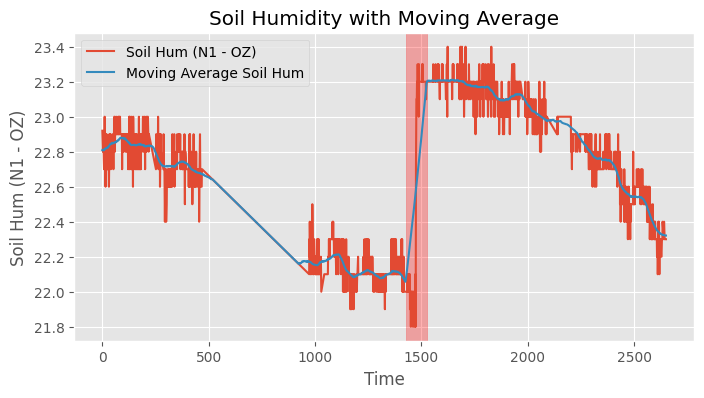

In [ ]:
df_N1OZ_later = pd.read_csv('N1OZ_later.csv')
window_size = 100  # Moving average window size

df_N1OZ_later['Time'] = pd.to_datetime(df_N1OZ_later['Time'], unit='ms')
df_N1OZ_later = MinProcessing(df_N1OZ_later, 'Soil Hum (N1 - OZ)', 10)
df_N1OZ_later = df_N1OZ_later.dropna(subset=['Soil Hum (N1 - OZ)'])

# Calculate and clean up the moving average
df_N1OZ_later['Moving Average Soil Hum'] = df_N1OZ_later['Soil Hum (N1 - OZ)'].rolling(window=window_size, center=True).mean()
df_N1OZ_later = df_N1OZ_later.dropna(subset=['Moving Average Soil Hum'])

# Select a specific data range
df_N1OZ_later = df_N1OZ_later.iloc[150:2800].reset_index(drop=True)

# Detect and mark watering events
df_N1OZ_later, peaks = watering(df_N1OZ_later, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N1OZ_later)}")
plt.plot(np.arange(len(df_N1OZ_later)), df_N1OZ_later['Soil Hum (N1 - OZ)'], label='Soil Hum (N1 - OZ)')
plt.plot(np.arange(len(df_N1OZ_later)), df_N1OZ_later['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N1 - OZ)')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2211


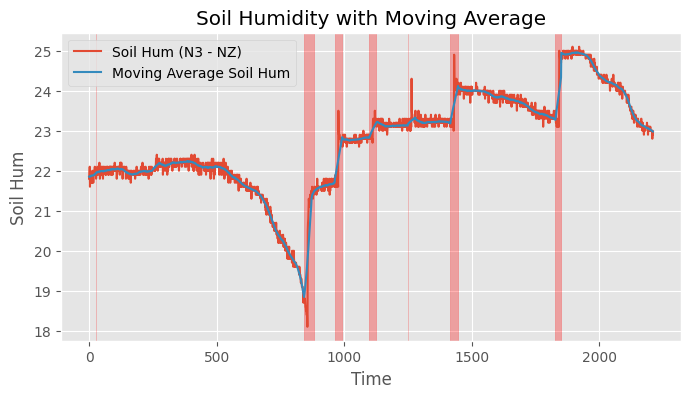

In [ ]:
df_N3NZ = pd.read_csv('N3NZ.csv')
window_size = 30

df_N3NZ['Time'] = pd.to_datetime(df_N3NZ['Time'], unit='ms')
df_N3NZ = df_N3NZ.dropna(subset=['Soil Hum (N3 - NZ)'])

# Calculate the moving average and clean up
df_N3NZ['Moving Average Soil Hum'] = df_N3NZ['Soil Hum (N3 - NZ)'].rolling(window=window_size, center=True).mean()
df_N3NZ = df_N3NZ.dropna(subset=['Moving Average Soil Hum'])

# Load and preprocess the later N3NZ dataset
df_N3NZ_later = pd.read_csv('N3NZ_later.csv')

df_N3NZ_later['Time'] = pd.to_datetime(df_N3NZ_later['Time'], unit='ms')
df_N3NZ_later = df_N3NZ_later.dropna(subset=['Soil Hum (N3 - NZ)'])

df_N3NZ_later['Moving Average Soil Hum'] = df_N3NZ_later['Soil Hum (N3 - NZ)'].rolling(window=window_size, center=True).mean()
df_N3NZ_later = df_N3NZ_later.dropna(subset=['Moving Average Soil Hum'])

# Reset index and select a specific data range
df_N3NZ_later = df_N3NZ_later.reset_index(drop=True)
df_N3NZ_later = df_N3NZ_later.iloc[:360]

# Concatenate the two datasets
df_N3NZ = pd.concat([df_N3NZ, df_N3NZ_later], axis=0).reset_index(drop=True)

# Detect and mark watering events
df_N3NZ, peaks = watering(df_N3NZ, 'Moving Average Soil Hum', 0.012)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N3NZ)}")
plt.plot(np.arange(len(df_N3NZ)), df_N3NZ['Soil Hum (N3 - NZ)'], label='Soil Hum (N3 - NZ)')
plt.plot(np.arange(len(df_N3NZ)), df_N3NZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 1800


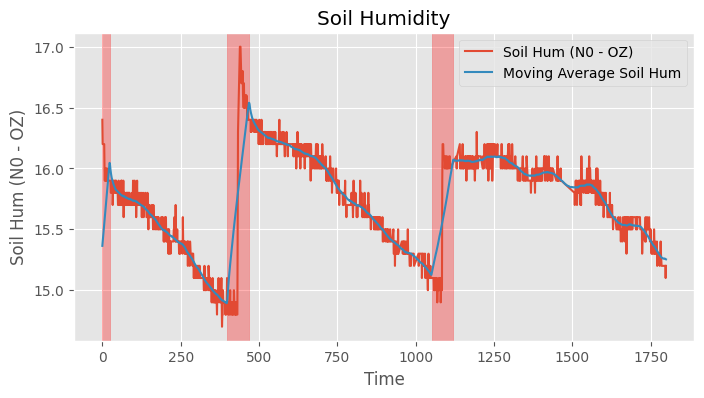

In [ ]:
df_N0OZ = pd.read_csv('N0OZ.csv')
window_size = 70

df_N0OZ['Time'] = pd.to_datetime(df_N0OZ['Time'], unit='ms')

# Apply Min and Max processing
df_N0OZ = MinProcessing(df_N0OZ, 'Soil Hum (N0 - OZ)', 10)
df_N0OZ = MaxProcessing(df_N0OZ, 'Soil Hum (N0 - OZ)', 18)
df_N0OZ = df_N0OZ.dropna(subset=['Soil Hum (N0 - OZ)'])

# Calculate and clean up the moving average
df_N0OZ['Moving Average Soil Hum'] = df_N0OZ['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()
df_N0OZ = df_N0OZ.dropna(subset=['Moving Average Soil Hum'])

# Separate, process, and recombine parts of the dataset
df_N0OZ_before = df_N0OZ.iloc[:1000, :]
df_N0OZ_after = df_N0OZ.iloc[1000:, :]
df_N0OZ_before = MaxProcessing(df_N0OZ_before, 'Soil Hum (N0 - OZ)', 17)
df_N0OZ = pd.concat([df_N0OZ_before, df_N0OZ_after], axis=0)

# Focus on a specific data range
df_N0OZ = df_N0OZ.iloc[100:1900].reset_index(drop=True)

# Detect and mark watering events
df_N0OZ, peaks = watering(df_N0OZ, 'Moving Average Soil Hum', 0.01)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the data
print(f"Row's number {len(df_N0OZ)}")
plt.plot(np.arange(len(df_N0OZ['Time'])), df_N0OZ['Soil Hum (N0 - OZ)'], label='Soil Hum (N0 - OZ)')
plt.plot(np.arange(len(df_N0OZ['Time'])), df_N0OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N0 - OZ)')
plt.title('Soil Humidity')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 1681


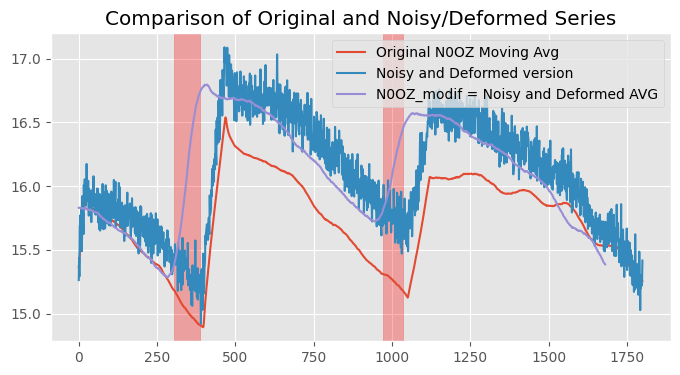

In [ ]:
serie = df_N0OZ['Moving Average Soil Hum']

# Add Gaussian noise to the series
noise = np.random.normal(0, 0.1, len(serie))
noisy_serie = serie + noise

# Deform the series with a sinusoidal pattern
deformed_serie = noisy_serie * (1 + 0.035 * np.sin(np.linspace(0, np.pi, len(noisy_serie))))

# Create a new DataFrame with the deformed series
df_N0OZ_modif = pd.DataFrame({
    'Soil Hum (N0 - OZ)': deformed_serie
})

# Calculate the moving average for the modified series
window_size = 70
df_N0OZ_modif['Moving Average Soil Hum'] = df_N0OZ_modif['Soil Hum (N0 - OZ)'].rolling(window=window_size, center=True).mean()

# Clean up and prepare the modified series
df_N0OZ_modif = df_N0OZ_modif.dropna(subset=['Moving Average Soil Hum'])
df_N0OZ_modif = df_N0OZ_modif.iloc[50:].reset_index(drop=True)

# Detect and mark watering events in the modified series
df_N0OZ_modif, peaks = watering(df_N0OZ_modif, 'Moving Average Soil Hum', 0.008)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Plot the original, noisy/deformed, and modified series
print(f"Row's number {len(df_N0OZ_modif)}")
plt.plot(serie, label='Original N0OZ Moving Avg')
plt.plot(deformed_serie, label='Noisy and Deformed version')
plt.plot(df_N0OZ_modif['Moving Average Soil Hum'], label='N0OZ_modif = Noisy and Deformed AVG')
plt.legend()
plt.title('Comparison of Original and Noisy/Deformed Series')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Row's number 2571


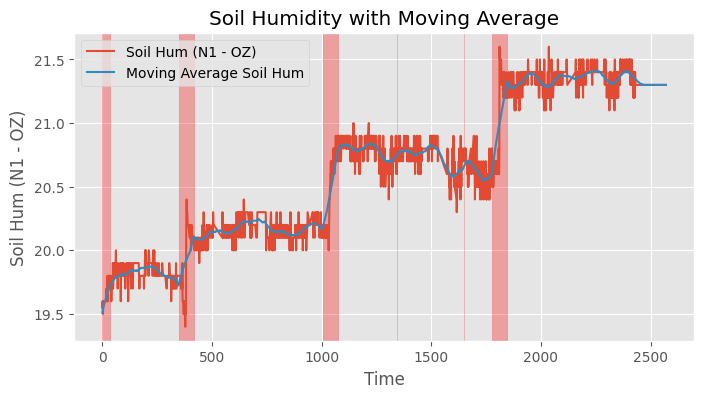

In [ ]:
df_N1OZ = pd.read_csv('N1OZ.csv')
window_size = 70

df_N1OZ['Time'] = pd.to_datetime(df_N1OZ['Time'], unit='ms')

# Apply minimum processing to clean the data
df_N1OZ = MinProcessing(df_N1OZ, 'Soil Hum (N1 - OZ)', 10)

# Remove rows with missing soil humidity data
df_N1OZ = df_N1OZ.dropna(subset=['Soil Hum (N1 - OZ)'])

# Calculate the moving average for soil humidity
df_N1OZ['Moving Average Soil Hum'] = df_N1OZ['Soil Hum (N1 - OZ)'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
df_N1OZ = df_N1OZ.dropna(subset=['Moving Average Soil Hum'])

# Focus on a specific range of data
df_N1OZ = df_N1OZ.iloc[150:].reset_index(drop=True)

# Detect and mark watering events
df_N1OZ, peaks = watering(df_N1OZ, 'Moving Average Soil Hum', 0.005)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

print(f"Row's number {len(df_N1OZ)}")

# Plot the soil humidity and its moving average
plt.plot(np.arange(len(df_N1OZ)), df_N1OZ['Soil Hum (N1 - OZ)'], label='Soil Hum (N1 - OZ)')
plt.plot(np.arange(len(df_N1OZ)), df_N1OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N1 - OZ)')
plt.title('Soil Humidity with Moving Average')
plt.legend()
plt.show()


Row's number 1850


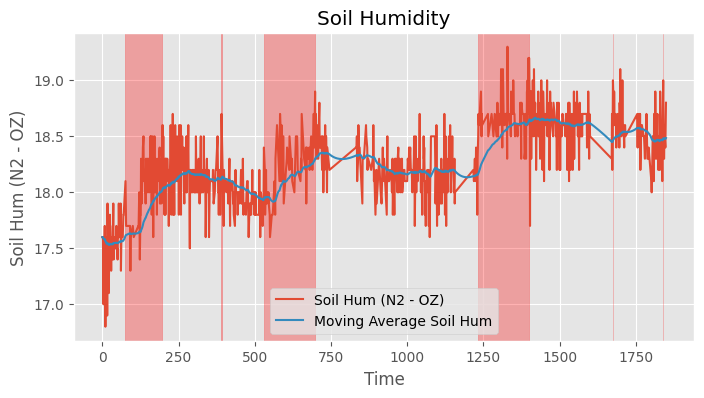

In [ ]:
df_N2OZ = pd.read_csv('N2OZ.csv')
window_size = 120

df_N2OZ['Time'] = pd.to_datetime(df_N2OZ['Time'], unit='ms')

# Apply Min and Max processing to clean the data
df_N2OZ = MinProcessing(df_N2OZ, 'Soil Hum (N2 - OZ)', 16)
df_N2OZ = MaxProcessing(df_N2OZ, 'Soil Hum (N2 - OZ)', 22)
df_N2OZ = df_N2OZ.dropna(subset=['Soil Hum (N2 - OZ)'])

# Calculate the exponentially weighted moving average for soil humidity
df_N2OZ['Moving Average Soil Hum'] = df_N2OZ['Soil Hum (N2 - OZ)'].ewm(span=window_size, adjust=False).mean()
df_N2OZ = df_N2OZ.dropna(subset=['Moving Average Soil Hum'])

# Focus on a specific data range
df_N2OZ = df_N2OZ.iloc[:1850].reset_index(drop=True)

# Detect and mark watering events with a custom merge size
df_N2OZ, peaks = watering(df_N2OZ, 'Moving Average Soil Hum', 0.007, merge_size=100)
for start, end in peaks:
    plt.axvspan(start, end, color='red', alpha=0.3)

# Print the number of rows in the final dataset
print(f"Row's number {len(df_N2OZ)}")

# Plot the soil humidity and its moving average
plt.plot(np.arange(len(df_N2OZ)), df_N2OZ['Soil Hum (N2 - OZ)'], label='Soil Hum (N2 - OZ)')
plt.plot(np.arange(len(df_N2OZ)), df_N2OZ['Moving Average Soil Hum'], label='Moving Average Soil Hum')
plt.xlabel('Time')
plt.ylabel('Soil Hum (N2 - OZ)')
plt.title('Soil Humidity')
plt.legend()
plt.show()


###Dataset Signal


In [ ]:
J_T1_A = pd.read_csv('J_T1_A.csv')
J_T1_A['Time'] = pd.to_datetime(J_T1_A['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data
J_T1_A = MinProcessing(J_T1_A, ' Avg', 2)

# Calculate the moving average of the signal
J_T1_A['Moving Avg'] = J_T1_A[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T1_A = J_T1_A.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T1_A)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T1_A)), J_T1_A[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T1_A)), J_T1_A['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


Row's number 2255


Row's number 2255


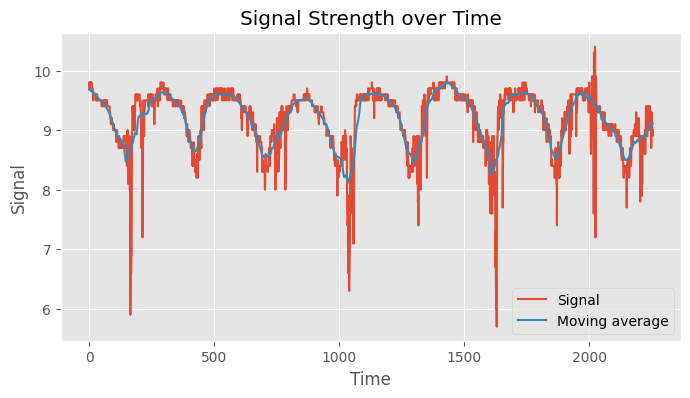

In [ ]:
J_T2_A = pd.read_csv('J_T2_A.csv')
J_T2_A['Time'] = pd.to_datetime(J_T2_A['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data
J_T2_A = MinProcessing(J_T2_A, ' Avg', 2)

# Calculate the moving average of the signal
J_T2_A['Moving Avg'] = J_T2_A[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T2_A = J_T2_A.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T2_A)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T2_A)), J_T2_A[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T2_A)), J_T2_A['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()

Row's number 1800


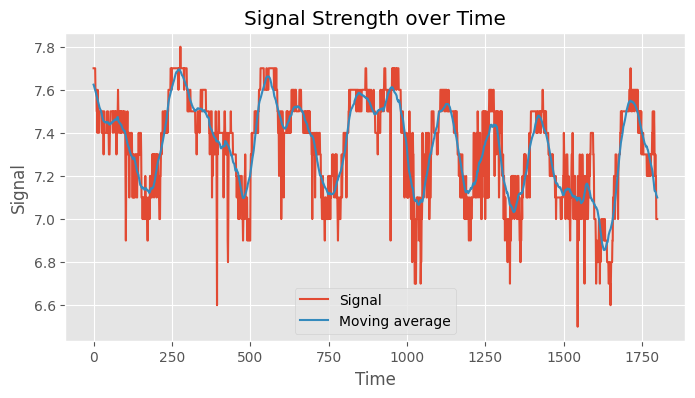

In [ ]:
J_T1_B = pd.read_csv('J_T1_B.csv')
J_T1_B['Time'] = pd.to_datetime(J_T1_B['Time'], dayfirst=True)
window_size = 50  # Set the window size for the moving average

# Apply MinProcessing to clean the signal data with a threshold of 6.4
J_T1_B = MinProcessing(J_T1_B, ' Avg', 6.4)

# Calculate the moving average of the signal
J_T1_B['Moving Avg'] = J_T1_B[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows where the moving average could not be calculated
J_T1_B = J_T1_B.dropna(subset=['Moving Avg'])

# Select the first 1800 rows for analysis
J_T1_B = J_T1_B.iloc[:1800].reset_index(drop=True)

# Print the number of rows in the processed dataset
print(f"Row's number {len(J_T1_B)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T1_B)), J_T1_B[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T1_B)), J_T1_B['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


<ipython-input-22-f29315d10096>:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  J_T2_B['Time'] = pd.to_datetime(J_T2_B['Time'], dayfirst=True)


Row's number 2255


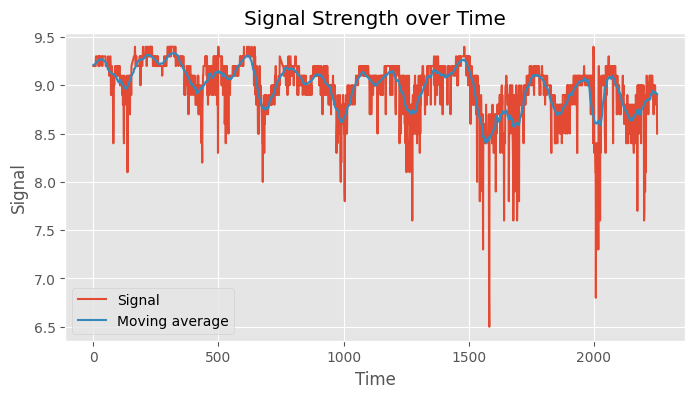

In [ ]:
# Load and preprocess the J_T2_B dataset, skipping the first row
J_T2_B = pd.read_csv('J_T2_B.csv', skiprows=1)

# Convert 'Time' column to datetime format with day-first notation
J_T2_B['Time'] = pd.to_datetime(J_T2_B['Time'], dayfirst=True)

# Set the window size for calculating the moving average
window_size = 50

# Apply minimum value processing to clean the data
J_T2_B = MinProcessing(J_T2_B, ' Avg', 6.4)

# Calculate the moving average of the ' Avg' column
J_T2_B['Moving Avg'] = J_T2_B[' Avg'].rolling(window=window_size, center=True).mean()

# Remove rows with missing values in 'Moving Avg'
J_T2_B = J_T2_B.dropna(subset=['Moving Avg']).reset_index(drop=True)

# Print the total number of rows after preprocessing
print(f"Row's number {len(J_T2_B)}")

# Plot the original signal and its moving average
plt.plot(np.arange(len(J_T2_B)), J_T2_B[' Avg'], label='Signal')
plt.plot(np.arange(len(J_T2_B)), J_T2_B['Moving Avg'], label='Moving average')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Strength over Time')
plt.legend()
plt.show()


###Correlation Matrix

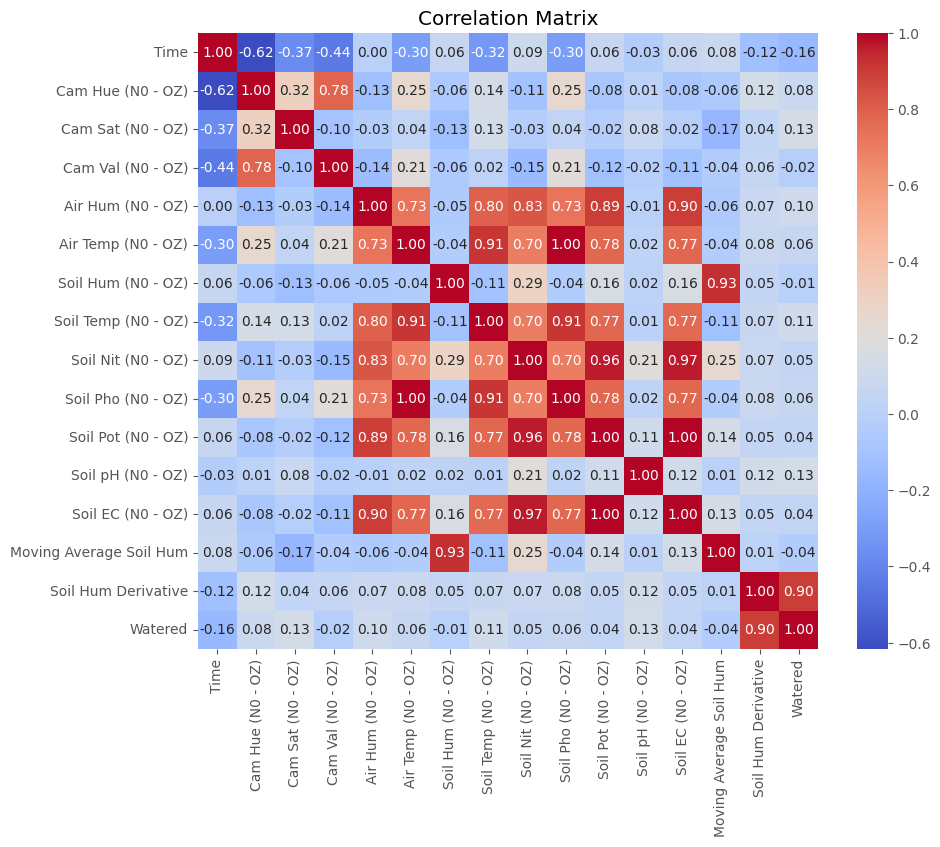

Most Correlated Soil Hum (N0 - OZ): ['Moving Average Soil Hum', 'Soil Nit (N0 - OZ)', 'Soil Pot (N0 - OZ)', 'Soil EC (N0 - OZ)', 'Time', 'Soil Hum Derivative', 'Soil pH (N0 - OZ)', 'Watered', 'Air Temp (N0 - OZ)', 'Soil Pho (N0 - OZ)', 'Air Hum (N0 - OZ)', 'Cam Val (N0 - OZ)', 'Cam Hue (N0 - OZ)', 'Soil Temp (N0 - OZ)', 'Cam Sat (N0 - OZ)']


In [ ]:
#Correlation MATRIX and most related features
df = df_N0OZ.copy() #Chose
target_feature = 'Soil Hum (N0 - OZ)' #Chose


correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

correlations = correlation_matrix[target_feature]

sorted_correlations = correlations.sort_values(ascending=False)
filtered_features = sorted_correlations.index.tolist()
filtered_features.remove(target_feature)

print(f"Most Correlated {target_feature}: {filtered_features}")


## Global functions


In [ ]:
def data_preparation(series, version, sequence_length, prediction_steps, train_size, val_size):
    """Prepare the data for training, validation, and testing based on the specified version."""

    if len(series) == 0:
        raise ValueError("The series is empty")  # Ensure the series is not empty

    # Calculate indices for splitting the series into training, validation, and test sets
    split_idx_train = int(train_size * len(series))
    split_idx_val = int((train_size + val_size) * len(series))

    # Split the series into training, validation, and test sets
    train_series = series[:split_idx_train].values.reshape(-1, 1)
    val_series = series[split_idx_train:split_idx_val].values.reshape(-1, 1)
    test_series = series[split_idx_val:].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the MinMaxScaler

    train_series_scaled = scaler.fit_transform(train_series)
    val_series_scaled = scaler.transform(val_series)
    test_series_scaled = scaler.transform(test_series)

    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the MinMaxScaler

    # Scale the series based on the version type
    if version == 'features' or version == 'long_features':
        train_series_scaled = scaler.fit_transform(train_series)
        val_series_scaled = scaler.transform(val_series)
        test_series_scaled = scaler.transform(test_series)
    else:
        train_series_scaled = scaler.fit_transform(train_series.reshape(-1, 1))
        val_series_scaled = scaler.transform(val_series.reshape(-1, 1))
        test_series_scaled = scaler.transform(test_series.reshape(-1, 1))

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    # Prepare sequences and targets for the 'long_features' version
    if version == 'long_features':
        for i in range(len(train_series_scaled) - sequence_length - prediction_steps + 1):
            X_train.append(train_series_scaled[i:i + sequence_length])
            y_train.append(train_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])
        for i in range(len(val_series_scaled) - sequence_length - prediction_steps + 1):
            X_val.append(val_series_scaled[i:i + sequence_length])
            y_val.append(val_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])
        for i in range(len(test_series_scaled) - sequence_length - prediction_steps + 1):
            X_test.append(test_series_scaled[i:i + sequence_length])
            y_test.append(test_series_scaled[i + sequence_length:i + sequence_length + prediction_steps])

    # Prepare sequences and targets for other versions
    else:
        for i in range(len(train_series_scaled) - sequence_length):
            X_train.append(train_series_scaled[i:i + sequence_length])
            y_train.append(train_series_scaled[i + sequence_length])
        for i in range(len(val_series_scaled) - sequence_length):
            X_val.append(val_series_scaled[i:i + sequence_length])
            y_val.append(val_series_scaled[i + sequence_length])
        for i in range(len(test_series_scaled) - sequence_length):
            X_test.append(test_series_scaled[i:i + sequence_length])
            y_test.append(test_series_scaled[i + sequence_length])

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Adjust target shape based on the version type
    if version == 'features':
        y_train = y_train[:,0]
        y_val = y_val[:,0]
        y_test = y_test[:,0]

    if version == 'long_features':
        y_train = y_train[:,:,0]
        y_val = y_val[:,:,0]
        y_test = y_test[:,:,0]


    # Return the prepared datasets and the scaled series
    return X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def build_lstm_model_conv(n_steps_in, num_layers, hidden_size, n_steps_out, input_shape):
    model = Sequential()

    # Input and initial Conv1D layer with causal padding
    model.add(Input(shape=(n_steps_in, input_shape)))
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal'))

    # LSTM layers, with all but the last returning sequences
    for _ in range(num_layers - 1):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(LSTM(hidden_size))

    # Dropout and Dense layers
    model.add(Dropout(0.2))
    model.add(Dense(hidden_size, activation="relu"))
    model.add(Dense(n_steps_out))

    return model

def build_model():
    model = build_lstm_model_conv(N_STEPS_IN, NUM_LAYERS, HIDDEN_SIZE, N_STEPS_OUT, INPUT_SHAPE)

    optimizer = Adam(clipvalue=5.0)
    loss = tf.keras.losses.MeanSquaredError()

    model.compile(optimizer=optimizer, loss=loss)

    return model

In [ ]:
def train_model(model, train_data, val_data, num_epochs, learning_rate, batch_size, val_training=True):
    X_train, y_train = train_data
    X_val, y_val = val_data

    # Check if a GPU is available for training, otherwise, use CPU
    if tf.config.list_physical_devices('GPU'):
        print("GPU is available. Training on GPU.")
    else:
        print("GPU is not available. Training on CPU.")

    # If validation during training is enabled, set up training with validation monioring
    if val_training:
        # Reduce learning rate when a metric has stopped improving
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0000001)
        # Stop training when a monitored metric has stopped improving
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        # Train the model with validation data
        history = model.fit(
            X_train, y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[reduce_lr, early_stopping]
        )
    else:
        # If no validation, use a simpler version of ReduceLROnPlateau and EarlyStopping without validation monitoring (for testing purposes, not used for now)
        reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.00001)
        early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
        # Train the model without validation data
        history = model.fit(
            X_train, y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=[reduce_lr, early_stopping]
        )

    # Return the trained model and the loss history on the training set (we could alos could return the loss on the validation set)
    return model, history.history['loss']



def evaluate_model(model, test_data, version):
    X_test, y_test = test_data

    # Generate predictions using the model
    predictions = model.predict(X_test, verbose=0)

    # Calculate evaluation metrics based on the version
    if version == 'long' or version == 'long_features':
        # For 'long' or 'long_features' version, compare only the first feature (the one of interest)
        mae = mean_absolute_error(y_test[:, 0], predictions[:, 0])
        mse = mean_squared_error(y_test[:, 0], predictions[:, 0])
        mape = mean_absolute_percentage_error(y_test[:, 0], predictions[:, 0])
    else:
        # For other versions, compare the entire output
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)

    rmse = np.sqrt(mse)

    # Return the calculated metrics and predictions
    return mae, mse, rmse, mape, predictions


#Model Testing

##Model Definition for local model


In [ ]:
VERSION = 'long_features' #or 'classic' (but classic is not used)
DATASET = 'soil_moisture' #or = 'soil_moisture'

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

if DATASET == 'signal':
  FEATURES = ['Moving Avg']
else:
  FEATURES = ['Moving Average Soil Hum', 'Watered']

INPUT_SHAPE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 1
OUTPUT_SIZE = 1

N_STEPS_IN = 200
N_STEPS_OUT = 30

BATCH_SIZE = 64
LEARNING_RATE = 5e-3

NUM_EPOCHS = 30

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
if DATASET == 'soil_moisture':
  df_client = df_N1OZ_later[['Moving Average Soil Hum', 'Watered']]
else:
  df_client = J_T2_A['Moving Avg']

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(df_client, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE)

model = build_model()
init_weights = model.get_weights()

model.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 200, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,454 (466.62 KB)

 Trainable params: 119,454 (466.62 KB)

 Non-trainable params: 0 (0.00 B)

##Training

###Learning Rate Tuning

In [ ]:
model.set_weights(init_weights)

START_LR = 1e-5
EPOCHS_LR = 20

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: START_LR * 10**(epoch / 20))

history = model.fit(X_train, y_train, epochs=EPOCHS_LR, callbacks=[lr_schedule])

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.4696 - learning_rate: 1.0000e-05
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4433 - learning_rate: 1.1220e-05
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3863 - learning_rate: 1.2589e-05
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2849 - learning_rate: 1.4125e-05
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2519 - learning_rate: 1.5849e-05
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2441 - learning_rate: 1.7783e-05
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2408 - learning_rate: 1.9953e-05
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2378 - learning_rate: 2.2387e-05
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2345 - learning_rate: 2.5119e-05
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2312 - learning_rate: 2.8184e-05
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 1

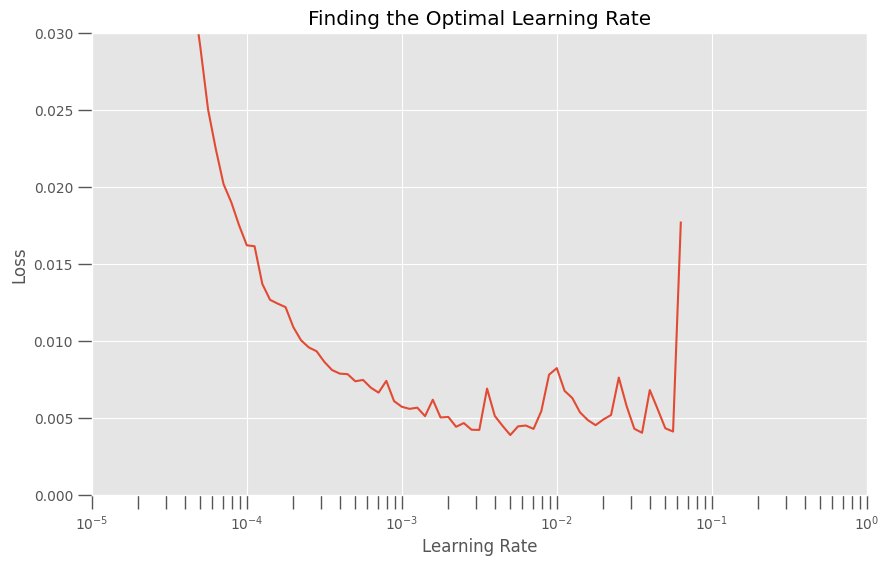

In [ ]:
# Generate a range of learning rates for testing
lrs = START_LR * (10 ** (np.arange(EPOCHS_LR) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)

# Plot the loss against the learning rates on a logarithmic scale
plt.semilogx(lrs, history.history["loss"])

# Customize tick marks on both axes
plt.tick_params('both', length=10, width=1, which='both')

# Set the axis limits: [x_min, x_max, y_min, y_max]
plt.axis([START_LR, 1, 0, 0.03])

plt.title('Finding the Optimal Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()


###Actual Training

In [ ]:
LEARNING_RATE = 5e-3
NUM_EPOCHS = 20

model.set_weights(init_weights)

model, epoch_losses = train_model(model, (X_train, y_train), (X_test, y_test), NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE)

GPU is available. Training on GPU.
Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4438 - val_loss: 0.2855 - learning_rate: 8.9125e-05
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2662 - val_loss: 0.2338 - learning_rate: 8.9125e-05
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2375 - val_loss: 0.2299 - learning_rate: 8.9125e-05
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2329 - val_loss: 0.2257 - learning_rate: 8.9125e-05
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2276 - val_loss: 0.2179 - learning_rate: 8.9125e-05
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2185 - val_loss: 0.1987 - learning_rate: 8.9125e-05
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1952 - val_loss: 0.1409 - learning_rate: 8.9125e-05
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1247 - val_loss: 0.0253 - learning_rate: 8.9125e-05
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.

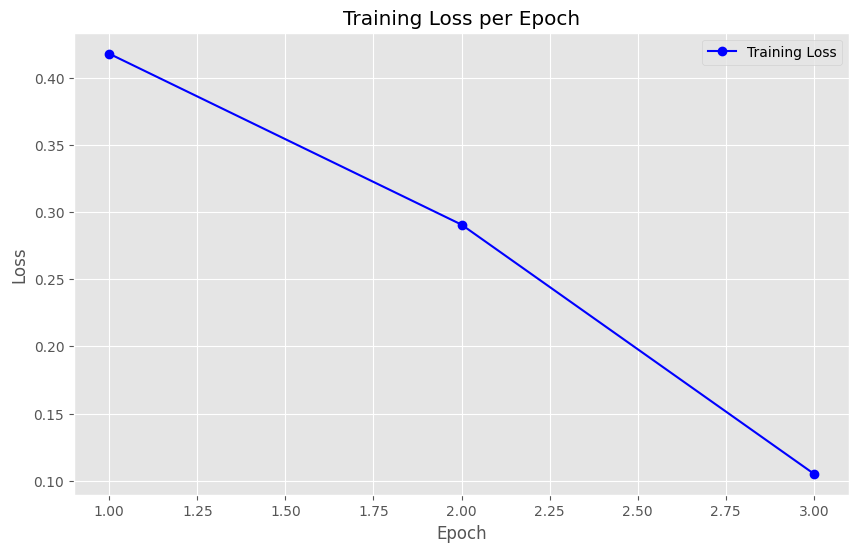

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(epoch_losses)), epoch_losses[1:], marker='o', linestyle='-', color='b', label='Training Loss')

plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()


#Federated Learning

##General Functions


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    net.set_weights(parameters)

def get_parameters(net) -> List[np.ndarray]:
    return net.get_weights()

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    # Extract the number of samples from each metrics entry
    num_samples_list = [num_samples for num_samples, _ in metrics]
    num_samples_sum = sum(num_samples_list)

    weighted_metrics: Dict[str, List[float]] = {}

    # Calculate weighted values for each metric
    for num_samples, metrics_dict in metrics:
        for metric, value in metrics_dict.items():
            if metric not in weighted_metrics:
                weighted_metrics[metric] = []
            weighted_metrics[metric].append(value * num_samples)

    # Compute the final weighted average for each metric
    return {metric: sum(values) / num_samples_sum for metric, values in weighted_metrics.items()}


def compute_weighted_average_weights(weights1, weights2, alpha1, alpha2):
    averaged_weights = []
    for w1, w2 in zip(weights1, weights2):
        averaged_weight = alpha1 * w1 + alpha2 * w2
        averaged_weights.append(averaged_weight)
    return averaged_weights


def load_weights_from_pkl(filepath):
    """
    Load and return the 'global_parameters' from a pickle file (used to store model's parameters).
    """
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['global_parameters']


## Client def

In [ ]:
DATASET = 'soil_moisture' #or 'signal'

if DATASET == 'signal':
    # Assign data to clients for the 'signal' dataset
    client_data_LS1 = {
        0: J_T1_A['Moving Avg'],
        1: J_T2_A['Moving Avg'],
    }
    client_data_LS2 = {
        0: J_T1_B['Moving Avg'],
        1: J_T2_B['Moving Avg'],
    }
    client_data = {
        0: J_T1_A['Moving Avg'],
        1: J_T2_A['Moving Avg'],
        2: J_T1_B['Moving Avg'],
        3: J_T2_B['Moving Avg'],
    }
else:
    # Assign data to clients for the 'soil_moisture' dataset
    client_data_LS1 = {
        0: df_N0OZ[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_modif[['Moving Average Soil Hum', 'Watered']]
    }

    client_data_LS2 = {
        0: df_N1OZ_later[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_later[['Moving Average Soil Hum', 'Watered']]
    }

    client_data = {
        0: df_N0OZ[['Moving Average Soil Hum', 'Watered']],
        1: df_N0OZ_modif[['Moving Average Soil Hum', 'Watered']],
        2: df_N1OZ_later[['Moving Average Soil Hum', 'Watered']],
        3: df_N0OZ_later[['Moving Average Soil Hum', 'Watered']]
    }

# Count the number of samples for each client in LS1 and LS2
num_ls1 = {client_id: data.shape[0] for client_id, data in client_data_LS1.items()}
num_ls2 = {client_id: data.shape[0] for client_id, data in client_data_LS2.items()}

# Calculate total samples in each dataset
total_samples_ls1 = sum(num_ls1.values())
total_samples_ls2 = sum(num_ls2.values())
total_samples = total_samples_ls1 + total_samples_ls2

# Print the total number of samples in LS1 and LS2
print("Total number of samples in client_data_LS1:", total_samples_ls1)
print("Total number of samples in client_data_LS2:", total_samples_ls2)


Total number of samples in client_data_LS1: 3481
Total number of samples in client_data_LS2: 5550


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, X_train, y_train, X_val, y_val, X_test, y_test, cid):
        """Initialize the Flower client with model and data."""
        self.net = net
        self.x_train = X_train
        self.y_train = y_train
        self.x_val = X_val
        self.y_val = y_val
        self.x_test = X_test
        self.y_test = y_test
        self.cid = cid

    def get_parameters(self, config):
        """Return the current model parameters."""
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def set_parameters(self, config):
        """Set the model parameters from the server."""
        print(f"[Client {self.cid}] set_parameters")
        return set_parameters(self.net)

    def fit(self, parameters, config):
        """Train the model on the local dataset."""
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        batch_size = config["batch_size"]
        learning_rate = config["learning_rate"]
        print(f"[Client {self.cid}, round {server_round}] fit")

        # Set the model's weights from the received parameters
        self.net.set_weights(parameters)

        # Train the model with local data
        self.net, _ = train_model(self.net, (self.x_train, self.y_train), (self.x_val, self.y_val), local_epochs, learning_rate, batch_size)

        # Return the updated parameters and the number of training samples
        return get_parameters(self.net), len(self.x_train), {}

    def evaluate(self, parameters, config):
        """Evaluate the model on the local test dataset."""
        print(f"[Client {self.cid}] evaluate")

        # Set the model's weights from the received parameters
        self.net.set_weights(parameters)

        # Evaluate the model and return the metrics
        mae, mse, rmse, mape, _ = evaluate_model(self.net, (self.x_test, self.y_test), VERSION)
        return mse, len(self.x_test), {"mae": mae, "mse": mse, "rmse": rmse, "mape": mape}


In [ ]:
def client_fn_LS1(context: Context) -> Client:
    """Create and return a Flower client for LS1."""
    model = build_model()  # Build the model

    # Get client ID from context
    cid = int(context.node_config["partition-id"])

    # Prepare data for the client
    X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
        client_data_LS1[cid], VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
    )

    print(f"Client number {cid} created")

    # Return the Flower client wrapped in the expected client interface
    return FlowerClient(model, X_train, y_train, X_val, y_val, X_test, y_test, cid).to_client()


def client_fn_LS2(context: Context) -> Client:
    """Create and return a Flower client for LS2."""
    model = build_model()  # Build the model

    # Get client ID from context
    cid = int(context.node_config["partition-id"])

    # Prepare data for the client
    X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
        client_data_LS2[cid], VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
    )

    print(f"Client number {cid} created")

    # Return the Flower client wrapped in the expected client interface
    return FlowerClient(model, X_train, y_train, X_val, y_val, X_test, y_test, cid).to_client()


##Strategy Functions

In [ ]:
class FedAvgWithModelSaving(fl.server.strategy.FedAvg):
    def __init__(self, save_path: str, count: int, local: bool, *args, **kwargs):
        """Initialize FedAvg strategy with model saving capability."""
        self.save_path = Path(save_path)
        self.save_path.mkdir(exist_ok=True, parents=True)  # Ensure the save directory exists
        super().__init__(*args, **kwargs)
        self.local = local
        if local:
            self.count = 0  # Initialize counter if count running locally
        else:
            self.count = count  # Use provided count if not local (imposed by code)

    def _save_global_model(self, server_round: int, parameters):
        """Save the global model parameters to a pickle file."""
        print(f"SAVING MODEL {self.count}")
        ndarrays = parameters_to_ndarrays(parameters)  # Convert parameters to ndarray format
        data = {'global_parameters': ndarrays}
        filename = str(self.save_path / f"parameters_round_{self.count}.pkl")

        if self.local:
            self.count += 1  # Increment the counter if running locally

        # Save the model parameters to a pickle file
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)

        log(INFO, f"Checkpoint saved to: {filename}")

    def evaluate(self, server_round: int, parameters):
        """Evaluate the model and save the global model parameters."""
        self._save_global_model(server_round, parameters)  # Save model before evaluation
        return super().evaluate(server_round, parameters)  # Perform the evaluation from FedAvg


In [ ]:
def strategy(name, params, count, local):
    strategy = FedAvgWithModelSaving(
            local=local,
            save_path=name,
            count=count,
            fraction_fit=1.0,
            fraction_evaluate=1.0,
            min_available_clients=2,
            min_fit_clients=2,
            min_evaluate_clients=2,
            fit_metrics_aggregation_fn=weighted_average,
            evaluate_metrics_aggregation_fn=weighted_average,
            on_fit_config_fn=fit_config,
            initial_parameters=ndarrays_to_parameters(params),)
    return strategy

## Simulation Functions

In [ ]:
client_resources = {"num_cpus": 2}
if tf.config.get_visible_devices("GPU"):
    client_resources["num_gpus"] = 1

def simulation(name, strategy, num_rounds, num_clients):
  if name == 'LS1':
      history = fl.simulation.start_simulation(
      client_fn=client_fn_LS1,
      num_clients=num_clients,
      config=fl.server.ServerConfig(num_rounds=num_rounds),
      strategy=strategy,
      client_resources=client_resources
      )
  elif name == 'LS2':
    history = fl.simulation.start_simulation(
    client_fn=client_fn_LS2,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
    client_resources=client_resources
    )
  return history

In [ ]:
def fit_config(server_round: int):
    return {
        "batch_size": BATCH_SIZE,
        "server_round": server_round,
        "local_epochs": LOCAL_EPOCHS,
        "learning_rate": LEARNING_RATE,
    }

def evaluate_config(rnd: int):
    return {
        "batch_size": BATCH_SIZE,
    }

In [ ]:
def global_simulation(params_1, params_2):
    """Simulate global training across multiple rounds and save the best model based on aggregated loss."""
    losses_LS1, losses_LS2 = [], []
    params_LS1 = copy.deepcopy(params_1)
    params_LS2 = copy.deepcopy(params_2)

    # Create directory for global models
    os.makedirs('Global_Model', exist_ok=True)

    # Iterates over the number of total rounds
    for i in range(NUM_ROUNDS_GLOBAL):
        print(f"ROUNDS NUMBER {i+1}/{NUM_ROUNDS_GLOBAL}")

        # Initialize strategies for LS1 and LS2
        strategy_LS1 = strategy('LS1', params_LS1, i, False)
        strategy_LS2 = strategy('LS2', params_LS2, i, False)

        # Run simulations for LS1 and LS2
        print("BEGINNING SIMULATION LS1")
        history_LS1 = simulation('LS1', strategy_LS1, 1, NUM_CLIENTS)
        print("END SIMULATION LS1")

        print("BEGINNING SIMULATION LS2")
        history_LS2 = simulation('LS2', strategy_LS2, 1, NUM_CLIENTS)
        print("END SIMULATION LS2")

        # Store losses from each round
        losses_LS1.append(history_LS1.losses_distributed)
        losses_LS2.append(history_LS2.losses_distributed)

        # Load model weights from LS1 and LS2
        weights_LS1 = load_weights_from_pkl(f'LS1/parameters_round_{i}.pkl')
        weights_LS2 = load_weights_from_pkl(f'LS2/parameters_round_{i}.pkl')

        # Average weights from both simulations
        print("AVERAGING WEIGHTS...")
        params_GL = compute_weighted_average_weights(weights_LS1, weights_LS2, total_samples_ls1/total_samples, total_samples_ls2/total_samples)

        # Save the averaged global model parameters
        print(f"SAVING GLOBAL MODEL {i}")
        data = {'global_parameters': params_GL}
        filename = str(f"Global_Model/parameters_round_{i}.pkl")
        with open(filename, 'wb') as h:
            pickle.dump(data, h, protocol=pickle.HIGHEST_PROTOCOL)
        log(INFO, f"Checkpoint saved to: {filename}")

        print("AVERAGING WEIGHTS END")
        params_LS1, params_LS2 = params_GL, params_GL  # Update parameters for the next round

    # Calculate aggregated losses and find the round with the minimum loss
    list_losses_LS1 = [loss[0][1] for loss in losses_LS1]
    list_losses_LS2 = [loss[0][1] for loss in losses_LS2]
    loss_aggregated = [loss1 * total_samples_ls1 / total_samples + loss2 * total_samples_ls2 / total_samples for (loss1, loss2) in zip(list_losses_LS1, list_losses_LS2)]
    min_loss = loss_aggregated.index(min(loss_aggregated))

    print(f"Best global model from min aggregated loss: {min_loss+1}")

    # Load and return the best global model weights
    weights = load_weights_from_pkl(f"Global_Model/parameters_round_{min_loss}.pkl")

    return weights, losses_LS1, losses_LS2, loss_aggregated


def local_server_simulation(params_1, params_2):
    """Simulate local server training for LS1 and LS2, and return the best model weights."""
    losses_LS1, losses_LS2 = [], []
    params_LS1 = copy.deepcopy(params_1)
    params_LS2 = copy.deepcopy(params_2)

    # Initialize strategies for local simulations
    strategy_LS1 = strategy('LS1_local', params_LS1, _, True)
    strategy_LS2 = strategy('LS2_local', params_LS2, _, True)

    # Run simulations for LS1 and LS2
    print("BEGINNING SIMULATION LS1")
    history_LS1 = simulation('LS1', strategy_LS1, NUM_ROUNDS_LOCAL, NUM_CLIENTS)
    print("END SIMULATION LS1")

    print("BEGINNING SIMULATION LS2")
    history_LS2 = simulation('LS2', strategy_LS2, NUM_ROUNDS_LOCAL, NUM_CLIENTS)
    print("END SIMULATION LS2")

    # Store losses from the simulations
    losses_LS1.append(history_LS1.losses_distributed)
    losses_LS2.append(history_LS2.losses_distributed)

    # Find the round with the minimum loss for LS1 and LS2
    list_losses_LS1 = [point[1] for point in losses_LS1[0]]
    min_loss_LS1 = list_losses_LS1.index(min(list_losses_LS1))
    list_losses_LS2 = [point[1] for point in losses_LS2[0]]
    min_loss_LS2 = list_losses_LS2.index(min(list_losses_LS2))

    print(f"Best model : LS1: {min_loss_LS1+1}, LS2: {min_loss_LS2+1}")

    # Load and return the best model weights
    weights_LS1 = load_weights_from_pkl(f'LS1_local/parameters_round_{min_loss_LS1+1}.pkl')
    weights_LS2 = load_weights_from_pkl(f'LS2_local/parameters_round_{min_loss_LS2+1}.pkl')

    return weights_LS1, weights_LS2, losses_LS1, losses_LS2


def local_simulation(init_params):
    """Simulate local training for each client and return the trained models and their losses."""
    params = copy.deepcopy(init_params)
    models = []
    epochs_losses = []

    # Iterate over each client in the full dataset
    for client_id, df in client_data.items():
        print(f"Client ID: {client_id}")

        # Prepare the data for the current client
        X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled = data_preparation(
            df, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE
        )
        print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

        # Build and set initial parameters for the model
        model = build_model()
        set_parameters(model, params)

        # Train the model and store the loss for each epoch
        model, epochs_loss = train_model(
            model, (X_train, y_train), (X_val, y_val), NUM_EPOCHS, LEARNING_RATE, BATCH_SIZE, val_training=True
        )
        epochs_losses.append(epochs_loss)
        models.append(model)

    # Return the list of trained models and their corresponding losses
    return models, epochs_losses


#Training and Testing

In [ ]:
VERSION = 'long_features' #or 'classic' (but classic is not used)
DATASET = 'soil_moisture' #or = 'soil_moisture' / 'signal'

TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

if DATASET == 'signal':
  FEATURES = ['Moving Avg']
else:
  FEATURES = ['Moving Average Soil Hum', 'Watered']
NB_FEATURES = len(FEATURES)

INPUT_SHAPE = 1 #len(FEATURES)
HIDDEN_SIZE = 128
NUM_LAYERS = 1
OUTPUT_SIZE = 1

N_STEPS_IN = 200
N_STEPS_OUT = 30

BATCH_SIZE = 64
LEARNING_RATE = 5e-3

LOCAL_EPOCHS = 5
NUM_CLIENTS = 2
NUM_ROUNDS_GLOBAL = 15
NUM_ROUNDS_LOCAL = NUM_ROUNDS_GLOBAL*2
NUM_EPOCHS = NUM_ROUNDS_GLOBAL*2*LOCAL_EPOCHS

In [ ]:
model = build_model()
initial_params = get_parameters(model)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 200, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,454 (466.62 KB)

 Trainable params: 119,454 (466.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
models, epochs_losses = local_simulation(initial_params)

Client ID: 0
Train samples: 2291, Val samples: 311, Test samples: 311
GPU is available. Training on GPU.
Epoch 1/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.3261 - val_loss: 0.2111 - learning_rate: 0.0010
Epoch 2/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1693 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 3/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - val_loss: 2.6533e-04 - learning_rate: 0.0010
Epoch 4/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 6.8680e-05 - learning_rate: 0.0010
Epoch 5/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 1.0213e-04 - learning_rate: 0.0010
Epoch 6/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 1.1539e-04 - learning_rate: 0.0010
Epoch 7/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - val_loss: 1.2902e-04 - learning_rate: 0.0010
Epoch 8/150
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - val_loss: 6.5513e-05 - learning_rat

In [ ]:
params_GL, losses_GL_LS1, losses_GL_LS2, loss_aggregated = global_simulation(initial_params, initial_params)

INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


ROUNDS NUMBER 1/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:32:32,723	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3995964211.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7991928423.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=6712) 2024-09-09 14:32:37.290557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=6712) 2024-09-09 14:32:37.327164: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=6712) 2024-09-09 14:32:37.337225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=6712) 2024-09-09 14:32:38.555427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=6712) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=6712) I0000 00:00:1725892360.438939    6712 cuda_executor.cc:101

(ClientAppActor pid=6712) Client number 1 created
(ClientAppActor pid=6712) [Client 1, round 1] fit
(ClientAppActor pid=6712) GPU is available. Training on GPU.
(ClientAppActor pid=6712) Epoch 1/5


(ClientAppActor pid=6712) W0000 00:00:1725892362.499223    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.577591    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.578759    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.579938    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.581136    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.582346    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892362.583487    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/34 ━━━━━━━━━━━━━━━━━━━━ 3:03 6s/step - loss: 0.4617
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4340


(ClientAppActor pid=6712) W0000 00:00:1725892366.412006    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.414093    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.415336    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.419062    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.420317    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.422449    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.423782    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3928
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3769
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3479
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3373


(ClientAppActor pid=6712) W0000 00:00:1725892366.897154    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.897947    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.898605    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.899241    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.899882    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.900542    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892366.901191    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.3355 - val_loss: 0.2173 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2136
 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2118
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2066
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1985
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1871
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1843 - val_loss: 0.0113 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0225
 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0176
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0153
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0145
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0133
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0125 - val_loss: 3.2216e-04 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 4/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

(ClientAppActor pid=6712) W0000 00:00:1725892372.838178    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.838924    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.839571    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.840206    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.840855    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.841505    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892372.842144    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3262 - val_loss: 0.2103 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2063
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2008


(ClientAppActor pid=6712) W0000 00:00:1725892373.106739    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.107449    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.108085    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.108731    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.109372    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.110010    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892373.110667    6783 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1932
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1874
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1803
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1713 - val_loss: 0.0100 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 3/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0129
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0117
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0108
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0106 - val_loss: 2.8014e-04 - learning_rate: 0.0010
(ClientAppActor pid=6712) Epoch 4/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0047
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - val_loss: 1

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_0.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0038
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0037
SAVING MODEL 0
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 2.1672e-04 - learning_rate: 0.0010
(ClientAppActor pid=6712) Client number 1 created
(ClientAppActor pid=6712) [Client 1] evaluate


(ClientAppActor pid=6712) W0000 00:00:1725892375.462081    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.462948    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.463620    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.464293    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.464955    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.465617    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=6712) W0000 00:00:1725892375.466309    6782 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=6712) Client number 0 created
(ClientAppActor pid=6712) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.001814879437553356
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.04205650167293727)],
INFO :      	 'mape': [(1, 109562375306372.38)],
INFO :      	 'mse': [(1, 0.001814879437553356)],
INFO :      	 'rmse': [(1, 0.0426012492559415)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:33:00,225	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3995958067.0, 'memory': 7991916135.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=7266) 2024-09-09 14:33:04.685801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7266) 2024-09-09 14:33:04.735516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7266) 2024-09-09 14:33:04.746214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7266) 2024-09-09 14:33:06.350827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=7266) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=7266) I0000 00:00:1725892388.204816    7266 cuda_executor.cc:101

(ClientAppActor pid=7266) Client number 1 created
(ClientAppActor pid=7266) [Client 1, round 1] fit
(ClientAppActor pid=7266) GPU is available. Training on GPU.
(ClientAppActor pid=7266) Epoch 1/5


(ClientAppActor pid=7266) W0000 00:00:1725892390.255702    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.334870    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.336035    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.337276    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.338478    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.339650    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892390.340791    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3892
10/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3631
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3504
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3178
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2965
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2816
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2688
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2635


(ClientAppActor pid=7266) W0000 00:00:1725892394.812326    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.813021    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.813675    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.814323    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.814979    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.815627    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892394.816276    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.2614 - val_loss: 0.0555 - learning_rate: 0.0010
(ClientAppActor pid=7266) Epoch 2/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0541
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0464
20/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0387
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0336
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0299
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0269
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0247
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0238
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0230 - val_loss: 5.9534e-05 - learning_rate: 0.0010
(ClientAppActor pid=7266) Epoch 3/5
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0036
29/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035
41/60 ━━━━━━━

(ClientAppActor pid=7266) W0000 00:00:1725892402.152108    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.152919    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.153633    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.154322    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.155021    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.155695    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.156354    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.3162 - val_loss: 0.1264 - learning_rate: 0.0010
(ClientAppActor pid=7266) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1138


(ClientAppActor pid=7266) W0000 00:00:1725892402.447515    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.448285    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.448966    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.449648    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.450306    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.450945    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892402.451600    7351 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0852
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0688
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0636
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0549
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0491
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0481 - val_loss: 2.0822e-04 - learning_rate: 0.0010
(ClientAppActor pid=7266) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0045
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049
23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0048
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0046 - val_loss: 2.0324e-04 - learning_rate: 0.0010
(ClientAppActor pid=7266) Epoch 4/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0040
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0034
22/55 ━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_0.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027
SAVING MODEL 0
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 7.7222e-04 - learning_rate: 0.0010
(ClientAppActor pid=7266) Client number 1 created
(ClientAppActor pid=7266) [Client 1] evaluate


(ClientAppActor pid=7266) W0000 00:00:1725892405.502234    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.503510    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.504235    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.506847    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.507535    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.508222    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7266) W0000 00:00:1725892405.508891    7352 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=7266) Client number 0 created
(ClientAppActor pid=7266) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 23.69s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00010253707538352757
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.00882367421756861)],
INFO :      	 'mape': [(1, 21664437797949.035)],
INFO :      	 'mse': [(1, 0.00010253707538352757)],
INFO :      	 'rmse': [(1, 0.010069384825245152)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_0.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 0
AVERAGING WEIGHTS END
ROUNDS NUMBER 2/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:33:31,146	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3995808153.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7991616308.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 1


(pid=7850) 2024-09-09 14:33:35.500898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=7850) 2024-09-09 14:33:35.520345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=7850) 2024-09-09 14:33:35.526168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=7850) 2024-09-09 14:33:36.669253: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=7850) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=7850) I0000 00:00:1725892418.527741    7850 cuda_executor.cc:101

(ClientAppActor pid=7850) Client number 1 created
(ClientAppActor pid=7850) [Client 1, round 1] fit
(ClientAppActor pid=7850) GPU is available. Training on GPU.
(ClientAppActor pid=7850) Epoch 1/5


(ClientAppActor pid=7850) W0000 00:00:1725892420.515949    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.594058    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.595237    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.596443    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.597637    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.598800    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892420.599926    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:56 5s/step - loss: 0.0051
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0082
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0068


(ClientAppActor pid=7850) W0000 00:00:1725892424.782422    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.785402    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.786069    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.786723    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.787365    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.788002    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892424.788647    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0068 - val_loss: 1.5214e-04 - learning_rate: 0.0010
(ClientAppActor pid=7850) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 5.5463e-05 - learning_rate: 0.0010
(ClientAppActor pid=7850) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0024
 8/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 3.4722e-05 - learning_rate: 0.0010
(ClientAppActor p

(ClientAppActor pid=7850) W0000 00:00:1725892430.938218    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.938916    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.939567    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.940220    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.940864    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.941528    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892430.942282    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0059
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0058


(ClientAppActor pid=7850) W0000 00:00:1725892431.209533    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.210225    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.210863    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.211497    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.212131    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.212777    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892431.213516    7930 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0058 - val_loss: 5.3154e-04 - learning_rate: 0.0010
(ClientAppActor pid=7850) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0034
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 6.7534e-05 - learning_rate: 0.0010
(ClientAppActor pid=7850) Epoch 3/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 9.0950e-05 - learning_rate: 0.0010
(ClientAppActor pid=7850) Epoch 4/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
SAVING MODEL 1
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 2.2978e-04 - learning_rate: 0.0010
(ClientAppActor pid=7850) Client number 1 created
(ClientAppActor pid=7850) [Client 1] evaluate


(ClientAppActor pid=7850) W0000 00:00:1725892433.302556    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.303380    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.304058    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.304706    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.305344    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.305977    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=7850) W0000 00:00:1725892433.306614    7931 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=7850) Client number 0 created
(ClientAppActor pid=7850) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.33s
INFO :      	History (loss, distributed):
INFO :      		round 1: 3.432430665053158e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.005605889239407194)],
INFO :      	 'mape': [(1, 15911672022329.473)],
INFO :      	 'mse': [(1, 3.432430665053158e-05)],
INFO :      	 'rmse': [(1, 0.0058543293479887)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:33:57,856	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3995934720.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7991869440.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 1


(pid=8416) 2024-09-09 14:34:01.970128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8416) 2024-09-09 14:34:02.009204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8416) 2024-09-09 14:34:02.019648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=8416) 2024-09-09 14:34:03.825655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=8416) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=8416) I0000 00:00:1725892445.815546    8416 cuda_executor.cc:101

(ClientAppActor pid=8416) Client number 0 created
(ClientAppActor pid=8416) [Client 0, round 1] fit
(ClientAppActor pid=8416) GPU is available. Training on GPU.
(ClientAppActor pid=8416) Epoch 1/5


(ClientAppActor pid=8416) W0000 00:00:1725892447.963608    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.079947    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.081160    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.082453    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.083787    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.085026    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892448.086220    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/55 ━━━━━━━━━━━━━━━━━━━━ 4:44 5s/step - loss: 0.0056
 4/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0079


(ClientAppActor pid=8416) W0000 00:00:1725892451.541854    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.543929    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.545152    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.549079    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.550357    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.552514    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892451.553866    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078
18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0060
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055


(ClientAppActor pid=8416) W0000 00:00:1725892452.245098    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.245803    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.246458    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.247132    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.247801    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.248451    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892452.249112    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0055 - val_loss: 5.1136e-05 - learning_rate: 0.0010
(ClientAppActor pid=8416) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0023
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 7.6576e-05 - learning_rate: 0.0010
(ClientAppActor pid=8416) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024
 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021
18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0020
34/55 ━━━

(ClientAppActor pid=8416) W0000 00:00:1725892461.320301    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.321013    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.321676    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.322340    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.323017    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.323711    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.324444    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0047 - val_loss: 6.7441e-05 - learning_rate: 0.0010
(ClientAppActor pid=8416) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021


(ClientAppActor pid=8416) W0000 00:00:1725892461.601790    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.602480    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.603127    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.603762    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.604384    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.605007    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892461.605661    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0020
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0020 - val_loss: 1.9022e-04 - learning_rate: 0.0010
(ClientAppActor pid=8416) Epoch 3/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 1.2813e-04 - learning_rate: 0.0010
(ClientAppActor pid=8416) Epoch 4/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
28/60 ━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
SAVING MODEL 1
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 6.0666e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=8416) Client number 0 created
(ClientAppActor pid=8416) [Client 0] evaluate


(ClientAppActor pid=8416) W0000 00:00:1725892464.825597    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.826288    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.826913    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.827557    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.828191    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.828812    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892464.829435    8494 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=8416) Client number 1 created
(ClientAppActor pid=8416) [Client 1] evaluate


(ClientAppActor pid=8416) W0000 00:00:1725892465.488385    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.489070    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.489707    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.490330    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.490943    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.491558    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8416) W0000 00:00:1725892465.492170    8495 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 1
AVERAGING WEIGHTS END
ROUNDS NUMBER 3/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:34:29,379	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3996044083.0, 'node:__internal_head__': 1.0, 'memory': 7992088167.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 2


(pid=8999) 2024-09-09 14:34:33.795302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8999) 2024-09-09 14:34:33.830114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8999) 2024-09-09 14:34:33.840314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=8999) 2024-09-09 14:34:35.372439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=8999) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=8999) I0000 00:00:1725892477.251356    8999 cuda_executor.cc:101

(ClientAppActor pid=8999) Client number 0 created
(ClientAppActor pid=8999) [Client 0, round 1] fit
(ClientAppActor pid=8999) GPU is available. Training on GPU.
(ClientAppActor pid=8999) Epoch 1/5


(ClientAppActor pid=8999) W0000 00:00:1725892480.001548    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.080853    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.082042    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.083300    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.084522    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.085704    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892480.086833    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/36 ━━━━━━━━━━━━━━━━━━━━ 3:07 5s/step - loss: 0.0022
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049


(ClientAppActor pid=8999) W0000 00:00:1725892483.053748    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.055801    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.057016    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.060940    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.062207    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.064316    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.065667    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039


(ClientAppActor pid=8999) W0000 00:00:1725892483.570392    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.571095    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.571766    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.572452    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.573099    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.573766    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892483.574417    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0038 - val_loss: 1.4328e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0019
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018


(ClientAppActor pid=8999) W0000 00:00:1725892484.475350    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.476025    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.476658    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.477287    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.477927    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.478572    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892484.479329    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 1.0071e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 3/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0015 - val_loss: 2.3214e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 4/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
36/36 ━━━

(ClientAppActor pid=8999) W0000 00:00:1725892489.679181    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.679912    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.680550    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.681182    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.681828    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.682501    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.683167    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0047 - val_loss: 6.9359e-05 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 2/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021


(ClientAppActor pid=8999) W0000 00:00:1725892489.975352    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.976030    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.976663    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.977297    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.977926    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.978555    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892489.979185    9074 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0020
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019 - val_loss: 3.4504e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - val_loss: 2.2590e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 4/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 1.9256e-04 - learning_rate: 0.0010
(ClientAppActor pid=8999) Epoch 5/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 1.0715e-04 - learning_rate: 2.0000e-04
SAVING MODEL 2
(ClientAppActor pid=8999) Client number 1 created
(ClientAppActor pid=8999) [Client 1] evaluate


(ClientAppActor pid=8999) W0000 00:00:1725892491.966268    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.966955    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.967587    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.968281    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.968978    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.969690    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892491.970384    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=8999) Client number 0 created
(ClientAppActor pid=8999) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.84s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.0127512127075166e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.0069017740539767305)],
(ClientAppActor pid=8999) W0000 00:00:1725892492.571791    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892492.572506    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892492.573153    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892492.573812    9073 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=8999) W0000 00:00:1725892492.574441    9073 gpu_timer.c

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:34:57,606	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7992039015.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3996019507.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 2


(pid=9564) 2024-09-09 14:35:01.151162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9564) 2024-09-09 14:35:01.184950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=9564) 2024-09-09 14:35:01.194764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=9564) 2024-09-09 14:35:03.034842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=9564) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=9564) I0000 00:00:1725892505.204427    9564 cuda_executor.cc:101

(ClientAppActor pid=9564) Client number 1 created
(ClientAppActor pid=9564) [Client 1, round 1] fit
(ClientAppActor pid=9564) GPU is available. Training on GPU.
(ClientAppActor pid=9564) Epoch 1/5


(ClientAppActor pid=9564) W0000 00:00:1725892507.368279    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.485266    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.486506    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.487808    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.489114    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.490429    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892507.491624    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

 1/60 ━━━━━━━━━━━━━━━━━━━━ 5:15 5s/step - loss: 0.0015
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0023
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0024
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020


(ClientAppActor pid=9564) W0000 00:00:1725892511.807459    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.808143    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.808795    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.809428    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.810071    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.810709    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892511.811347    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020


(ClientAppActor pid=9564) W0000 00:00:1725892512.729048    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.729728    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.730379    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.731026    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.731670    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.732291    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892512.732910    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0020 - val_loss: 5.6674e-04 - learning_rate: 0.0010
(ClientAppActor pid=9564) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 5.9759e-05 - learning_rate: 0.0010
(ClientAppActor pid=9564) Epoch 3/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
58/60 ━━━

(ClientAppActor pid=9564) W0000 00:00:1725892519.467593    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.468304    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.468938    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.469571    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.470364    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.471004    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.471643    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024


(ClientAppActor pid=9564) W0000 00:00:1725892519.744643    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.745332    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.745961    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.746591    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.747230    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.747860    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892519.748490    9641 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0024 - val_loss: 1.5798e-04 - learning_rate: 0.0010
(ClientAppActor pid=9564) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0014 - val_loss: 2.1078e-04 - learning_rate: 0.0010
(ClientAppActor pid=9564) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0012
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
55/55 ━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9365e-04
SAVING MODEL 2
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.9177e-04 - val_loss: 1.9112e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=9564) Client number 1 created
(ClientAppActor pid=9564) [Client 1] evaluate


(ClientAppActor pid=9564) W0000 00:00:1725892522.757206    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.757898    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.758529    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.759148    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.759779    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.760418    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=9564) W0000 00:00:1725892522.761048    9642 gpu_timer.cc:114] Skipping the delay kernel, measurement acc

(ClientAppActor pid=9564) Client number 0 created
(ClientAppActor pid=9564) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.13s
INFO :      	History (loss, distributed):
INFO :      		round 1: 8.578147776389463e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007400964730022282)],
INFO :      	 'mape': [(1, 9205741374755.607)],
INFO :      	 'mse': [(1, 8.578147776389463e-05)],
INFO :      	 'rmse': [(1, 0.00830024909486326)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_2.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 2
AVERAGING WEIGHTS END
ROUNDS NUMBER 4/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:35:27,660	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3995922432.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 7991844864.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 3


(pid=10147) 2024-09-09 14:35:32.288184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=10147) 2024-09-09 14:35:32.324784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10147) 2024-09-09 14:35:32.336237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=10147) 2024-09-09 14:35:33.914991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=10147) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=10147) I0000 00:00:1725892535.800881   10147 cuda_executor.

(ClientAppActor pid=10147) Client number 0 created
(ClientAppActor pid=10147) [Client 0, round 1] fit
(ClientAppActor pid=10147) GPU is available. Training on GPU.
(ClientAppActor pid=10147) Epoch 1/5


(ClientAppActor pid=10147) W0000 00:00:1725892537.953268   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.067698   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.068919   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.070181   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.071459   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.072691   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892538.073849   10224 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0027
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029


(ClientAppActor pid=10147) W0000 00:00:1725892541.542000   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.544202   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.545429   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.549929   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.551210   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.553400   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892541.554775   10225 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025


(ClientAppActor pid=10147) W0000 00:00:1725892542.072090   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.072804   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.073465   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.074133   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.074789   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.075441   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.076095   10224 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0024 - val_loss: 2.6855e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0015
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013


(ClientAppActor pid=10147) W0000 00:00:1725892542.977248   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.977935   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.978578   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.979229   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.979870   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.980512   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892542.981138   10224 gpu_timer.cc:114] Skipping the delay kernel, measurem

23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 1.3634e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 3/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 2.0572e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 4/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_l

(ClientAppActor pid=10147) W0000 00:00:1725892548.419277   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.420104   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.420882   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.421639   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.422377   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.423099   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.423868   10224 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0019 - val_loss: 7.8408e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 2/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0017


(ClientAppActor pid=10147) W0000 00:00:1725892548.692774   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.693463   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.694094   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.694722   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.695367   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.696002   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892548.696632   10225 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_loss: 1.4863e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 5.8678e-05 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 4/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 1.8533e-04 - learning_rate: 0.0010
(ClientAppActor pid=10147) Epoch 5/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
SAVING MODEL 3
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 3.1569e-05 - learning_rate: 0.0010
(ClientAppActor pid=10147) Client number 1 created
(ClientAppActor pid=10147) [Client 1] evaluate


(ClientAppActor pid=10147) W0000 00:00:1725892550.729166   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.730127   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.730928   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.731654   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.732377   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.733072   10224 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892550.733794   10224 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=10147) Client number 0 created
(ClientAppActor pid=10147) [Client 0] evaluate


(ClientAppActor pid=10147) W0000 00:00:1725892551.351068   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.351792   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.352451   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.353085   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.353722   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.354350   10225 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10147) W0000 00:00:1725892551.354975   10225 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:35:56,094	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7991051060.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3995525529.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 3


(pid=10708) 2024-09-09 14:35:59.616817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=10708) 2024-09-09 14:35:59.651356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=10708) 2024-09-09 14:35:59.660906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=10708) 2024-09-09 14:36:01.425814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=10708) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=10708) I0000 00:00:1725892563.759502   10708 cuda_executor.

(ClientAppActor pid=10708) Client number 1 created
(ClientAppActor pid=10708) [Client 1, round 1] fit
(ClientAppActor pid=10708) GPU is available. Training on GPU.
(ClientAppActor pid=10708) Epoch 1/5


(ClientAppActor pid=10708) W0000 00:00:1725892565.907563   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.023164   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.024435   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.025752   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.027071   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.028331   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892566.029536   10791 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/60 ━━━━━━━━━━━━━━━━━━━━ 5:15 5s/step - loss: 0.0013
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0028
14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020


(ClientAppActor pid=10708) W0000 00:00:1725892570.317697   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.318398   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.319045   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.319704   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.320362   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.321014   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892570.321669   10791 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0019 - val_loss: 3.5533e-04 - learning_rate: 0.0010
(ClientAppActor pid=10708) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 1.2267e-04 - learning_rate: 0.0010
(ClientAppActor pid=10708) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
51/60 ━

(ClientAppActor pid=10708) W0000 00:00:1725892577.972389   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.973076   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.973741   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.974391   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.975065   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.975778   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892577.976502   10792 gpu_timer.cc:114] Skipping the delay kernel, measurem

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019


(ClientAppActor pid=10708) W0000 00:00:1725892578.278055   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.278848   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.279566   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.280290   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.280994   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.281701   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892578.282384   10792 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0019 - val_loss: 1.7930e-04 - learning_rate: 0.0010
(ClientAppActor pid=10708) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 5.2867e-04 - learning_rate: 0.0010
(ClientAppActor pid=10708) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0012
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0012
50/55 ━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.4110e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3762e-04 - val_loss: 1.5025e-04 - learning_rate: 2.0000e-04
SAVING MODEL 3
(ClientAppActor pid=10708) Client number 0 created
(ClientAppActor pid=10708) [Client 0] evaluate


(ClientAppActor pid=10708) W0000 00:00:1725892581.909308   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.910021   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.910659   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.911284   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.911905   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.912549   10792 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892581.913238   10792 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=10708) Client number 1 created
(ClientAppActor pid=10708) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 25.03s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00013018328858110866
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.009747204470433656)],
INFO :      	 'mape': [(1, 10656134156206.633)],
INFO :      	 'mse': [(1, 0.00013018328858110866)],
INFO :      	 'rmse': [(1, 0.01124083684162313)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_3.pkl
(ClientAppActor pid=10708) W0000 00:00:1725892582.564356   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892582.565089   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=10708) W0000 00:00:1725892582.565738   10791 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy wi

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 3
AVERAGING WEIGHTS END
ROUNDS NUMBER 5/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:36:27,479	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7990628352.0, 'object_store_memory': 3995314176.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 4


(pid=11299) 2024-09-09 14:36:32.542683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11299) 2024-09-09 14:36:32.564839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11299) 2024-09-09 14:36:32.571274: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11299) 2024-09-09 14:36:33.780590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=11299) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=11299) I0000 00:00:1725892595.704699   11299 cuda_executor.

(ClientAppActor pid=11299) Client number 0 created
(ClientAppActor pid=11299) [Client 0, round 1] fit
(ClientAppActor pid=11299) GPU is available. Training on GPU.
(ClientAppActor pid=11299) Epoch 1/5


(ClientAppActor pid=11299) W0000 00:00:1725892597.793923   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.873568   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.874736   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.875924   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.877121   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.878337   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892597.879461   11371 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013    
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014


(ClientAppActor pid=11299) W0000 00:00:1725892601.624860   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.626839   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.628049   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.631867   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.633107   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.635243   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892601.636569   11371 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013


(ClientAppActor pid=11299) W0000 00:00:1725892602.139706   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.140545   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.141200   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.141894   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.142563   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.143249   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892602.143918   11371 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0013 - val_loss: 3.8987e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 2/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9389e-04


(ClientAppActor pid=11299) W0000 00:00:1725892603.319298   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.320011   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.320688   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.321355   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.322021   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.322692   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892603.323360   11371 gpu_timer.cc:114] Skipping the delay kernel, measurem

 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0250e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9838e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9413e-04
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9175e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.9091e-04 - val_loss: 1.2983e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 9.5634e-04
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.1992e-04
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.0254e-04
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.8523e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6887e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6019e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.5920e-04 - val_loss: 2.6600e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 4/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 7.8250e-04
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9430e-04
13/36 

(ClientAppActor pid=11299) W0000 00:00:1725892608.284986   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.285689   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.286336   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.286981   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.287629   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.288346   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.289170   11372 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 2.8029e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 2/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010


(ClientAppActor pid=11299) W0000 00:00:1725892608.574656   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.575361   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.575992   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.576614   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.577233   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.577849   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892608.578479   11372 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.9366e-04
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7583e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7188e-04 - val_loss: 2.3599e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 6.9878e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Epoch 4/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6147e-04
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5663e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5874e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6311e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6556e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6579e-04 - val_loss: 9.9613e-05 - l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9986e-04
SAVING MODEL 4
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.9610e-04 - val_loss: 2.5501e-04 - learning_rate: 0.0010
(ClientAppActor pid=11299) Client number 0 created
(ClientAppActor pid=11299) [Client 0] evaluate


(ClientAppActor pid=11299) W0000 00:00:1725892610.617545   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.618300   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.618937   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.619582   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.620231   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.620888   11372 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892610.621542   11372 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=11299) Client number 1 created
(ClientAppActor pid=11299) [Client 1] evaluate


(ClientAppActor pid=11299) W0000 00:00:1725892611.210587   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.211281   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.211912   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.212541   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.213167   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.213802   11371 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11299) W0000 00:00:1725892611.214430   11371 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:36:56,349	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3994941849.0, 'memory': 7989883700.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 4


(pid=11858) 2024-09-09 14:37:00.730819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11858) 2024-09-09 14:37:00.780572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11858) 2024-09-09 14:37:00.795532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11858) 2024-09-09 14:37:02.504385: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=11858) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=11858) I0000 00:00:1725892624.454096   11858 cuda_executor.

(ClientAppActor pid=11858) Client number 1 created
(ClientAppActor pid=11858) [Client 1, round 1] fit
(ClientAppActor pid=11858) GPU is available. Training on GPU.
(ClientAppActor pid=11858) Epoch 1/5


(ClientAppActor pid=11858) W0000 00:00:1725892626.564501   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.646854   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.648028   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.649307   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.650528   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.651695   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892626.652843   11944 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017


(ClientAppActor pid=11858) W0000 00:00:1725892630.282877   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.284927   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.286123   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.290065   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.291345   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.293478   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892630.294842   11944 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012


(ClientAppActor pid=11858) W0000 00:00:1725892631.029217   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.029918   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.030568   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.031214   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.031861   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.032507   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.033154   11943 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0012 - val_loss: 4.3756e-04 - learning_rate: 0.0010
(ClientAppActor pid=11858) Epoch 2/5
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9269e-04


(ClientAppActor pid=11858) W0000 00:00:1725892631.975007   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.975743   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.976422   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.977134   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.977854   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.978523   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892631.979236   11943 gpu_timer.cc:114] Skipping the delay kernel, measurem

 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.0134e-04
14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.9526e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8419e-04
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6671e-04
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5331e-04
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.4377e-04
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3475e-04
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3160e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2732e-04 - val_loss: 7.3495e-05 - learning_rate: 0.0010
(ClientAppActor pid=11858) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.8601e-04
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3579e-04
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2436e-04
20/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.2456e-04
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2701e-04
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2935e-04
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1

(ClientAppActor pid=11858) W0000 00:00:1725892638.311827   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.312556   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.313242   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.313922   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.314582   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.315273   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.315927   11944 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0014 - val_loss: 6.5198e-04 - learning_rate: 0.0010
(ClientAppActor pid=11858) Epoch 2/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.9781e-04


(ClientAppActor pid=11858) W0000 00:00:1725892638.605302   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.605989   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.606626   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.607257   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.607890   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.608522   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892638.609161   11943 gpu_timer.cc:114] Skipping the delay kernel, measurem

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5553e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.3899e-04
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2891e-04
48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2123e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.1596e-04 - val_loss: 4.3649e-04 - learning_rate: 0.0010
(ClientAppActor pid=11858) Epoch 3/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1760e-04
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3156e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3149e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2759e-04
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2537e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.2454e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2390e-04 - val_loss: 3.6235e-04 - learning_rate: 0.0010
(ClientAppActor pid=11858) Epoch 4/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.9223e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9911e-04
21/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4756e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4800e-04
SAVING MODEL 4
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.4831e-04 - val_loss: 1.3155e-04 - learning_rate: 0.0010
(ClientAppActor pid=11858) Client number 0 created
(ClientAppActor pid=11858) [Client 0] evaluate


(ClientAppActor pid=11858) W0000 00:00:1725892641.620400   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.621132   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.621810   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.622448   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.623086   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.623722   11943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892641.624376   11943 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=11858) Client number 1 created
(ClientAppActor pid=11858) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 23.69s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00020805877641227955
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.012089883471676565)],
INFO :      	 'mape': [(1, 14659229892065.494)],
(ClientAppActor pid=11858) W0000 00:00:1725892642.257668   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892642.258359   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892642.258985   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=11858) W0000 00:00:1725892642.259616   11944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=118

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 4
AVERAGING WEIGHTS END
ROUNDS NUMBER 6/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:37:26,859	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3995357184.0, 'node:__internal_head__': 1.0, 'memory': 7990714368.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 5


(pid=12437) 2024-09-09 14:37:31.614708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12437) 2024-09-09 14:37:31.634485: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12437) 2024-09-09 14:37:31.640425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=12437) 2024-09-09 14:37:33.047598: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=12437) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=12437) I0000 00:00:1725892654.950351   12437 cuda_executor.

(ClientAppActor pid=12437) Client number 0 created
(ClientAppActor pid=12437) [Client 0, round 1] fit
(ClientAppActor pid=12437) GPU is available. Training on GPU.
(ClientAppActor pid=12437) Epoch 1/5


(ClientAppActor pid=12437) W0000 00:00:1725892657.027840   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.107483   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.108654   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.109836   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.111039   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.112234   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892657.113395   12510 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012    
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010


(ClientAppActor pid=12437) W0000 00:00:1725892661.611099   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.611874   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.612549   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.613254   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.613914   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.614586   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892661.615269   12511 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0010 - val_loss: 2.9227e-04 - learning_rate: 0.0010
(ClientAppActor pid=12437) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.1410e-04
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8078e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8800e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8768e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8029e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7558e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7509e-04 - val_loss: 4.6885e-05 - learning_rate: 0.0010
(ClientAppActor pid=12437) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.9691e-04
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0333e-04
 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0623e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0889e-04
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.1820e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.2913e-04
34/36 ━━━━

(ClientAppActor pid=12437) W0000 00:00:1725892667.455584   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.456298   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.456942   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.457574   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.458225   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.458883   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.459547   12511 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0014 - val_loss: 2.7659e-05 - learning_rate: 0.0010
(ClientAppActor pid=12437) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.6116e-04
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8205e-04


(ClientAppActor pid=12437) W0000 00:00:1725892667.748637   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.749319   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.749946   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.750591   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.751225   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.751847   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892667.752486   12511 gpu_timer.cc:114] Skipping the delay kernel, measurem

23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7143e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.7698e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.7726e-04 - val_loss: 3.8338e-04 - learning_rate: 0.0010
(ClientAppActor pid=12437) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.4300e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4252e-04
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3558e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.3041e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2850e-04 - val_loss: 2.6223e-04 - learning_rate: 0.0010
(ClientAppActor pid=12437) Epoch 4/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.4096e-04
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5098e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5508e-04
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.5698e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5602e-04 - val_loss: 8.1744e-05 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7977e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8484e-04
SAVING MODEL 5
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.8677e-04 - val_loss: 5.5943e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=12437) Client number 1 created
(ClientAppActor pid=12437) [Client 1] evaluate


(ClientAppActor pid=12437) W0000 00:00:1725892669.793763   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.794505   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.795137   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.795763   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.796389   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.797053   12510 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892669.797747   12510 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=12437) Client number 0 created
(ClientAppActor pid=12437) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 6.377742909462562e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007007242819334049)],
INFO :      	 'mape': [(1, 7917748271257.259)],
INFO :      	 'mse': [(1, 6.377742909462562e-05)],
(ClientAppActor pid=12437) W0000 00:00:1725892670.393814   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892670.394522   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892670.395147   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12437) W0000 00:00:1725892670.395776   12511 gpu_timer.cc:114] Skipping the delay kernel, measurement

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:37:55,247	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3995460403.0, 'node:__internal_head__': 1.0, 'memory': 7990920807.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 5


(pid=12987) 2024-09-09 14:37:59.730455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=12987) 2024-09-09 14:37:59.750985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=12987) 2024-09-09 14:37:59.757170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=12987) 2024-09-09 14:38:00.911792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=12987) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=12987) I0000 00:00:1725892682.893097   12987 cuda_executor.

(ClientAppActor pid=12987) Client number 1 created
(ClientAppActor pid=12987) [Client 1, round 1] fit
(ClientAppActor pid=12987) GPU is available. Training on GPU.
(ClientAppActor pid=12987) Epoch 1/5


(ClientAppActor pid=12987) W0000 00:00:1725892685.192959   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.280801   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.281968   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.283208   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.284464   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.285641   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892685.286774   13071 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0014    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
24/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
29/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9713e-04


(ClientAppActor pid=12987) W0000 00:00:1725892689.994022   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892689.994878   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892689.995640   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892689.996381   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892689.997068   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892690.005303   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892690.006048   13071 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 9.9332e-04 - val_loss: 2.0735e-04 - learning_rate: 0.0010
(ClientAppActor pid=12987) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 6.1376e-04
 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.3865e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4345e-04
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4756e-04
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4968e-04
32/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5094e-04
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5465e-04
42/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5635e-04
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.5985e-04
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.6146e-04
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.6199e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6231e-04 - val_loss: 4.8462e-05 - learning_rate: 0.0010
(ClientAppActor pid=12987) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.5457e-04
 7/60 

(ClientAppActor pid=12987) W0000 00:00:1725892697.697815   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.698531   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.699190   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.699833   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.700495   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.701135   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892697.701804   13071 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0013 - val_loss: 1.7008e-04 - learning_rate: 0.0010
(ClientAppActor pid=12987) Epoch 2/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8192e-04


(ClientAppActor pid=12987) W0000 00:00:1725892698.002237   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.002929   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.003569   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.004200   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.004841   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.005479   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892698.006108   13071 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1106e-04
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1149e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0912e-04
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0570e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0471e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.0372e-04 - val_loss: 1.8088e-04 - learning_rate: 0.0010
(ClientAppActor pid=12987) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.3530e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0296e-04
20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1509e-04
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2019e-04
41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2640e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2824e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.2802e-04 - val_loss: 2.6681e-04 - learning_rate: 0.0010
(ClientAppActor pid=12987) Epoch 4/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4038e-04
18/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7246e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7061e-04
SAVING MODEL 5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6989e-04 - val_loss: 1.9619e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=12987) Client number 0 created
(ClientAppActor pid=12987) [Client 0] evaluate


(ClientAppActor pid=12987) W0000 00:00:1725892701.038042   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.038781   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.039429   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.040067   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.040702   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.041341   13072 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.041970   13072 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=12987) Client number 1 created
(ClientAppActor pid=12987) [Client 1] evaluate


(ClientAppActor pid=12987) W0000 00:00:1725892701.683947   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.684620   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.685276   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.685928   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.686578   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.687277   13071 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=12987) W0000 00:00:1725892701.687903   13071 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 5
AVERAGING WEIGHTS END
ROUNDS NUMBER 7/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:38:27,577	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7990424372.0, 'object_store_memory': 3995212185.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 6


(pid=13574) 2024-09-09 14:38:30.474234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=13574) 2024-09-09 14:38:30.495096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=13574) 2024-09-09 14:38:30.501394: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=13574) 2024-09-09 14:38:31.681865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=13574) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=13574) I0000 00:00:1725892713.664595   13574 cuda_executor.

(ClientAppActor pid=13574) Client number 0 created
(ClientAppActor pid=13574) [Client 0, round 1] fit
(ClientAppActor pid=13574) GPU is available. Training on GPU.
(ClientAppActor pid=13574) Epoch 1/5


(ClientAppActor pid=13574) W0000 00:00:1725892715.955067   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.037724   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.038900   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.040113   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.041408   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.042587   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892716.043719   13641 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012    
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010


(ClientAppActor pid=13574) W0000 00:00:1725892722.111416   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.112117   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.112793   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.113444   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.114107   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.114786   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892722.115436   13641 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0010 - val_loss: 2.7261e-04 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.5483e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0901e-04


(ClientAppActor pid=13574) W0000 00:00:1725892723.052964   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.053679   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.054336   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.054983   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.055646   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.056320   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892723.056971   13641 gpu_timer.cc:114] Skipping the delay kernel, measurem

21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.2007e-04
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2241e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2112e-04 - val_loss: 1.6451e-04 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.0373e-04
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1744e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7332e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6021e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5520e-04 - val_loss: 1.2023e-04 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 4/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.0160e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1445e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1668e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1642e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1534e-04 - val_loss: 1.3877e-04 - learning_rate: 0.0010
(ClientAppActor pi

(ClientAppActor pid=13574) W0000 00:00:1725892726.880936   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.881637   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.882284   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.882934   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.883579   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.884230   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892726.884877   13642 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8065e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.7754e-04 - val_loss: 2.8257e-04 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 2/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1467e-04


(ClientAppActor pid=13574) W0000 00:00:1725892727.171512   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.172214   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.172914   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.173602   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.174286   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.174975   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892727.175694   13641 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1312e-04
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9805e-04
30/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9493e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9245e-04 - val_loss: 3.8325e-04 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1830e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9184e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8686e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7455e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7279e-04 - val_loss: 4.9021e-05 - learning_rate: 0.0010
(ClientAppActor pid=13574) Epoch 4/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8993e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8001e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7645e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7108e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7031e-04 - val_

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4253e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4621e-04
SAVING MODEL 6
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4638e-04 - val_loss: 3.2257e-05 - learning_rate: 0.0010
(ClientAppActor pid=13574) Client number 0 created
(ClientAppActor pid=13574) [Client 0] evaluate


(ClientAppActor pid=13574) W0000 00:00:1725892729.241750   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.242458   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.243099   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.243735   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.244371   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.244995   13642 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.245640   13642 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=13574) Client number 1 created
(ClientAppActor pid=13574) [Client 1] evaluate


(ClientAppActor pid=13574) W0000 00:00:1725892729.825517   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.826307   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.827038   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.828154   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.828903   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.829595   13641 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=13574) W0000 00:00:1725892729.830561   13641 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:38:54,682	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3995537817.0, 'memory': 7991075636.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 6


(pid=14137) 2024-09-09 14:39:00.039224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14137) 2024-09-09 14:39:00.064171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14137) 2024-09-09 14:39:00.070747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=14137) 2024-09-09 14:39:01.212639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=14137) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=14137) I0000 00:00:1725892743.133249   14137 cuda_executor.

(ClientAppActor pid=14137) Client number 0 created
(ClientAppActor pid=14137) [Client 0, round 1] fit
(ClientAppActor pid=14137) GPU is available. Training on GPU.
(ClientAppActor pid=14137) Epoch 1/5


(ClientAppActor pid=14137) W0000 00:00:1725892745.886764   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.080173   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.081460   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.082808   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.084132   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.085486   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892746.086637   14212 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/55 ━━━━━━━━━━━━━━━━━━━━ 6:37 7s/step - loss: 5.6290e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9044e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7798e-04


(ClientAppActor pid=14137) W0000 00:00:1725892751.673105   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.673826   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.674454   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.675082   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.675703   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.676334   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892751.676954   14212 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 9.7411e-04 - val_loss: 1.8987e-04 - learning_rate: 0.0010
(ClientAppActor pid=14137) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 5.6632e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3830e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5189e-04
29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5750e-04
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5685e-04
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5322e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5130e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.5055e-04 - val_loss: 3.6246e-04 - learning_rate: 0.0010
(ClientAppActor pid=14137) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.4281e-04
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2335e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.2527e-04
34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1847e-04
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.1347e-04
55/55 

(ClientAppActor pid=14137) W0000 00:00:1725892757.696982   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.697724   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.698383   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.699050   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.699721   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.700372   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892757.701025   14212 gpu_timer.cc:114] Skipping the delay kernel, measurem

58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.3855e-04


(ClientAppActor pid=14137) W0000 00:00:1725892758.005501   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.006178   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.006822   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.007455   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.008076   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.008702   14212 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892758.009352   14212 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.2945e-04 - val_loss: 8.0922e-05 - learning_rate: 0.0010
(ClientAppActor pid=14137) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6460e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5190e-04
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4958e-04
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5042e-04
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4901e-04
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4670e-04
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4500e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4291e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4201e-04 - val_loss: 6.5896e-05 - learning_rate: 0.0010
(ClientAppActor pid=14137) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.5716e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7314e-04
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8894e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9275e-04
27/60 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4303e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4182e-04 - val_loss: 7.7888e-05 - learning_rate: 2.0000e-04
SAVING MODEL 6
(ClientAppActor pid=14137) Client number 1 created
(ClientAppActor pid=14137) [Client 1] evaluate


(ClientAppActor pid=14137) W0000 00:00:1725892761.936101   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.936860   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.937529   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.938185   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.938855   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.939518   14211 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14137) W0000 00:00:1725892761.940185   14211 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=14137) Client number 0 created
(ClientAppActor pid=14137) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 25.16s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00016057072068847338
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.010829049342383726)],
INFO :      	 'mape': [(1, 13035567120818.021)],
INFO :      	 'mse': [(1, 0.00016057072068847338)],
INFO :      	 'rmse': [(1, 0.012400815211291771)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_6.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 6
AVERAGING WEIGHTS END
ROUNDS NUMBER 8/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:39:28,119	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'memory': 7988605748.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3994302873.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 7


(pid=14715) 2024-09-09 14:39:30.934810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14715) 2024-09-09 14:39:30.967944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14715) 2024-09-09 14:39:30.977953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=14715) 2024-09-09 14:39:32.185373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=14715) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=14715) I0000 00:00:1725892774.259961   14715 cuda_executor.

(ClientAppActor pid=14715) Client number 0 created
(ClientAppActor pid=14715) [Client 0, round 1] fit
(ClientAppActor pid=14715) GPU is available. Training on GPU.
(ClientAppActor pid=14715) Epoch 1/5


(ClientAppActor pid=14715) W0000 00:00:1725892777.656846   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.911565   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.915829   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.917116   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.920440   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.923369   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892777.924538   14785 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012    
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9571e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6182e-04


(ClientAppActor pid=14715) W0000 00:00:1725892782.233132   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.233821   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.234471   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.235100   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.235910   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.236555   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892782.237187   14786 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 9.5578e-04 - val_loss: 8.2635e-05 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 2/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5760e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7846e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7916e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7893e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.7865e-04 - val_loss: 1.6805e-04 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.5446e-04
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4356e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3960e-04
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3591e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3065e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2974e-04 - val_loss: 2.8068e-04 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 4/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step 

(ClientAppActor pid=14715) W0000 00:00:1725892786.970525   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.971225   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.971853   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.972506   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.973129   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.973761   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892786.974407   14785 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015 - val_loss: 1.9006e-05 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 2/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4419e-04


(ClientAppActor pid=14715) W0000 00:00:1725892787.268236   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.268908   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.269560   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.270182   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.270802   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.271447   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892787.272080   14785 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3776e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.2074e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1398e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.0906e-04 - val_loss: 7.1768e-05 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 3/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3053e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3524e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3381e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3027e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2876e-04 - val_loss: 2.2835e-04 - learning_rate: 0.0010
(ClientAppActor pid=14715) Epoch 4/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 4.2186e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6248e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6796e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7405e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7433e-04
34/34 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5184e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5159e-04
SAVING MODEL 7
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.5110e-04 - val_loss: 9.2831e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=14715) Client number 1 created
(ClientAppActor pid=14715) [Client 1] evaluate


(ClientAppActor pid=14715) W0000 00:00:1725892789.601936   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.603177   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.603909   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.604636   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.605314   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.605998   14786 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892789.606681   14786 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=14715) Client number 0 created
(ClientAppActor pid=14715) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.91s
INFO :      	History (loss, distributed):
INFO :      		round 1: 8.668852359982698e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.009169283398054976)],
INFO :      	 'mape': [(1, 20051488689312.223)],
INFO :      	 'mse': [(1, 8.668852359982698e-05)],
INFO :      	 'rmse': [(1, 0.009297349132978056)]}
INFO :      
(ClientAppActor pid=14715) W0000 00:00:1725892790.487537   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892790.488315   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892790.488978   14785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=14715) W0000 00:00:1725892790.489637

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:39:55,702	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3993727795.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7987455591.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 7


(pid=15273) 2024-09-09 14:39:58.457405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15273) 2024-09-09 14:39:58.480635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15273) 2024-09-09 14:39:58.490716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15273) 2024-09-09 14:39:59.739161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=15273) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=15273) I0000 00:00:1725892801.602678   15273 cuda_executor.

(ClientAppActor pid=15273) Client number 1 created
(ClientAppActor pid=15273) [Client 1, round 1] fit
(ClientAppActor pid=15273) GPU is available. Training on GPU.
(ClientAppActor pid=15273) Epoch 1/5


(ClientAppActor pid=15273) W0000 00:00:1725892804.829179   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.088390   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.089653   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.092811   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.094107   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.098300   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892805.099473   15342 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
19/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.7973e-04
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2867e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8431e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8077e-04


(ClientAppActor pid=15273) W0000 00:00:1725892810.065277   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.066053   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.066780   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.067502   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.068230   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.068951   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.069686   15342 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 8.7733e-04 - val_loss: 3.4219e-04 - learning_rate: 0.0010
(ClientAppActor pid=15273) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.0263e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.6721e-04


(ClientAppActor pid=15273) W0000 00:00:1725892810.994394   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.995096   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.995738   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.996363   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.996983   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.997612   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892810.998259   15343 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4272e-04
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0982e-04
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8943e-04
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7899e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7092e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.6949e-04 - val_loss: 5.3309e-05 - learning_rate: 0.0010
(ClientAppActor pid=15273) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.1561e-04
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2737e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9485e-04
29/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8665e-04
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8345e-04
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8211e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8230e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8206e-04 - val_loss: 6.1134e-05 - learning_rate: 0.0010
(ClientAppActor pid=15273) Epoch 4/5
 1/60 

(ClientAppActor pid=15273) W0000 00:00:1725892816.216034   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.216813   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.217536   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.218268   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.218976   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.219675   15343 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892816.220374   15343 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0013 - val_loss: 6.9981e-05 - learning_rate: 0.0010
(ClientAppActor pid=15273) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.6783e-04
 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0061e-04
14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.9280e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8785e-04
24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8668e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8516e-04
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8435e-04
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8080e-04
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7627e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.7172e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.7123e-04 - val_loss: 1.0245e-04 - learning_rate: 0.0010
(ClientAppActor pid=15273) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 4.8387e-04
 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6864e-04
13/55 ━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.3913e-04 - val_loss: 2.4253e-04 - learning_rate: 2.0000e-04
SAVING MODEL 7
(ClientAppActor pid=15273) Client number 1 created
(ClientAppActor pid=15273) [Client 1] evaluate


(ClientAppActor pid=15273) W0000 00:00:1725892820.810472   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.811182   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.811819   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.812454   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.813100   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.813792   15342 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15273) W0000 00:00:1725892820.814425   15342 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=15273) Client number 0 created
(ClientAppActor pid=15273) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.31s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00019168494275431644
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.011456714876160436)],
INFO :      	 'mape': [(1, 12145783387061.414)],
INFO :      	 'mse': [(1, 0.00019168494275431644)],
INFO :      	 'rmse': [(1, 0.013116763492890156)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_7.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 7
AVERAGING WEIGHTS END
ROUNDS NUMBER 9/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:40:25,312	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7988991591.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3994495795.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 8


(pid=15833) 2024-09-09 14:40:28.509666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=15833) 2024-09-09 14:40:28.529515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=15833) 2024-09-09 14:40:28.535495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=15833) 2024-09-09 14:40:29.736729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=15833) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=15833) I0000 00:00:1725892832.155103   15833 cuda_executor.

(ClientAppActor pid=15833) Client number 1 created
(ClientAppActor pid=15833) [Client 1, round 1] fit
(ClientAppActor pid=15833) GPU is available. Training on GPU.
(ClientAppActor pid=15833) Epoch 1/5


(ClientAppActor pid=15833) W0000 00:00:1725892835.152404   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.270289   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.271528   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.272943   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.274307   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.275540   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892835.276716   15917 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/34 ━━━━━━━━━━━━━━━━━━━━ 3:24 6s/step - loss: 4.2555e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013


(ClientAppActor pid=15833) W0000 00:00:1725892839.016375   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.018374   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.019576   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.023427   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.024682   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.026819   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.028149   15916 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011


(ClientAppActor pid=15833) W0000 00:00:1725892839.517895   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.518578   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.519218   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.519845   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.520484   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.521110   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892839.521759   15916 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0011 - val_loss: 1.0453e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.2594e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.5270e-04


(ClientAppActor pid=15833) W0000 00:00:1725892840.425593   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.426280   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.426916   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.427566   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.428212   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.428835   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892840.429474   15916 gpu_timer.cc:114] Skipping the delay kernel, measurem

22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6615e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5983e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5784e-04 - val_loss: 2.1871e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.6749e-04
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3133e-04
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1344e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0442e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0081e-04 - val_loss: 1.2817e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 4/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.5702e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6366e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6536e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6564e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6628e-04 - val_loss: 1.2057e-04 - learning_rate: 0.0010
(ClientAppActor pi

(ClientAppActor pid=15833) W0000 00:00:1725892844.220183   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.220939   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.221593   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.222249   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.222913   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.223561   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.224231   15916 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0012 - val_loss: 4.4870e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 2/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6715e-04


(ClientAppActor pid=15833) W0000 00:00:1725892844.521889   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.522623   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.523275   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.523912   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.524551   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.525178   15917 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892844.525819   15917 gpu_timer.cc:114] Skipping the delay kernel, measurem

12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9041e-04
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9024e-04
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.8733e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8163e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7857e-04 - val_loss: 1.8766e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 3/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9240e-04
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0181e-04
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1599e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.2200e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3021e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.3353e-04 - val_loss: 3.2317e-04 - learning_rate: 0.0010
(ClientAppActor pid=15833) Epoch 4/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7969e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6951e-04
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7431e-04
28/36 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0234e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0451e-04 - val_loss: 1.3728e-04 - learning_rate: 0.0010
SAVING MODEL 8
(ClientAppActor pid=15833) Client number 1 created
(ClientAppActor pid=15833) [Client 1] evaluate


(ClientAppActor pid=15833) W0000 00:00:1725892847.548804   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.549596   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.550311   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.551008   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.551722   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.552419   15916 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=15833) W0000 00:00:1725892847.554869   15916 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=15833) Client number 0 created
(ClientAppActor pid=15833) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 21.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 5.8741361131530284e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.00722508591687363)],
INFO :      	 'mape': [(1, 21043965787714.176)],
INFO :      	 'mse': [(1, 5.8741361131530284e-05)],
INFO :      	 'rmse': [(1, 0.007658417880021725)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:40:53,739	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7987870926.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'object_store_memory': 3993935462.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 8


(pid=16408) 2024-09-09 14:40:56.617359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16408) 2024-09-09 14:40:56.637096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16408) 2024-09-09 14:40:56.643076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16408) 2024-09-09 14:40:57.795802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=16408) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=16408) I0000 00:00:1725892860.107484   16408 cuda_executor.

(ClientAppActor pid=16408) Client number 1 created
(ClientAppActor pid=16408) [Client 1, round 1] fit
(ClientAppActor pid=16408) GPU is available. Training on GPU.
(ClientAppActor pid=16408) Epoch 1/5


(ClientAppActor pid=16408) W0000 00:00:1725892863.258946   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.379289   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.380510   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.381826   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.383176   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.384501   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892863.385696   16478 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.5713e-04
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9701e-04
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4842e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.1940e-04


(ClientAppActor pid=16408) W0000 00:00:1725892867.732189   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.732938   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.733596   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.734260   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.734905   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.735561   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892867.736222   16479 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 8.1607e-04 - val_loss: 3.5084e-05 - learning_rate: 0.0010
(ClientAppActor pid=16408) Epoch 2/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4178e-04


(ClientAppActor pid=16408) W0000 00:00:1725892869.039169   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.040006   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.040747   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.041383   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.042012   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.042654   16478 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892869.043340   16478 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1010e-04
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0534e-04
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0609e-04
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0832e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0866e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.0844e-04 - val_loss: 1.7168e-04 - learning_rate: 0.0010
(ClientAppActor pid=16408) Epoch 3/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5015e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6178e-04
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6723e-04
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6805e-04
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6769e-04
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6618e-04
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6553e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6442e-04 - val_loss: 2.2697e-05 - learning_rate: 0.0010
(ClientAppActor pid=16408) Epoch 4/5
 7/60 

(ClientAppActor pid=16408) W0000 00:00:1725892874.926157   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.926953   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.927649   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.928375   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.929139   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.929878   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892874.930580   16479 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 9.2783e-04 - val_loss: 1.9218e-04 - learning_rate: 0.0010
(ClientAppActor pid=16408) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 4.1189e-04
 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3453e-04
15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4830e-04
19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5165e-04
27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5092e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4645e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.4303e-04
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4185e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4010e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.3978e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.3964e-04 - val_loss: 1.2901e-04 - learning_rate: 0.0010
(ClientAppActor pid=16408) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.5462e-04
 9/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.2429e-04
16/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_8.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0773e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0696e-04
SAVING MODEL 8
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0691e-04 - val_loss: 1.4165e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=16408) Client number 0 created
(ClientAppActor pid=16408) [Client 0] evaluate


(ClientAppActor pid=16408) W0000 00:00:1725892879.016909   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.017649   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.018357   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.019121   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.019859   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.020558   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.021279   16479 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=16408) Client number 1 created
(ClientAppActor pid=16408) [Client 1] evaluate


(ClientAppActor pid=16408) W0000 00:00:1725892879.638873   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.639562   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.640178   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.640814   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.641448   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.642088   16479 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16408) W0000 00:00:1725892879.642757   16479 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 8
AVERAGING WEIGHTS END
ROUNDS NUMBER 10/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:41:23,607	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3993703219.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7987406439.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 9


(pid=16970) 2024-09-09 14:41:26.872559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16970) 2024-09-09 14:41:26.892925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16970) 2024-09-09 14:41:26.899023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16970) 2024-09-09 14:41:28.568551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=16970) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=16970) I0000 00:00:1725892891.314575   16970 cuda_executor.

(ClientAppActor pid=16970) Client number 0 created
(ClientAppActor pid=16970) [Client 0, round 1] fit
(ClientAppActor pid=16970) GPU is available. Training on GPU.
(ClientAppActor pid=16970) Epoch 1/5


(ClientAppActor pid=16970) W0000 00:00:1725892894.229893   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.310578   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.311758   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.312959   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.314186   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.315411   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892894.316564   17054 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/36 ━━━━━━━━━━━━━━━━━━━━ 3:16 6s/step - loss: 3.0643e-04
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014    


(ClientAppActor pid=16970) W0000 00:00:1725892897.375454   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.377452   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.378652   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.382397   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.383652   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.385774   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.387096   17054 gpu_timer.cc:114] Skipping the delay kernel, measurem

11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011


(ClientAppActor pid=16970) W0000 00:00:1725892897.885675   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.886372   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.887023   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.887695   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.888394   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.889109   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892897.889986   17053 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0011 - val_loss: 4.9907e-05 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 2/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1404e-04


(ClientAppActor pid=16970) W0000 00:00:1725892898.808973   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.809671   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.810308   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.810943   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.811601   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.812238   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892898.812867   17054 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1708e-04
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2002e-04
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2084e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2132e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.2130e-04 - val_loss: 2.9265e-04 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 4.8552e-04
 9/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1698e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0951e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0361e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.9781e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.9666e-04 - val_loss: 2.5744e-04 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 4/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8722e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7491e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6464e-04
36/36 

(ClientAppActor pid=16970) W0000 00:00:1725892903.875040   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.876077   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.876800   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.877494   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.878170   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.878880   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892903.879592   17054 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0013 - val_loss: 2.0980e-04 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.0872e-04
 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0307e-04


(ClientAppActor pid=16970) W0000 00:00:1725892904.337724   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.338524   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.339224   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.339907   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.340674   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.341376   17054 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892904.342066   17054 gpu_timer.cc:114] Skipping the delay kernel, measurem

13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.9332e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.8652e-04
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7573e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.6895e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.6577e-04 - val_loss: 7.2596e-05 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.7109e-04
 8/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.4379e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4067e-04
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4512e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4736e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.4739e-04 - val_loss: 2.9094e-04 - learning_rate: 0.0010
(ClientAppActor pid=16970) Epoch 4/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.7960e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0818e-04
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1242e-04
30/34 

INFO :      aggregate_fit: received 2 results and 0 failures


16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9810e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9822e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9746e-04
SAVING MODEL 9


INFO :      Checkpoint saved to: LS1/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.9560e-04 - val_loss: 1.4942e-04 - learning_rate: 0.0010
(ClientAppActor pid=16970) Client number 1 created
(ClientAppActor pid=16970) [Client 1] evaluate


(ClientAppActor pid=16970) W0000 00:00:1725892906.797688   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.798435   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.799063   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.799706   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.800356   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.800988   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892906.801634   17053 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=16970) Client number 0 created
(ClientAppActor pid=16970) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 21.98s
INFO :      	History (loss, distributed):
(ClientAppActor pid=16970) W0000 00:00:1725892907.417377   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892907.418076   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892907.418720   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892907.419352   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892907.419973   17053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=16970) W0000 00:00:1725892907.420621   17053 gpu_timer.c

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:41:52,330	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3993511526.0, 'memory': 7987023054.0, 'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 9


(pid=17539) 2024-09-09 14:41:55.130904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=17539) 2024-09-09 14:41:55.152347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=17539) 2024-09-09 14:41:55.158389: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=17539) 2024-09-09 14:41:56.721126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=17539) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=17539) I0000 00:00:1725892919.573405   17539 cuda_executor.

(ClientAppActor pid=17539) Client number 0 created
(ClientAppActor pid=17539) [Client 0, round 1] fit
(ClientAppActor pid=17539) GPU is available. Training on GPU.
(ClientAppActor pid=17539) Epoch 1/5


(ClientAppActor pid=17539) W0000 00:00:1725892921.720556   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.841957   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.843213   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.844506   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.845791   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.847041   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892921.848247   17616 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/55 ━━━━━━━━━━━━━━━━━━━━ 4:48 5s/step - loss: 3.4838e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011


(ClientAppActor pid=17539) W0000 00:00:1725892926.094542   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.095267   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.095926   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.096625   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.097301   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.097966   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892926.098641   17616 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0011 - val_loss: 2.4318e-04 - learning_rate: 0.0010
(ClientAppActor pid=17539) Epoch 2/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8029e-04
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6999e-04
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6930e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6647e-04
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6409e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6331e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.6267e-04 - val_loss: 2.0614e-04 - learning_rate: 0.0010
(ClientAppActor pid=17539) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.4359e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0435e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1652e-04
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2428e-04
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2825e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3024e-04
55/55 ━━━━

(ClientAppActor pid=17539) W0000 00:00:1725892933.450950   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.451961   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.452781   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.453466   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.454150   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.455245   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.455919   17616 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.9168e-04


(ClientAppActor pid=17539) W0000 00:00:1725892933.941721   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.942504   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.943274   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.944596   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.945297   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.945979   17616 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892933.946668   17616 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.8731e-04 - val_loss: 1.5454e-04 - learning_rate: 0.0010
(ClientAppActor pid=17539) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.8510e-04
 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0995e-04
15/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.8819e-04
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.7100e-04
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6255e-04
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5688e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5210e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.5090e-04 - val_loss: 1.1328e-04 - learning_rate: 0.0010
(ClientAppActor pid=17539) Epoch 3/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8382e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8759e-04
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8664e-04
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8731e-04
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8823e-04
54/60 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2261e-04
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2298e-04
SAVING MODEL 9
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2327e-04 - val_loss: 2.3001e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=17539) Client number 1 created
(ClientAppActor pid=17539) [Client 1] evaluate


(ClientAppActor pid=17539) W0000 00:00:1725892937.404984   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.405818   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.406482   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.407120   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.407825   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.408529   17615 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=17539) W0000 00:00:1725892937.409224   17615 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=17539) Client number 0 created
(ClientAppActor pid=17539) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.31s
INFO :      	History (loss, distributed):
INFO :      		round 1: 8.83810816831649e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007339795417063793)],
INFO :      	 'mape': [(1, 4706707147959.106)],
INFO :      	 'mse': [(1, 8.83810816831649e-05)],
INFO :      	 'rmse': [(1, 0.009166379287777365)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_9.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 9
AVERAGING WEIGHTS END
ROUNDS NUMBER 11/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:42:23,224	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3993982156.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0, 'memory': 7987964315.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 10


(pid=18114) 2024-09-09 14:42:27.071168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18114) 2024-09-09 14:42:27.109699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18114) 2024-09-09 14:42:27.118205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18114) 2024-09-09 14:42:28.939074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=18114) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=18114) I0000 00:00:1725892950.946709   18114 cuda_executor.

(ClientAppActor pid=18114) Client number 1 created
(ClientAppActor pid=18114) [Client 1, round 1] fit
(ClientAppActor pid=18114) GPU is available. Training on GPU.
(ClientAppActor pid=18114) Epoch 1/5


(ClientAppActor pid=18114) W0000 00:00:1725892953.149471   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.276034   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.277320   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.278663   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.279979   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.281226   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892953.282425   18189 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:59 5s/step - loss: 2.9550e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6779e-04


(ClientAppActor pid=18114) W0000 00:00:1725892957.298332   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.299007   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.299672   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.300351   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.301017   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.301703   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892957.302378   18189 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 9.5389e-04 - val_loss: 1.3546e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.6308e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6992e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6769e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5179e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4080e-04 - val_loss: 1.1019e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4808e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6739e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7175e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7164e-04 - val_loss: 1.3226e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 4/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1672e-04
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9137e-04
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

(ClientAppActor pid=18114) W0000 00:00:1725892963.538041   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.538868   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.539582   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.540700   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.541425   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.542131   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.543298   18189 gpu_timer.cc:114] Skipping the delay kernel, measurem

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3329e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.2691e-04


(ClientAppActor pid=18114) W0000 00:00:1725892963.887133   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.887841   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.888774   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.889550   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.890236   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.890884   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892963.891545   18190 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.2087e-04 - val_loss: 2.3028e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 4.2134e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5935e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5685e-04
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5901e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5937e-04 - val_loss: 2.7366e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 3/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1333e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2003e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2557e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2514e-04 - val_loss: 1.9501e-04 - learning_rate: 0.0010
(ClientAppActor pid=18114) Epoch 4/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0421e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1506e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1948e-04
SAVING MODEL 10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1747e-04 - val_loss: 1.6462e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=18114) Client number 1 created
(ClientAppActor pid=18114) [Client 1] evaluate


(ClientAppActor pid=18114) W0000 00:00:1725892966.018257   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.018959   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.019590   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.020226   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.020856   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.021514   18190 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.022147   18190 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=18114) Client number 0 created
(ClientAppActor pid=18114) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 21.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.8854971637293558e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.004127534833998177)],
INFO :      	 'mape': [(1, 8166505793382.752)],
INFO :      	 'mse': [(1, 1.8854971637293558e-05)],
INFO :      	 'rmse': [(1, 0.004324536102612261)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
(ClientAppActor pid=18114) W0000 00:00:1725892966.627334   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.628031   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18114) W0000 00:00:1725892966.628651   18189 gpu_timer.cc:114] Skipping the delay kernel, measurement a

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:42:50,597	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7988524647.0, 'object_store_memory': 3994262323.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 10


(pid=18672) 2024-09-09 14:42:53.731065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=18672) 2024-09-09 14:42:53.762043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=18672) 2024-09-09 14:42:53.786559: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=18672) 2024-09-09 14:42:55.543124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=18672) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=18672) I0000 00:00:1725892978.196598   18672 cuda_executor.

(ClientAppActor pid=18672) Client number 0 created
(ClientAppActor pid=18672) [Client 0, round 1] fit
(ClientAppActor pid=18672) GPU is available. Training on GPU.
(ClientAppActor pid=18672) Epoch 1/5


(ClientAppActor pid=18672) W0000 00:00:1725892981.060770   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.139976   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.141161   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.142413   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.143759   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.144980   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892981.146112   18748 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/55 ━━━━━━━━━━━━━━━━━━━━ 4:58 6s/step - loss: 2.2760e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013


(ClientAppActor pid=18672) W0000 00:00:1725892984.164393   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.166423   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.167659   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.171466   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.172776   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.174906   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.176270   18749 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2183e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4764e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9720e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.8284e-04


(ClientAppActor pid=18672) W0000 00:00:1725892984.890542   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.891326   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.892017   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.892733   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.893405   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.894047   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892984.894714   18749 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 7.7835e-04 - val_loss: 3.9476e-04 - learning_rate: 0.0010
(ClientAppActor pid=18672) Epoch 2/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3764e-04


(ClientAppActor pid=18672) W0000 00:00:1725892985.840196   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.840906   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.841535   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.842166   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.842813   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.843453   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892985.844083   18748 gpu_timer.cc:114] Skipping the delay kernel, measurem

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3411e-04
27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2942e-04
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2738e-04
48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2611e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2528e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2477e-04 - val_loss: 1.8317e-04 - learning_rate: 0.0010
(ClientAppActor pid=18672) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.0937e-04
13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2818e-04
23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3681e-04
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4583e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5095e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5190e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5173e-04 - val_loss: 1.4100e-04 - learning_rate: 0.0010
(ClientAppActor pid=18672) Epoch 4/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.2319e-04
12/55 

(ClientAppActor pid=18672) W0000 00:00:1725892992.220999   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.221714   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.222376   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.223020   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.223678   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.224324   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.224962   18748 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 7.7348e-04 - val_loss: 6.5995e-04 - learning_rate: 0.0010
(ClientAppActor pid=18672) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4501e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2454e-04


(ClientAppActor pid=18672) W0000 00:00:1725892992.521484   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.522242   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.522934   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.523596   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.524272   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.524938   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892992.525939   18749 gpu_timer.cc:114] Skipping the delay kernel, measurem

19/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1060e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0657e-04
30/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9904e-04
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9493e-04
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9301e-04
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9246e-04
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9149e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.9110e-04 - val_loss: 5.3075e-05 - learning_rate: 0.0010
(ClientAppActor pid=18672) Epoch 3/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4306e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4400e-04
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4505e-04
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4647e-04
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4703e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4714e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4694e-04 - val_loss: 1.1001e-04 - learni

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2501e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2442e-04 - val_loss: 1.0323e-04 - learning_rate: 0.0010
SAVING MODEL 10
(ClientAppActor pid=18672) Client number 0 created
(ClientAppActor pid=18672) [Client 0] evaluate


(ClientAppActor pid=18672) W0000 00:00:1725892996.052399   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.053180   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.054608   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.055346   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.056027   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.056680   18749 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.057320   18749 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=18672) Client number 1 created
(ClientAppActor pid=18672) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.34s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00011326072892740202
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.009090526449824915)],
INFO :      	 'mape': [(1, 10063137651325.465)],
INFO :      	 'mse': [(1, 0.00011326072892740202)],
INFO :      	 'rmse': [(1, 0.010506908491800686)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_10.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout
(ClientAppActor pid=18672) W0000 00:00:1725892996.706009   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.706674   18748 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=18672) W0000 00:00:1725892996.70

END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 10
AVERAGING WEIGHTS END
ROUNDS NUMBER 12/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:43:21,576	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'object_store_memory': 3993221529.0, 'node:__internal_head__': 1.0, 'memory': 7986443060.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 11


(pid=19238) 2024-09-09 14:43:25.956032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19238) 2024-09-09 14:43:25.995174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19238) 2024-09-09 14:43:26.006111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=19238) 2024-09-09 14:43:27.559763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=19238) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=19238) I0000 00:00:1725893009.430120   19238 cuda_executor.

(ClientAppActor pid=19238) Client number 1 created
(ClientAppActor pid=19238) [Client 1, round 1] fit
(ClientAppActor pid=19238) GPU is available. Training on GPU.
(ClientAppActor pid=19238) Epoch 1/5


(ClientAppActor pid=19238) W0000 00:00:1725893011.621248   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.743331   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.744583   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.745897   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.747259   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.748543   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893011.749783   19321 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0014    
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011


(ClientAppActor pid=19238) W0000 00:00:1725893015.883033   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.883768   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.884432   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.885108   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.885775   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.886430   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893015.887085   19321 gpu_timer.cc:114] Skipping the delay kernel, measurem

33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011


(ClientAppActor pid=19238) W0000 00:00:1725893016.842022   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.842742   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.843381   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.844009   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.844641   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.845265   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893016.845889   19320 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.0010 - val_loss: 6.1917e-05 - learning_rate: 0.0010
(ClientAppActor pid=19238) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8149e-04
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6051e-04
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6183e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5843e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.5625e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.5602e-04 - val_loss: 7.2544e-05 - learning_rate: 0.0010
(ClientAppActor pid=19238) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 2.4661e-04
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1955e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3422e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3074e-04
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2949e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2764e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2670e-04
33/34 ━━━━

(ClientAppActor pid=19238) W0000 00:00:1725893024.133982   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.135032   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.135995   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.136948   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.139579   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.140548   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.143330   19321 gpu_timer.cc:114] Skipping the delay kernel, measurem

35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.9480e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.9059e-04


(ClientAppActor pid=19238) W0000 00:00:1725893024.764812   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.765876   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.766820   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.767731   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.768655   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.769535   19320 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893024.770419   19320 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 5.8660e-04 - val_loss: 1.7449e-04 - learning_rate: 0.0010
(ClientAppActor pid=19238) Epoch 2/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8895e-04
14/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.9778e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0286e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0555e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0598e-04 - val_loss: 1.3037e-04 - learning_rate: 0.0010
(ClientAppActor pid=19238) Epoch 3/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3574e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5869e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6778e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6783e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6643e-04 - val_loss: 2.2606e-04 - learning_rate: 0.0010
(ClientAppActor pid=19238) Epoch 4/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7659e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9282e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8178e-04
SAVING MODEL 11
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7864e-04 - val_loss: 1.8364e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=19238) Client number 1 created
(ClientAppActor pid=19238) [Client 1] evaluate


(ClientAppActor pid=19238) W0000 00:00:1725893026.957808   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.958593   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.959333   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.959961   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.960605   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.961245   19321 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19238) W0000 00:00:1725893026.961868   19321 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=19238) Client number 0 created
(ClientAppActor pid=19238) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 23.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 3.2701178919874777e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.00465730621444683)],
INFO :      	 'mape': [(1, 17786031538844.734)],
INFO :      	 'mse': [(1, 3.2701178919874777e-05)],
INFO :      	 'rmse': [(1, 0.0057183405573824776)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:43:51,574	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3992367513.0, 'node:__internal_head__': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7984735028.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 11


(pid=19807) 2024-09-09 14:43:55.279107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=19807) 2024-09-09 14:43:55.313009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=19807) 2024-09-09 14:43:55.323267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=19807) 2024-09-09 14:43:57.110588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=19807) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=19807) I0000 00:00:1725893039.416523   19807 cuda_executor.

(ClientAppActor pid=19807) Client number 0 created
(ClientAppActor pid=19807) [Client 0, round 1] fit
(ClientAppActor pid=19807) GPU is available. Training on GPU.
(ClientAppActor pid=19807) Epoch 1/5


(ClientAppActor pid=19807) W0000 00:00:1725893041.550874   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.629105   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.630294   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.631513   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.632745   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.633903   19892 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893041.635030   19892 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/55 ━━━━━━━━━━━━━━━━━━━━ 5:02 6s/step - loss: 2.0436e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1899e-04
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4580e-04


(ClientAppActor pid=19807) W0000 00:00:1725893046.151314   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.152009   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.152668   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.153308   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.153948   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.154586   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893046.155232   19891 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0987e-04


(ClientAppActor pid=19807) W0000 00:00:1725893047.078267   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.078945   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.079581   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.080222   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.080882   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.081535   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893047.082174   19891 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 8.0448e-04 - val_loss: 2.4817e-04 - learning_rate: 0.0010
(ClientAppActor pid=19807) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1624e-04
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9409e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8570e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7731e-04
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7210e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7018e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6836e-04 - val_loss: 1.7378e-04 - learning_rate: 0.0010
(ClientAppActor pid=19807) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9621e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4738e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4307e-04
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4319e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4288e-04
48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4240e-04
55/55 

(ClientAppActor pid=19807) W0000 00:00:1725893053.541176   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.541897   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.542540   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.543204   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.543890   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.544567   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893053.545223   19891 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 8.8895e-04 - val_loss: 3.8377e-05 - learning_rate: 0.0010
(ClientAppActor pid=19807) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.6870e-04
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.1248e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0600e-04
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0086e-04
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9120e-04
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8406e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7857e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7659e-04 - val_loss: 7.7643e-05 - learning_rate: 0.0010
(ClientAppActor pid=19807) Epoch 3/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6243e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5356e-04
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4913e-04
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4615e-04
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4357e-04
45/60 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7957e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7954e-04
SAVING MODEL 11
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7941e-04 - val_loss: 2.6401e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=19807) Client number 1 created
(ClientAppActor pid=19807) [Client 1] evaluate


(ClientAppActor pid=19807) W0000 00:00:1725893057.358675   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.359389   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.360017   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.360641   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.361270   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.361925   19891 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=19807) W0000 00:00:1725893057.362600   19891 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=19807) Client number 0 created
(ClientAppActor pid=19807) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.61s
INFO :      	History (loss, distributed):
INFO :      		round 1: 7.732797466393577e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007123762397247549)],
INFO :      	 'mape': [(1, 7365297987312.747)],
INFO :      	 'mse': [(1, 7.732797466393577e-05)],
INFO :      	 'rmse': [(1, 0.008629571204432218)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_11.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 11
AVERAGING WEIGHTS END
ROUNDS NUMBER 13/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:44:22,988	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3991293542.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7982587086.0, 'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 12


(pid=20379) 2024-09-09 14:44:27.385938: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=20379) 2024-09-09 14:44:27.405773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=20379) 2024-09-09 14:44:27.411776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=20379) 2024-09-09 14:44:28.560575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=20379) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=20379) I0000 00:00:1725893070.437318   20379 cuda_executor.

(ClientAppActor pid=20379) Client number 0 created
(ClientAppActor pid=20379) [Client 0, round 1] fit
(ClientAppActor pid=20379) GPU is available. Training on GPU.
(ClientAppActor pid=20379) Epoch 1/5


(ClientAppActor pid=20379) W0000 00:00:1725893072.613905   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.734409   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.735659   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.736967   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.738310   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.739621   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893072.740835   20463 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/36 ━━━━━━━━━━━━━━━━━━━━ 3:09 5s/step - loss: 2.4877e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.9298e-04


(ClientAppActor pid=20379) W0000 00:00:1725893076.279545   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.281685   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.282921   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.287288   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.288563   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.290704   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.292056   20464 gpu_timer.cc:114] Skipping the delay kernel, measurem

15/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.3606e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6852e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3313e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.9721e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8660e-04


(ClientAppActor pid=20379) W0000 00:00:1725893076.799497   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.800181   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.800844   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.801517   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.802242   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.802905   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893076.803569   20464 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 6.8167e-04 - val_loss: 1.5055e-05 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 3.5573e-04
 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2918e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9891e-04
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8662e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8116e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7949e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7917e-04 - val_loss: 1.8343e-04 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 3/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7250e-04
 8/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7227e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6696e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6176e-04
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5893e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5832e-04
36/36 

(ClientAppActor pid=20379) W0000 00:00:1725893083.129816   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.130522   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.131155   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.131797   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.132424   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.133081   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.133730   20463 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.1630e-04 - val_loss: 1.8398e-04 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.3743e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2052e-04


(ClientAppActor pid=20379) W0000 00:00:1725893083.411251   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.411975   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.412637   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.413335   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.414070   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.414717   20464 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893083.415348   20464 gpu_timer.cc:114] Skipping the delay kernel, measurem

21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0759e-04
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0516e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.9909e-04 - val_loss: 1.3518e-04 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3548e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4121e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4094e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4015e-04 - val_loss: 7.0818e-05 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 4/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0057e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7746e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6930e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6733e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6652e-04 - val_loss: 5.6060e-05 - learning_rate: 0.0010
(ClientAppActor pid=20379) Epoch 5/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6162e-04
SAVING MODEL 12
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6196e-04 - val_loss: 2.1253e-04 - learning_rate: 0.0010
(ClientAppActor pid=20379) Client number 0 created
(ClientAppActor pid=20379) [Client 0] evaluate


(ClientAppActor pid=20379) W0000 00:00:1725893085.515775   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.516466   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.517101   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.517767   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.518431   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.519079   20463 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20379) W0000 00:00:1725893085.519731   20463 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=20379) Client number 1 created
(ClientAppActor pid=20379) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 21.03s
INFO :      	History (loss, distributed):
INFO :      		round 1: 4.2005834934946155e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.005578104348614183)],
INFO :      	 'mape': [(1, 19626810045168.33)],
INFO :      	 'mse': [(1, 4.2005834934946155e-05)],
INFO :      	 'rmse': [(1, 0.006479005819866189)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:44:50,534	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7984270542.0, 'object_store_memory': 3992135270.0, 'node:__internal_head__': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 12


(pid=20950) 2024-09-09 14:44:54.905144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=20950) 2024-09-09 14:44:54.940535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=20950) 2024-09-09 14:44:54.951148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=20950) 2024-09-09 14:44:56.733863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=20950) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=20950) I0000 00:00:1725893098.593122   20950 cuda_executor.

(ClientAppActor pid=20950) Client number 1 created
(ClientAppActor pid=20950) [Client 1, round 1] fit
(ClientAppActor pid=20950) GPU is available. Training on GPU.
(ClientAppActor pid=20950) Epoch 1/5


(ClientAppActor pid=20950) W0000 00:00:1725893100.671714   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.754586   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.755772   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.758518   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.759851   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.761120   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893100.762352   21027 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/60 ━━━━━━━━━━━━━━━━━━━━ 5:28 6s/step - loss: 2.6689e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016


(ClientAppActor pid=20950) W0000 00:00:1725893104.596179   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.598246   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.599477   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.603333   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.604594   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.606738   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893104.608123   21027 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8448e-04


(ClientAppActor pid=20950) W0000 00:00:1725893105.355933   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.356707   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.357382   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.358038   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.358690   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.359322   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893105.359952   21027 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 9.7186e-04 - val_loss: 3.3297e-04 - learning_rate: 0.0010
(ClientAppActor pid=20950) Epoch 2/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0870e-04
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0847e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0841e-04
32/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0698e-04
40/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0600e-04
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0567e-04
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0529e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0503e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0489e-04 - val_loss: 1.9069e-04 - learning_rate: 0.0010
(ClientAppActor pid=20950) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.0293e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.1828e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1416e-04
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0805e-04
26/60 

(ClientAppActor pid=20950) W0000 00:00:1725893113.045372   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.046074   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.046723   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.047364   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.048015   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.048660   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.049296   21027 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 5.7652e-04 - val_loss: 9.2248e-05 - learning_rate: 0.0010
(ClientAppActor pid=20950) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9450e-04


(ClientAppActor pid=20950) W0000 00:00:1725893113.334399   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.335272   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.335955   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.336654   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.337326   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.338000   21027 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893113.338663   21027 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0174e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0457e-04
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0848e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1020e-04
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1096e-04
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1096e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1070e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1063e-04 - val_loss: 2.4483e-04 - learning_rate: 0.0010
(ClientAppActor pid=20950) Epoch 3/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9202e-04
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9908e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0126e-04
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0424e-04
42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0543e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0602e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.0611e-04 - val_loss: 3.5795e-05 - learni

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4283e-04
SAVING MODEL 12
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4282e-04 - val_loss: 1.7369e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=20950) Client number 1 created
(ClientAppActor pid=20950) [Client 1] evaluate


(ClientAppActor pid=20950) W0000 00:00:1725893116.436576   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.437283   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.437912   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.438553   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.439182   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.439822   21028 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=20950) W0000 00:00:1725893116.440479   21028 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=20950) Client number 0 created
(ClientAppActor pid=20950) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 6.986842335650133e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.005247896261401765)],
INFO :      	 'mape': [(1, 3855768530157.356)],
INFO :      	 'mse': [(1, 6.986842335650133e-05)],
INFO :      	 'rmse': [(1, 0.0067185351760134055)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_12.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 12
AVERAGING WEIGHTS END
ROUNDS NUMBER 14/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:45:22,690	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'memory': 7983176910.0, 'object_store_memory': 3991588454.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 13


(pid=21533) 2024-09-09 14:45:26.747839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=21533) 2024-09-09 14:45:26.767933: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21533) 2024-09-09 14:45:26.774066: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=21533) 2024-09-09 14:45:27.961046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=21533) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=21533) I0000 00:00:1725893129.829784   21533 cuda_executor.

(ClientAppActor pid=21533) Client number 1 created
(ClientAppActor pid=21533) [Client 1, round 1] fit
(ClientAppActor pid=21533) GPU is available. Training on GPU.
(ClientAppActor pid=21533) Epoch 1/5


(ClientAppActor pid=21533) W0000 00:00:1725893131.953023   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.041929   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.043106   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.044346   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.045559   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.046725   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893132.047898   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/34 ━━━━━━━━━━━━━━━━━━━━ 3:07 6s/step - loss: 2.4827e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0018


(ClientAppActor pid=21533) W0000 00:00:1725893135.959855   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.962285   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.963589   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.968497   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.969814   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.972010   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893135.973412   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013


(ClientAppActor pid=21533) W0000 00:00:1725893136.563306   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.564226   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.564902   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.565564   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.566223   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.566876   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893136.567541   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0013 - val_loss: 3.5107e-04 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.5910e-04


(ClientAppActor pid=21533) W0000 00:00:1725893138.007444   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.008180   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.008866   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.009531   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.010183   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.010844   21603 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893138.011518   21603 gpu_timer.cc:114] Skipping the delay kernel, measurem

 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4062e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2556e-04
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1235e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0402e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.0143e-04 - val_loss: 1.9736e-04 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 3/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2848e-04
 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3710e-04
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4113e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4186e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.4236e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.4224e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4210e-04 - val_loss: 4.4500e-05 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 4/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6696e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5689e-04
21/34 

(ClientAppActor pid=21533) W0000 00:00:1725893142.394488   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.395202   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.395876   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.396537   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.397222   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.397876   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.398531   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0013 - val_loss: 1.3737e-04 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 2/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9938e-04


(ClientAppActor pid=21533) W0000 00:00:1725893142.660346   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.661032   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.661690   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.662328   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.662968   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.663604   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893142.664240   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8870e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8170e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.7514e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7457e-04 - val_loss: 8.2367e-05 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.0517e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2368e-04
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2655e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2716e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2679e-04 - val_loss: 2.7742e-04 - learning_rate: 0.0010
(ClientAppActor pid=21533) Epoch 4/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2958e-04
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1923e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1819e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1568e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1413e-04 - val_

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0145e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9998e-04
SAVING MODEL 13
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9881e-04 - val_loss: 8.4060e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=21533) Client number 1 created
(ClientAppActor pid=21533) [Client 1] evaluate


(ClientAppActor pid=21533) W0000 00:00:1725893144.844889   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.845650   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.846298   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.846945   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.847589   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.848253   21604 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=21533) W0000 00:00:1725893144.848924   21604 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=21533) Client number 0 created
(ClientAppActor pid=21533) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 20.26s
INFO :      	History (loss, distributed):
INFO :      		round 1: 6.954179943043351e-06
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.002044410699356852)],
INFO :      	 'mape': [(1, 2632741965851.8647)],
INFO :      	 'mse': [(1, 6.954179943043351e-06)],
INFO :      	 'rmse': [(1, 0.0026010679106600234)]}
INFO :      
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:45:49,699	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3991058841.0, 'memory': 7982117684.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 13


(pid=22082) 2024-09-09 14:45:54.847141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22082) 2024-09-09 14:45:54.879318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22082) 2024-09-09 14:45:54.889409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22082) 2024-09-09 14:45:56.205064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=22082) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=22082) I0000 00:00:1725893158.110036   22082 cuda_executor.

(ClientAppActor pid=22082) Client number 1 created
(ClientAppActor pid=22082) [Client 1, round 1] fit
(ClientAppActor pid=22082) GPU is available. Training on GPU.
(ClientAppActor pid=22082) Epoch 1/5


(ClientAppActor pid=22082) W0000 00:00:1725893160.225318   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.303172   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.304391   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.305599   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.306815   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.307982   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893160.309110   22166 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/60 ━━━━━━━━━━━━━━━━━━━━ 5:28 6s/step - loss: 3.7036e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017


(ClientAppActor pid=22082) W0000 00:00:1725893164.111368   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.113515   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.114760   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.118582   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.119819   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.121922   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.123266   22166 gpu_timer.cc:114] Skipping the delay kernel, measurem

14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9380e-04


(ClientAppActor pid=22082) W0000 00:00:1725893164.891296   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.892003   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.892668   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.893335   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.893991   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.894656   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893164.895320   22166 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.7324e-04


(ClientAppActor pid=22082) W0000 00:00:1725893166.123223   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.123944   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.124594   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.125246   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.125892   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.126545   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893166.127185   22165 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 9.6674e-04 - val_loss: 1.1907e-04 - learning_rate: 0.0010
(ClientAppActor pid=22082) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.8273e-04
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9240e-04
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8966e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8456e-04
30/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8178e-04
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7981e-04
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7797e-04
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7646e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7579e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7493e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7472e-04 - val_loss: 6.5704e-05 - learning_rate: 0.0010
(ClientAppActor pid=22082) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1942e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1978e-04
15/60 

(ClientAppActor pid=22082) W0000 00:00:1725893172.500485   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.501199   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.501858   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.502506   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.503154   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.503803   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.504448   22165 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.4467e-04 - val_loss: 1.8248e-04 - learning_rate: 0.0010
(ClientAppActor pid=22082) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3835e-04


(ClientAppActor pid=22082) W0000 00:00:1725893172.808873   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.809802   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.810515   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.811225   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.811911   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.812599   22165 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893172.813267   22165 gpu_timer.cc:114] Skipping the delay kernel, measurem

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5333e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6045e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6459e-04
45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6578e-04
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6588e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6561e-04 - val_loss: 8.0758e-05 - learning_rate: 0.0010
(ClientAppActor pid=22082) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4652e-04
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4407e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4614e-04
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4602e-04
37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4600e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4606e-04
48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4608e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4625e-04 - val_loss: 1.8299e-04 - learning_rate: 0.0010
(ClientAppActor pid=22082) Epoch 4/5
 6/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3303e-04
SAVING MODEL 13
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3250e-04 - val_loss: 2.4529e-04 - learning_rate: 0.0010
(ClientAppActor pid=22082) Client number 1 created
(ClientAppActor pid=22082) [Client 1] evaluate


(ClientAppActor pid=22082) W0000 00:00:1725893175.881922   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.882625   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.883287   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.883936   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.884589   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.885239   22166 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22082) W0000 00:00:1725893175.885867   22166 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=22082) Client number 0 created
(ClientAppActor pid=22082) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 24.14s
INFO :      	History (loss, distributed):
INFO :      		round 1: 7.432788227635893e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.007618040695046276)],
INFO :      	 'mape': [(1, 15722986161538.547)],
INFO :      	 'mse': [(1, 7.432788227635893e-05)],
INFO :      	 'rmse': [(1, 0.007971582318276903)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_13.pkl
INFO :      Starting Flower simulation, config: num_rounds=1, no round_timeout


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 13
AVERAGING WEIGHTS END
ROUNDS NUMBER 15/15
BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:46:22,001	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3991976755.0, 'memory': 7983953511.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 14


(pid=22662) 2024-09-09 14:46:25.843646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=22662) 2024-09-09 14:46:25.865113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=22662) 2024-09-09 14:46:25.871129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=22662) 2024-09-09 14:46:27.043254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=22662) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=22662) I0000 00:00:1725893188.962644   22662 cuda_executor.

(ClientAppActor pid=22662) Client number 0 created
(ClientAppActor pid=22662) [Client 0, round 1] fit
(ClientAppActor pid=22662) GPU is available. Training on GPU.
(ClientAppActor pid=22662) Epoch 1/5


(ClientAppActor pid=22662) W0000 00:00:1725893191.109291   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.190465   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.191755   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.192969   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.194170   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.195357   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893191.196493   22735 gpu_timer.cc:114] Skipping the delay kernel, measurem

 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014    
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0014
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011


(ClientAppActor pid=22662) W0000 00:00:1725893196.240137   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.240940   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.241644   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.242350   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.243111   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.243856   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893196.244599   22735 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0011 - val_loss: 1.0838e-04 - learning_rate: 0.0010
(ClientAppActor pid=22662) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 3.1204e-04
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.1593e-04
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.9860e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.8541e-04
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7535e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7200e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6448e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6364e-04 - val_loss: 1.2245e-04 - learning_rate: 0.0010
(ClientAppActor pid=22662) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.5401e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8403e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8968e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9061e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9189e-04 - val_loss

(ClientAppActor pid=22662) W0000 00:00:1725893201.913173   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.914057   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.914733   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.915395   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.916043   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.916699   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893201.917366   22734 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0011 - val_loss: 1.1394e-04 - learning_rate: 0.0010
(ClientAppActor pid=22662) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2.4077e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5509e-04


(ClientAppActor pid=22662) W0000 00:00:1725893202.206058   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.206792   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.207468   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.208448   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.209360   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.210081   22735 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893202.210782   22735 gpu_timer.cc:114] Skipping the delay kernel, measurem

21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5394e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5011e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4838e-04 - val_loss: 1.6306e-04 - learning_rate: 0.0010
(ClientAppActor pid=22662) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9719e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1617e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1656e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1607e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1476e-04 - val_loss: 1.5585e-04 - learning_rate: 0.0010
(ClientAppActor pid=22662) Epoch 4/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6895e-04
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9571e-04
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9234e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9198e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9171e-04 - val_loss: 6.3957e-05 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7840e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7726e-04 - val_loss: 1.4806e-04 - learning_rate: 2.0000e-04
SAVING MODEL 14
(ClientAppActor pid=22662) Client number 1 created
(ClientAppActor pid=22662) [Client 1] evaluate


(ClientAppActor pid=22662) W0000 00:00:1725893204.267408   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.268181   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.268872   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.269536   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.270165   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.270853   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.271593   22734 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=22662) Client number 0 created
(ClientAppActor pid=22662) [Client 0] evaluate


(ClientAppActor pid=22662) W0000 00:00:1725893204.896426   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.897248   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.897970   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.898683   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.899386   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.900086   22734 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=22662) W0000 00:00:1725893204.900798   22734 gpu_timer.cc:114] Skipping the delay kernel, measurem

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:46:49,886	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7985420699.0, 'object_store_memory': 3992710348.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 14


(pid=23231) 2024-09-09 14:46:54.409754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23231) 2024-09-09 14:46:54.433653: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23231) 2024-09-09 14:46:54.440535: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=23231) 2024-09-09 14:46:55.597225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=23231) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=23231) I0000 00:00:1725893217.504753   23231 cuda_executor.

(ClientAppActor pid=23231) Client number 0 created
(ClientAppActor pid=23231) [Client 0, round 1] fit
(ClientAppActor pid=23231) GPU is available. Training on GPU.
(ClientAppActor pid=23231) Epoch 1/5


(ClientAppActor pid=23231) W0000 00:00:1725893219.684385   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.805719   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.807018   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.808340   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.809647   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.810925   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893219.812121   23303 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/55 ━━━━━━━━━━━━━━━━━━━━ 4:53 5s/step - loss: 9.5841e-05
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1538e-04
14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6462e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.7482e-04
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8939e-04
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3703e-04
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.1442e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7517e-04


(ClientAppActor pid=23231) W0000 00:00:1725893224.211885   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.212670   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.213381   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.214035   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.214706   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.215365   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893224.216024   23304 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6229e-04


(ClientAppActor pid=23231) W0000 00:00:1725893225.712362   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.713392   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.714160   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.714957   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.715723   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.716435   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893225.717153   23304 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 5.5827e-04 - val_loss: 1.6422e-04 - learning_rate: 0.0010
(ClientAppActor pid=23231) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.4359e-04
 8/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7821e-04
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6218e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5759e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5408e-04
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5266e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5196e-04
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5056e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4968e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4931e-04 - val_loss: 5.5597e-05 - learning_rate: 0.0010
(ClientAppActor pid=23231) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.5615e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.4053e-04
15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3936e-04
22/55 

(ClientAppActor pid=23231) W0000 00:00:1725893231.695987   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.696713   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.697378   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.698031   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.698728   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.699386   23303 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893231.700041   23303 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.1995e-04


(ClientAppActor pid=23231) W0000 00:00:1725893232.006327   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.007038   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.007669   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.008312   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.008934   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.009561   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893232.010186   23304 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.1372e-04 - val_loss: 1.7634e-04 - learning_rate: 0.0010
(ClientAppActor pid=23231) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4403e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4052e-04
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3873e-04
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3688e-04
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3574e-04
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3469e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3421e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3413e-04 - val_loss: 2.1747e-05 - learning_rate: 0.0010
(ClientAppActor pid=23231) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.2392e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3461e-04
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3843e-04
32/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3751e-04
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3671e-04
51/60 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0976e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1019e-04
SAVING MODEL 14
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.1043e-04 - val_loss: 2.4529e-05 - learning_rate: 0.0010
(ClientAppActor pid=23231) Client number 1 created
(ClientAppActor pid=23231) [Client 1] evaluate


(ClientAppActor pid=23231) W0000 00:00:1725893235.336009   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.336721   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.337370   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.338003   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.338629   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.339253   23304 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23231) W0000 00:00:1725893235.339873   23304 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=23231) Client number 0 created
(ClientAppActor pid=23231) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 1 round(s) in 23.62s
INFO :      	History (loss, distributed):
INFO :      		round 1: 3.9110627006663424e-05
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'mae': [(1, 0.005591891028496718)],
INFO :      	 'mape': [(1, 9651896865988.666)],
INFO :      	 'mse': [(1, 3.9110627006663424e-05)],
INFO :      	 'rmse': [(1, 0.005801056950872762)]}
INFO :      
INFO :      Checkpoint saved to: Global_Model/parameters_round_14.pkl


END SIMULATION LS2
AVERAGING WEIGHTS...
SAVING GLOBAL MODEL 14
AVERAGING WEIGHTS END
Best global model from min aggregated loss: 15


In [ ]:
params_LS1, params_LS2, losses_LS1, losses_LS2 = local_server_simulation(initial_params, initial_params)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
INFO :      Starting Flower simulation, config: num_rounds=30, no round_timeout


BEGINNING SIMULATION LS1


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:47:21,979	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'object_store_memory': 3991420108.0, 'memory': 7982840219.0, 'accelerator_type:T4': 1.0, 'CPU': 2.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=23808) 2024-09-09 14:47:24.822342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=23808) 2024-09-09 14:47:24.843018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=23808) 2024-09-09 14:47:24.849298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=23808) 2024-09-09 14:47:26.023120: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=23808) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=23808) I0000 00:00:1725893247.941834   23808 cuda_executor.

(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 1] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5


(ClientAppActor pid=23808) W0000 00:00:1725893250.118743   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.237806   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.239046   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.240388   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.241687   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.242937   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893250.244117   23874 gpu_timer.cc:114] Skipping the delay kernel, measurem

 1/34 ━━━━━━━━━━━━━━━━━━━━ 3:32 6s/step - loss: 0.4647
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4420


(ClientAppActor pid=23808) W0000 00:00:1725893254.812727   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.815244   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.816533   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.821410   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.822727   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.824912   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893254.826307   23873 gpu_timer.cc:114] Skipping the delay kernel, measurem

 9/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4256
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3957
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3725
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3632
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3434
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3393


(ClientAppActor pid=23808) W0000 00:00:1725893255.463675   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.464476   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.465232   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.465970   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.466707   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.467476   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893255.468283   23874 gpu_timer.cc:114] Skipping the delay kernel, measurem

34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.3375 - val_loss: 0.2175 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2220
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2158
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2109


(ClientAppActor pid=23808) W0000 00:00:1725893256.636233   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.636941   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.637585   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.638226   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.638847   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.639490   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893256.640122   23873 gpu_timer.cc:114] Skipping the delay kernel, measurem

17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2067
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1928
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1817 - val_loss: 0.0092 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0192
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0157
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0115 - val_loss: 2.1430e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 4/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0056
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 1.0038e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 5/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0039
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

(ClientAppActor pid=23808) W0000 00:00:1725893260.335344   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.336033   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.336696   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.337361   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.338013   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.338663   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.339329   23873 gpu_timer.cc:114] Skipping the delay kernel, measurem

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3254 - val_loss: 0.2092 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1951
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2015


(ClientAppActor pid=23808) W0000 00:00:1725893260.615969   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.616667   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.617320   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.617962   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.618617   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.619272   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893260.619907   23874 gpu_timer.cc:114] Skipping the delay kernel, measurem

23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1894
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1719
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1671 - val_loss: 0.0046 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0131
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - val_loss: 5.1086e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 4/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0046
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - val_loss: 5.8123e-05 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 5/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036
SAVING MODEL 1
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035 - val_loss: 2.4070e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


(ClientAppActor pid=23808) W0000 00:00:1725893262.705693   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.706384   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.707017   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.707652   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.708290   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.708915   23873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893262.709545   23873 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


(ClientAppActor pid=23808) W0000 00:00:1725893263.292891   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.293641   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.294291   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.294927   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.295555   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.296218   23874 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=23808) W0000 00:00:1725893263.296846   23874 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 2] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0084
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0082
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0075
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0070
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0068 - val_loss: 2.5532e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0029
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 3.1671e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 5/36 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - val_loss: 5.0999e-05 - learning_rate: 2.0000e-04
SAVING MODEL 2
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 3] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0034
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035
15/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0032
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0027 - val_loss: 4.9948e-05 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0020
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0019 - val_loss: 4.4986e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 5.5416e-04 - learning_rate: 0.0010
SAVING MODEL 3
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 4] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0031
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0030
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0027 - val_loss: 2.0959e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0017
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 1.4997e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 1/36 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
SAVING MODEL 4
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - val_loss: 1.2359e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 5] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - loss: 0.0015
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0034
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0033
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0028 - val_loss: 4.0522e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
25/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
SAVING MODEL 5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 4.6767e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 6] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.0012
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0019 - val_loss: 1.9077e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - val_loss: 3.0667e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7965e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7761e-04
SAVING MODEL 6
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7598e-04 - val_loss: 2.3209e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 7] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 9.5485e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0017 - val_loss: 3.1693e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.4614e-04
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7126e-04
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7256e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6954e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.6874e-04 - val_loss: 3.3971e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 3/5
 1/

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.6101e-04
SAVING MODEL 7
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5712e-04 - val_loss: 3.3522e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 8] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017    
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0013 - val_loss: 1.0371e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3746e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6097e-04
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5744e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5421e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5226e-04 - val_loss: 3.1499e-04 - learni

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_8.pkl


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3405e-04 - val_loss: 1.6037e-04 - learning_rate: 2.0000e-04
SAVING MODEL 8


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 9] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017   
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 1.5834e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9989e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.7834e-04
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7253e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6793e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.6466e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.6322e-04 - val_loss: 2.2871e-04 - lea

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4723e-04
SAVING MODEL 9
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.4738e-04 - val_loss: 1.3500e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 10] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013   
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0012 - val_loss: 3.2915e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.7301e-04
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.7353e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8349e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8766e-04
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.9097e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8961e-04 - val_loss: 1.8952e-05 - le

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1723e-04
SAVING MODEL 10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1641e-04 - val_loss: 2.9026e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 11] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011   
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9615e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.6645e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.4630e-04 - val_loss: 4.9870e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.7721e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5902e-04
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4000e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3003e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2912e-04 - val_loss: 2.2769e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7429e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.6644e-04
SAVING MODEL 11
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6597e-04 - val_loss: 1.5483e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 12] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - loss: 5.2340e-04
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0011    
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.9715e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.7470e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.3259e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 9.2758e-04 - val_loss: 1.6903e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.1136e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4031e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3780e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.3693e-04
34/34 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.6214e-04 - val_loss: 2.8702e-04 - learning_rate: 0.0010
SAVING MODEL 12
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 13] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 4.8770e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
14/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.3843e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.0319e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.7348e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.5290e-04 - val_loss: 2.6129e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9264e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8477e-04
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8506e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8517e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8488e-04 - val_loss: 3.9

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_13.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5882e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5352e-04
SAVING MODEL 13
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5210e-04 - val_loss: 1.8581e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 14] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.6566e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7821e-04
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.5642e-04
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.1284e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9447e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.7708e-04 - val_loss: 1.2859e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6346e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6132e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5386e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5194e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5129e-04 - val_loss: 3.1426e-04 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3874e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3931e-04
SAVING MODEL 14
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4056e-04 - val_loss: 3.8038e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 15] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 4.6468e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010    
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.7655e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.0228e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.7108e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.5472e-04 - val_loss: 1.5912e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.5543e-04
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3954e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4546e-04
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4775e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.4764e-04 - val_loss:

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5784e-04
SAVING MODEL 15
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.5700e-04 - val_loss: 3.6297e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 16] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - loss: 3.6227e-04
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.4471e-04
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.5927e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.1202e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.8657e-04
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.4218e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.1107e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 8.0721e-04 - val_loss: 1.9812e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 5/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.7600e-04
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5875e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.4993e-04
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3755e-04
32/36 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3187e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1501e-04
SAVING MODEL 16
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1209e-04 - val_loss: 3.2138e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 17] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 3.7643e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.9585e-04
14/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.7936e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3271e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8941e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.7498e-04 - val_loss: 7.9540e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 4.5519e-04
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3920e-04
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2560e-04
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1428e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1069e-04 - val_loss: 6.2422e-04 - learning_rate: 0.0010
(ClientAppActor pid

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6792e-04
SAVING MODEL 17
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6615e-04 - val_loss: 2.8246e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 18] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.8452e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010
15/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.6781e-04
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8694e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0434e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.9849e-04 - val_loss: 2.4086e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1303e-04
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.0529e-04
23/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9364e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8595e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8453e-04 - val_loss: 2.0229e-04 - learning_rate: 0.0010
(ClientAppActor pid=23

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1193e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1306e-04
SAVING MODEL 18
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.1477e-04 - val_loss: 2.6520e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 19] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0940e-04
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.7195e-04
16/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5029e-04
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1144e-04
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7473e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.6841e-04 - val_loss: 4.5483e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.0934e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6188e-04
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6872e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7377e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7536e-04 - val_loss: 2.3260e-04 - learning_rate: 0.0010
(ClientAppActor pi

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7299e-04
SAVING MODEL 19
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7320e-04 - val_loss: 5.6055e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 20] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 3.0444e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0012
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.5009e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.2518e-04 - val_loss: 3.0544e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 4.0790e-04
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2131e-04
19/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1072e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0682e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0438e-04
34/34 ━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4373e-04
SAVING MODEL 20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4232e-04 - val_loss: 5.3308e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 21] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 3.0676e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6113e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.3560e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1573e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6712e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3143e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.2798e-04 - val_loss: 4.6476e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5039e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5952e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6852e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.7132e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7283e-04 - val_l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0986e-04
SAVING MODEL 21
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1035e-04 - val_loss: 2.9427e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 22] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 2.2721e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.0619e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.7213e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2456e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.9894e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5568e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.5207e-04 - val_loss: 6.3200e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8028e-04
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6945e-04
27/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6332e-04
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6241e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6225e-04 - val_l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3440e-04
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2570e-04
SAVING MODEL 22
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.2262e-04 - val_loss: 4.2464e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 23] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - loss: 2.5464e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
12/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011
18/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0010
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.6786e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.9628e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6155e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 8.4625e-04 - val_loss: 1.9844e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 6/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0484e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9976e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9522e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9264e-04
34/34 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0883e-04
SAVING MODEL 23
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0792e-04 - val_loss: 5.6260e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 24] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - loss: 2.8613e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.9362e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.6996e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.3651e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1868e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0204e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.8977e-04 - val_loss: 4.8086e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5941e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5573e-04
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5709e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5762e-04 - val_loss: 7.5428e-04 - learning_rate: 0.0010
(ClientAppActor pid

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8727e-04
SAVING MODEL 24
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8830e-04 - val_loss: 4.6568e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 25] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012   
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
17/36 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0012
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.7393e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.1769e-04 - val_loss: 4.1351e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.1942e-04
12/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6784e-04
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5326e-04
32/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4541e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4273e-04 - val_loss: 8.0051e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoc

INFO :      aggregate_fit: received 2 results and 0 failures


26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.0116e-04
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9713e-04


INFO :      Checkpoint saved to: LS1_local/parameters_round_25.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9615e-04 - val_loss: 4.9564e-04 - learning_rate: 2.0000e-04

(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 26] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 1.8673e-04
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3872e-04
 7/36 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.8694e-04
13/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.5889e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.8824e-04
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1570e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8619e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.8092e-04 - val_loss: 3.4940e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 6/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5311e-04
14/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4637e-04
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3930e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3433e-04
36/36 ━

INFO :      aggregate_fit: received 2 results and 0 failures


16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.9209e-04
26/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.6665e-04


INFO :      Checkpoint saved to: LS1_local/parameters_round_26.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 26
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.4994e-04 - val_loss: 4.3909e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 27] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - loss: 2.9113e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.1147e-04
29/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.2917e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.0364e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 7.8127e-04 - val_loss: 4.0916e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 5/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6737e-04
13/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6914e-04
16/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6706e-04
20/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6310e-04
24/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5945e-04
32/34 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_27.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6031e-04
SAVING MODEL 27
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5996e-04 - val_loss: 4.2195e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0, round 28] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 4/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010   
10/36 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.8743e-04
19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.4145e-04
24/36 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8114e-04
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8949e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.6749e-04 - val_loss: 6.2707e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/36 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.7502e-04
11/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5382e-04
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5793e-04
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5816e-04
31/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5807e-04
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.5786e-04 - val_l

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_28.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6647e-04
SAVING MODEL 28
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6629e-04 - val_loss: 7.2036e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 29] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 1.2741e-04
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
14/34 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
27/34 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 9.8782e-04 - val_loss: 5.9576e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 2.1990e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1316e-04
22/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0393e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9612e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.9440e-04 - val_loss: 5.3500e-04 - le

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_29.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0653e-04 - val_loss: 5.7569e-04 - learning_rate: 2.0000e-04
SAVING MODEL 29
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1, round 30] fit
(ClientAppActor pid=23808) GPU is available. Training on GPU.
(ClientAppActor pid=23808) Epoch 1/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1:11 2s/step - loss: 9.3036e-05
 7/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.6907e-04
10/34 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.5625e-04
17/34 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.9262e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.5737e-04
28/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0363e-04
32/34 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.7747e-04
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 5.6034e-04 - val_loss: 4.8899e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Epoch 2/5
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1053e-04
11/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4530e-04
21/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4668e-04
31/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4620e-04
34/34 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS1_local/parameters_round_30.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1403e-04
SAVING MODEL 30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1414e-04 - val_loss: 4.7691e-04 - learning_rate: 0.0010
(ClientAppActor pid=23808) Client number 1 created
(ClientAppActor pid=23808) [Client 1] evaluate
(ClientAppActor pid=23808) Client number 0 created
(ClientAppActor pid=23808) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 316.33s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0010255885786312924
INFO :      		round 2: 3.613957907599177e-05
INFO :      		round 3: 7.260478297946125e-05
INFO :      		round 4: 1.6380977341663385e-05
INFO :      		round 5: 9.896464329949863e-05
INFO :      		round 6: 6.268508650530151e-05
INFO :      		round 7: 7.600869904045246e-05
INFO :      		round 8: 0.0002276814994847578
INFO :      		round 9: 8.450424106770717e-05
INFO :      		round 10: 5.564437886421795e-05
INFO :      		round 11: 4.3672393037418324e-05
INFO :      		round 12: 2.0452429631386718e-05
INFO :      		round 13: 6.806186099957338e-05
INFO :      		round 14: 6.645987788094286e-05
INFO :      		round 15: 2.50516217404296e-05
INFO :      		round 16: 2.803420719333148e-05
INFO :      		round 17: 4.113618230599827e-05
INFO :      		round 18: 1.18038709

END SIMULATION LS1
BEGINNING SIMULATION LS2


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-09 14:52:45,142	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'object_store_memory': 3994275840.0, 'CPU': 2.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0, 'memory': 7988551680.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2, 'num_gpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Checkpoint saved to: LS

SAVING MODEL 0


(pid=29644) 2024-09-09 14:52:48.430405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=29644) 2024-09-09 14:52:48.451936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=29644) 2024-09-09 14:52:48.457999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=29644) 2024-09-09 14:52:49.623950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=29644) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=29644) I0000 00:00:1725893571.516352   29644 cuda_executor.

(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 1] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5


(ClientAppActor pid=29644) W0000 00:00:1725893573.937380   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.063423   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.064676   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.066156   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.067508   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.068843   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893574.070030   29725 gpu_timer.cc:114] Skipping the delay kernel, measurem

 3/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4631
 5/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4547


(ClientAppActor pid=29644) W0000 00:00:1725893578.863296   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.865897   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.867191   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.872320   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.873646   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.875837   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893578.877287   29725 gpu_timer.cc:114] Skipping the delay kernel, measurem

11/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4232
18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3916
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3777
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3563
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3405
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3279
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3159


(ClientAppActor pid=29644) W0000 00:00:1725893579.750453   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.751141   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.751814   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.752462   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.753293   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.753939   29725 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893579.754581   29725 gpu_timer.cc:114] Skipping the delay kernel, measurem

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.3147 - val_loss: 0.1218 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1260
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0978
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0705
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0649
41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0563
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0501
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0476 - val_loss: 2.4121e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 3/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0047
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048
20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047
31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0046
41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0044
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - val_loss:

(ClientAppActor pid=29644) W0000 00:00:1725893585.733042   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.733745   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.734394   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.735046   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.735717   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.736377   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893585.737037   29724 gpu_timer.cc:114] Skipping the delay kernel, measurem

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2596 - val_loss: 0.0286 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0452
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0307


(ClientAppActor pid=29644) W0000 00:00:1725893586.032942   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.033702   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.034414   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.035061   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.035703   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.036371   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893586.037057   29724 gpu_timer.cc:114] Skipping the delay kernel, measurem

21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0252
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0217
41/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0193
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0166
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0161 - val_loss: 3.8894e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 3/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0032
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
38/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032 - val_loss: 7.5016e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 4/5
 1/60 ━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_1.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 1
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 4.3349e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


(ClientAppActor pid=29644) W0000 00:00:1725893589.277089   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.277861   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.278512   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.279163   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.279806   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.280545   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893589.281281   29724 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


(ClientAppActor pid=29644) W0000 00:00:1725893590.046095   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.046827   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.047467   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.048113   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.048872   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.049574   29724 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
(ClientAppActor pid=29644) W0000 00:00:1725893590.050196   29724 gpu_timer.cc:114] Skipping the delay kernel, measurem

(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 2] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2:10 2s/step - loss: 0.0022
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0047
10/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0046
16/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044
24/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039
42/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0037
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0034
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0034 - val_loss: 6.2988e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_2.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
SAVING MODEL 2
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 9.4108e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 3] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - loss: 0.0013
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0030
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0029
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027
34/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025
44/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0021 - val_loss: 3.4398e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7041e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_3.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6916e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.6489e-04 - val_loss: 2.6396e-04 - learning_rate: 2.0000e-04
SAVING MODEL 3
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 4] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0021    
 6/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022
12/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020
19/60 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0019
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0018
30/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0016
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0015 - val_loss: 2.8128e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.5571e-04
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_4.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1553e-04
SAVING MODEL 4
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.1368e-04 - val_loss: 1.7784e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 5] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - loss: 8.6728e-04
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019    
10/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015
42/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0013 - val_loss: 5.0160e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss:

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_5.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8752e-04
SAVING MODEL 5
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.8532e-04 - val_loss: 6.9121e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 6] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - loss: 7.2072e-04
 7/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0010
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.9116e-04
37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.5958e-04
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.3248e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0884e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.9970e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.9394e-04 - val_loss: 1.6841e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.5390e-04
 5/55 ━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_6.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


SAVING MODEL 6
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3212e-04 - val_loss: 2.8954e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 7] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
19/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
29/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
45/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
52/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0010
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.8521e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.8104e-04 - val_loss: 5.8008e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7318e-04
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2782e-04
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_7.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5483e-04
SAVING MODEL 7
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5165e-04 - val_loss: 1.2603e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 8] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - loss: 6.8838e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
37/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.8920e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.3854e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.1420e-04 - val_loss: 1.3905e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7041e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8007e-04
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8049e-04
28/60 ━━━━━━━━━━━━━━━━━━━━ 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_8.pkl


42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3105e-04
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2402e-04
SAVING MODEL 8


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2156e-04 - val_loss: 1.3699e-04 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 9] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - loss: 5.7282e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9704e-04
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6726e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4013e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 9.2503e-04 - val_loss: 1.2214e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.3687e-04
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0461e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_9.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7959e-04 - val_loss: 1.1532e-04 - learning_rate: 2.0000e-04
SAVING MODEL 9
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 10] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.9467e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0010
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.5208e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.5591e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7655e-04
45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.1727e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7165e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.6774e-04 - val_loss: 1.2811e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.1753e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5093e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6140e-04
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6450e-04
42/55 ━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_10.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9067e-04
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9041e-04
SAVING MODEL 10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.9019e-04 - val_loss: 9.3728e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 11] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.3519e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.8105e-04
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0663e-04
26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.2021e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4539e-04
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8238e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5444e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.4201e-04 - val_loss: 2.1182e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.3376e-04
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2977e-04
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3281e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3497e-04
32/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_11.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6285e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6230e-04
SAVING MODEL 11
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6208e-04 - val_loss: 5.5103e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 12] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - loss: 3.3162e-04
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012
32/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2710e-04
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.4817e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1812e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.0701e-04 - val_loss: 1.2955e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0871e-04
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1591e-04
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0710e-04
33/60 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_12.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6447e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6382e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6340e-04 - val_loss: 7.2219e-05 - learning_rate: 2.0000e-04
SAVING MODEL 12
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 13] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.2579e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.8462e-04
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.3958e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.7358e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1866e-04
44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8134e-04
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.6396e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4555e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4278e-04 - val_loss: 1.7238e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.4896e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7385e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7426e-04
32/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_13.pkl


46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3402e-04
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3169e-04
SAVING MODEL 13


INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3101e-04 - val_loss: 5.0877e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 14] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - loss: 1.3748e-04
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.5667e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 9.4956e-04 - val_loss: 9.3861e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1681e-04
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0967e-04
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_14.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.3854e-05
SAVING MODEL 14
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.3786e-05 - val_loss: 3.2181e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 15] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - loss: 7.1477e-05
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0017
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011 - val_loss: 1.6156e-04 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2423e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2679e-04
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2323e-04
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_15.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.8208e-05 - val_loss: 3.0455e-05 - learning_rate: 2.0000e-04
SAVING MODEL 15
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 16] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.5323e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.0198e-04
19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4621e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9108e-04
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4111e-04
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9811e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.8192e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.7602e-04 - val_loss: 8.1525e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5645e-05
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4398e-05
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.4030e-05
38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3890e-05
48/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_16.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3337e-05
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.3224e-05
SAVING MODEL 16
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3154e-05 - val_loss: 1.4709e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 17] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - loss: 9.4707e-05
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0020
18/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011 - val_loss: 3.5898e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0193e-04
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1681e-04
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1241e-04
34/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_17.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2542e-05
SAVING MODEL 17
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2501e-05 - val_loss: 6.5466e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 18] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - loss: 5.1625e-05
 4/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011    
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0010
20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.6510e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.5664e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.7253e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.1355e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.5789e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.4556e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.2827e-04 - val_loss: 3.9055e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6228e-05
16/55 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_18.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.8039e-05
SAVING MODEL 18
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.8297e-05 - val_loss: 7.5963e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 19] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - loss: 5.4220e-05
 4/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.6323e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.3962e-04
17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0003e-04
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7388e-04
28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3251e-04
36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9338e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6521e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.3843e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.2963e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.2418e-04 - val_loss: 9.7002e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.5209e-05
 9/55 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_19.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0363e-05
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0438e-05
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0317e-05
SAVING MODEL 19
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.0223e-05 - val_loss: 2.1417e-05 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 20] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - loss: 6.1591e-05
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0018
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
20/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
24/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014
31/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0013
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
46/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.8990e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.7358e-04 - val_loss: 4.8693e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 5/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0124e-05
 9/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/ste

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_20.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1377e-05
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.0989e-05
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0922e-05 - val_loss: 3.4081e-06 - learning_rate: 2.0000e-04
SAVING MODEL 20
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 21] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013    
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.6279e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.8770e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.0622e-04
47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.7176e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.1233e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.0580e-04 - val_loss: 7.7123e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 5.5001e-05
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7858e-05
21/55 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_21.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.9860e-05
SAVING MODEL 21
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.9779e-05 - val_loss: 5.5100e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 22] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0016    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
35/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
40/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011
51/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6372e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2049e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.8153e-04 - val_loss: 2.6197e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.0928e-05
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9624e-05
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0868e-05
33/60 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_22.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2622e-05
50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2647e-05
SAVING MODEL 22
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2647e-05 - val_loss: 2.3593e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 23] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011    
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011
23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3065e-04
33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.0435e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.1218e-04
53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4100e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 6.2294e-04 - val_loss: 1.5731e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.3998e-05
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4570e-05
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6306e-05
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4534e-05
43/55 ━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_23.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2957e-05
SAVING MODEL 23
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3053e-05 - val_loss: 3.3716e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 24] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:27 1s/step - loss: 5.4206e-05
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
15/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
28/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010
39/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9219e-04
49/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.0278e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.2511e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.1899e-04 - val_loss: 2.5053e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.0329e-04
12/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.4387e-05
23/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9136e-05
32/60 ━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_24.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9550e-05
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9537e-05
SAVING MODEL 24
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.9530e-05 - val_loss: 4.3985e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 25] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.9415e-04
10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.3829e-04
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.6969e-04
25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6916e-04
30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2329e-04
40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4893e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8718e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.6425e-04 - val_loss: 2.3673e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.9179e-05
12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8671e-05
16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9216e-05
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9214e-05
31/55 

INFO :      aggregate_fit: received 2 results and 0 failures


48/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8364e-05
53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8167e-05
SAVING MODEL 25


INFO :      Checkpoint saved to: LS2_local/parameters_round_25.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.7930e-05 - val_loss: 9.5482e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 26] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015    
10/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015
20/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0014
25/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
30/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0012
40/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
50/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.8764e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0369e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.9631e-04 - val_loss: 3.0584e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2997e-05
11/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1408e-05
21/60 ━━━━━━━━━━━━━━━━━━━━ 0s 

INFO :      aggregate_fit: received 2 results and 0 failures


41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7622e-05
52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7320e-05


INFO :      Checkpoint saved to: LS2_local/parameters_round_26.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7256e-05 - val_loss: 2.7100e-06 - learning_rate: 2.0000e-04
SAVING MODEL 26
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 27] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:16 1s/step - loss: 2.1915e-05
 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011
14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.7743e-04
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.5710e-04
32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4148e-04
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4759e-04
49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0682e-04
54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7713e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.6637e-04 - val_loss: 2.3420e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.7435e-05
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4480e-05
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2151e-05
30/55 ━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_27.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


53/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4017e-05
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3824e-05
SAVING MODEL 27
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3753e-05 - val_loss: 6.0147e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 28] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:30 2s/step - loss: 2.4695e-05
 7/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
13/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0014
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
26/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
36/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0010
47/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.9162e-04
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2125e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.8756e-04 - val_loss: 5.4850e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.1940e-05
17/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.7107e-05
27/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5009e-05
37/60 ━━━━━━━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_28.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8324e-05
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8216e-05
SAVING MODEL 28
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8206e-05 - val_loss: 2.0710e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0, round 29] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 4/55 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.6679e-04
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0010
15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.3867e-04
23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.2254e-04
35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9270e-04
46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0791e-04
51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.7706e-04
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 5.4977e-04 - val_loss: 3.1855e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7041e-05
11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4841e-05
22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2416e-05
34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9729e-05
45/55 ━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_29.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.0548e-05
SAVING MODEL 29
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0571e-05 - val_loss: 5.4545e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1, round 30] fit
(ClientAppActor pid=29644) GPU is available. Training on GPU.
(ClientAppActor pid=29644) Epoch 1/5
 1/60 ━━━━━━━━━━━━━━━━━━━━ 1:40 2s/step - loss: 2.5869e-05
 7/60 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
14/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012
22/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
33/60 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2977e-04
43/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.3698e-04
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.5550e-04
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.2393e-04
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7.1223e-04 - val_loss: 1.4673e-05 - learning_rate: 0.0010
(ClientAppActor pid=29644) Epoch 2/5
 6/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5873e-05
16/60 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6483e-05
24/60 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.4570e-05
35/60 ━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      Checkpoint saved to: LS2_local/parameters_round_30.pkl
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)


52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8771e-05
SAVING MODEL 30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8600e-05 - val_loss: 1.3096e-06 - learning_rate: 2.0000e-04
(ClientAppActor pid=29644) Client number 0 created
(ClientAppActor pid=29644) [Client 0] evaluate
(ClientAppActor pid=29644) Client number 1 created
(ClientAppActor pid=29644) [Client 1] evaluate


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 30 round(s) in 408.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0006021216725334638
INFO :      		round 2: 7.105741028988557e-05
INFO :      		round 3: 8.879137162593242e-05
INFO :      		round 4: 0.00011428189716155285
INFO :      		round 5: 0.00017939318097674883
INFO :      		round 6: 0.000190066103211513
INFO :      		round 7: 0.00025179699408443503
INFO :      		round 8: 0.00016902679158245235
INFO :      		round 9: 0.00016761729844218186
INFO :      		round 10: 6.673168034861216e-05
INFO :      		round 11: 9.410316845300058e-05
INFO :      		round 12: 5.427536314822131e-05
INFO :      		round 13: 3.5942382046599335e-05
INFO :      		round 14: 1.7155478589224092e-05
INFO :      		round 15: 3.114414925433759e-05
INFO :      		round 16: 1.3636270558749558e-05
INFO :      		round 17: 1.5161252116229231e-05
INFO :      		round 18: 8.55

END SIMULATION LS2
Best model : LS1: 25, LS2: 25


## Print Losses

In [ ]:
def plot_losses_global(losses, title):
    values = [loss[0][1] for loss in losses]
    plt.plot(np.arange(1,len(loss_aggregated)), loss_aggregated[1:], label = 'GL Loss Aggregated LS1 + LS2', marker='o', color = 'black')
    plt.plot(np.arange(1,len(values)),values[1:], label = 'GL Loss ' + title + ' only', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Global Model Loss Vs Epochs : ')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_losses_local_server(losses, title):
    epochs = [point[0] for point in losses[0]]
    values = [point[1] for point in losses[0]]
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, values, marker='o')
    plt.title('Local Server Loss Vs Epochs : ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_losses_local(losses):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()
    for i, loss in enumerate(losses):
        if i >= 4:
            break
        axs[i].plot(loss[1:], marker='o')
        axs[i].set_title(f'Local Model Loss Vs Epochs : Client {i}')
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel('Loss')
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()

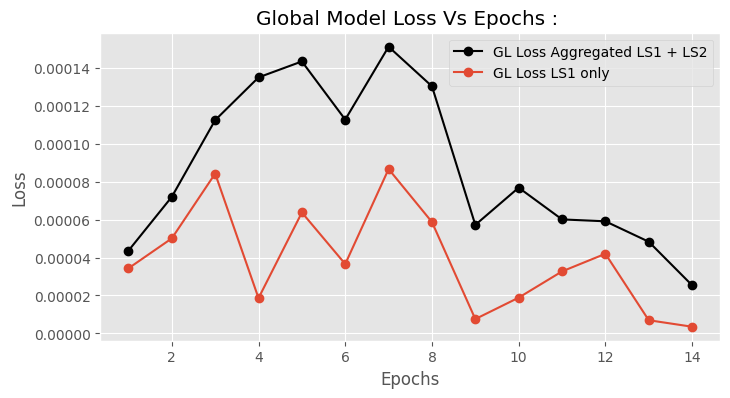

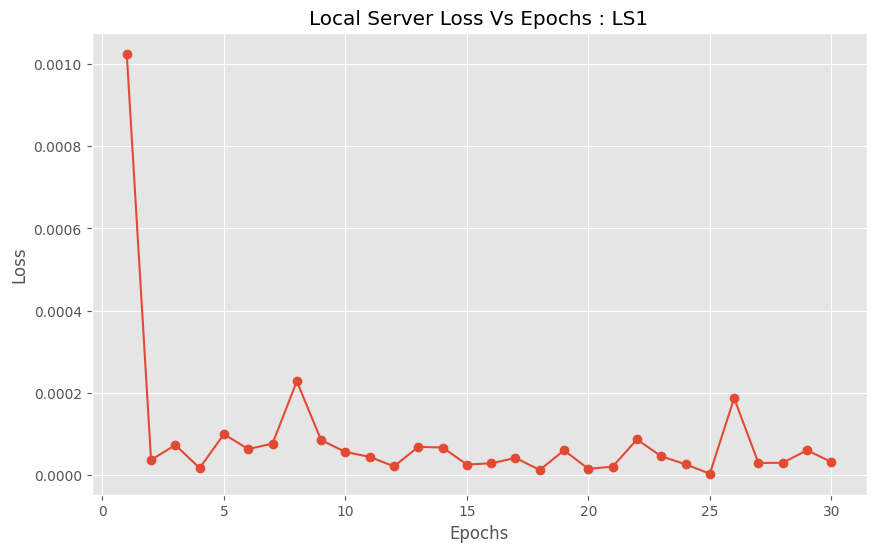

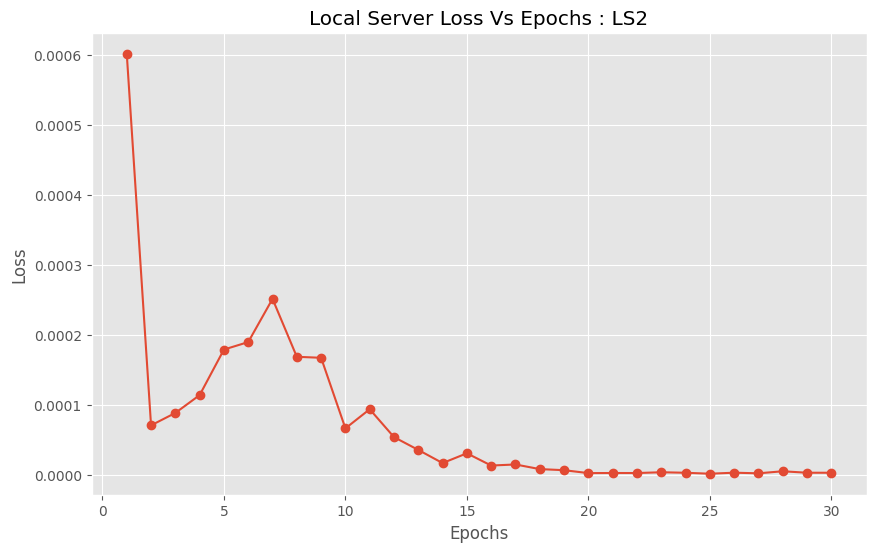

In [ ]:
plot_losses_global(losses_GL_LS1, 'LS1')
plot_losses_global(losses_GL_LS2, 'LS2')

plot_losses_local_server(losses_LS1, 'LS1')
plot_losses_local_server(losses_LS2, 'LS2')

plot_losses_local(epochs_losses)

## Federated Learning Model comparison

In [ ]:
def predictions_for_plotting(model, X_train, train_series, val_series, adjustment=True):
    """Generate predictions for training, validation, and test data using the given model for plotting purposes."""

    # Prepare the last input sequence from the training data
    last_input_seq_train = [train_series[-N_STEPS_IN:]]
    # Predict on this sequence
    val_output = model.predict(last_input_seq_train, verbose=0)
    val_predictions = val_output.flatten().tolist()

    if adjustment:
        # Adjust the validation predictions by shifting them based on the last value of the input sequence
        val_first_pred = val_predictions[0]
        val_predictions = [x + (last_input_seq_train[0, -1, 0] - val_first_pred) for x in val_predictions]
        print(f"Shift Delta for first validation prediction: {round(abs(val_predictions[0] - val_first_pred), 5)}")

    # Prepare the last input sequence from the validation data
    last_input_seq_val = [val_series[-N_STEPS_IN:]]
    # Predict on this sequence
    test_output = model.predict(last_input_seq_val, verbose=0)
    test_predictions = test_output.flatten().tolist()

    if adjustment:
        # Adjust the test predictions by shifting them based on the last value of the input sequence
        test_first_pred = test_predictions[0]
        test_predictions = [x + (last_input_seq_val[0, -1, 0] - test_first_pred) for x in test_predictions]
        print(f"Shift Delta for first test prediction: {round(abs(test_predictions[0] - test_first_pred), 5)}")

    # Generate predictions for the entire training data
    train_predictions = model.predict(X_train, verbose=0)[:, 0].flatten()

    # Convert predictions to numpy arrays
    val_predictions = np.array(val_predictions).flatten()
    test_predictions = np.array(test_predictions).flatten()

    return train_predictions, val_predictions, test_predictions


def plot(model, train_series, val_series, test_series, train_predictions, val_predictions, test_predictions, y_train, print_shape=False):
    """Plot the actual values and predictions for training, validation, and test datasets."""

    if print_shape:
        # Optionally print the shapes of the series and predictions
        print(f"train_series shape : {train_series.shape}")
        print(f"train_series printed shape : {train_series[:, 0].shape}")
        print(f"train_predictions shape : {train_predictions.shape}")
        print(f"test_series shape : {test_series.shape}")
        print(f"test_predictions shape : {test_predictions.shape}")

    plt.figure(figsize=(14, 7))

    # Plot actual training, validation, and test values
    plt.plot(np.arange(len(train_series)), train_series[:, 0], label='Actual Training Values')
    plt.plot(np.arange(len(train_series), len(train_series) + len(val_series)), val_series[:, 0], label='Actual Val Values')
    plt.plot(np.arange(len(train_series) + len(val_series), len(train_series) + len(val_series) + len(test_series)), test_series[:, 0], label='Actual Test Values')

    # Plot input sequences used for testing validation and test predictions
    plt.plot(np.arange(len(train_series) - N_STEPS_IN, len(train_series)), train_series[-N_STEPS_IN:, 0], label='Input for Testing Validation')
    plt.plot(np.arange(len(train_series) + len(val_series) - N_STEPS_IN, len(train_series) + len(val_series)), val_series[-N_STEPS_IN:, 0], label='Input for Testing Test')

    # Plot model predictions for training, validation, and test sets
    plt.plot(np.arange(N_STEPS_IN, N_STEPS_IN + len(y_train)), train_predictions, label='Training Predictions')
    plt.plot(np.arange(len(train_series), len(train_series) + len(val_predictions)), val_predictions, label='Val Predictions')
    plt.plot(np.arange(len(train_series) + len(val_series), len(train_series) + len(val_series) + len(test_predictions)), test_predictions, label='Test Predictions')

    # Add vertical lines to mark the splits between training/validation and validation/test sets
    plt.axvline(x=len(train_series), color='r', linestyle='--', label='Train/Val Split')
    plt.axvline(x=len(train_series) + len(val_series), color='b', linestyle='--', label='Val/Test Split')

    # Display the legend and plot
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def cosine_similarity(w1, w2):
    """Calculate the cosine similarity between two weight matrices."""
    return np.dot(w1.flatten(), w2.flatten()) / (norm(w1.flatten()) * norm(w2.flatten()))


def euclidean_distance(w1, w2):
    """Calculate the Euclidean distance between two weight matrices."""
    return norm(w1.flatten() - w2.flatten())


def compare_models(weights1, weights2):
    """Compare two sets of model weights using cosine similarity and Euclidean distance."""
    cosine_similarities = []
    euclidean_distances = []

    # Iterate over each layer's weights in the two models
    for i, (w1, w2) in enumerate(zip(weights1, weights2)):
        cos_sim = cosine_similarity(w1, w2)  # Compute cosine similarity
        euc_dist = euclidean_distance(w1, w2)  # Compute Euclidean distance

        cosine_similarities.append(cos_sim)
        euclidean_distances.append(euc_dist)

    # Calculate mean and variance of cosine similarities
    mean_cos_sim = np.mean(cosine_similarities)
    var_cos_sim = np.var(cosine_similarities)

    # Calculate mean and variance of Euclidean distances
    mean_euc_dist = np.mean(euclidean_distances)
    var_euc_dist = np.var(euclidean_distances)

    # Return mean and variance for both metrics
    return mean_cos_sim, mean_euc_dist, var_cos_sim, var_euc_dist


def compare_and_display_model_matrix(params_list, model_names):
    """Compare model parameters and display cosine similarity and Euclidean distance matrices."""

    if len(model_names) != len(params_list):
        raise ValueError("Length of model_names must match length of params_list")

    # Initialize empty DataFrames for cosine similarity and Euclidean distance
    cosine_matrix = pd.DataFrame(index=model_names, columns=model_names)
    euclidean_matrix = pd.DataFrame(index=model_names, columns=model_names)

    # Compare each pair of models
    for i, params_1 in enumerate(params_list):
        for j, params_2 in enumerate(params_list):
            # Compute cosine similarity and Euclidean distance between models
            cosine, euclidean, _, _ = compare_models(params_1, params_2)

            # Store the rounded results in the matrices
            cosine_matrix.iloc[i, j] = round(cosine, 3)
            euclidean_matrix.iloc[i, j] = round(euclidean, 3)

    print("Cosine Similarity Matrix:")
    print(cosine_matrix)

    print("\nEuclidean Distance Matrix:")
    print(euclidean_matrix)

    return cosine_matrix, euclidean_matrix

In [ ]:
def evaluate(X, y, model):
    mae, mse, rmse, mape, _ = evaluate_model(model, (X, y), VERSION)
    return round(mse*100000, 2), round(mae*100000, 2)


def evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, title, plot=False):
    """Evaluate the model on training, validation, and test sets, and optionally plot the results."""

    train_mse, train_mae = evaluate(X_train, y_train, model)
    test_mse, test_mae = evaluate(X_test, y_test, model)
    val_mse, val_mae = evaluate(X_val, y_val, model)

    if plot:
        # If plotting is enabled, print the title
        print(title)
        # Generate predictions for plotting
        train_predictions, val_predictions, test_predictions = predictions_for_plotting(model, X_train, train_series, val_series)
        # Plot the actual vs. predicted values
        plot(model, train_series, val_series, test_series, train_predictions, val_predictions, test_predictions, y_train)

    # Return the evaluation metrics
    return train_mse, train_mae, test_mse, test_mae, val_mse, val_mae


In [ ]:
def compare_methods():
    """Compare models (Global, LS1, LS2, Local) across multiple clients and record errors."""

    # Initialize error matrix
    error_matrix = pd.DataFrame(index=[f"Client {i}" for i in range(4)], columns=["Global Model", "LS1 Model", "LS2 Model", "Local Model"])
    losses = []

    for client_id, df in client_data.items():
        loss = []
        print(f"Client ID: {client_id}")

        # Prepare data for the current client
        X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series = data_preparation(df, VERSION, N_STEPS_IN, N_STEPS_OUT, TRAIN_SIZE, VAL_SIZE)

        print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

        model = build_model()

        # Evaluate the global model on the client's data
        model.set_weights(params_GL)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "Global Model" + f" : Client ID: {client_id}", plot=True)
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 0] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the LS1 model on the client's data
        model.set_weights(params_LS1)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "LS1 Model" + f" : Client ID: {client_id}")
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 1] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the LS2 model on the client's data
        model.set_weights(params_LS2)
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "LS2 Model" + f" : Client ID: {client_id}")
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 2] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Evaluate the local model on the client's data
        model = models[client_id]
        train_mse, train_mae, test_mse, test_mae, val_mse, val_mae = evaluate_test_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, train_series, val_series, test_series, "Local Model" + f" : Client ID: {client_id}")
        loss.append([train_mse, val_mse, test_mse, train_mae, val_mae, test_mae])
        error_matrix.iloc[client_id, 3] = f"Train:{train_mse}, Val: {val_mse}, Test:{test_mse}"

        # Store losses for comparison
        losses.append(loss)

    print("\nError * 10e5 for better visibility\n")
    print(error_matrix.to_string(index=True))

    return losses, error_matrix


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Load models
params_list = [params_GL, params_LS1, params_LS2] + [get_parameters(model) for model in models]
model_names = ["Global Model", "LS1 Model", "LS2 Model"] + [f"Model {i}" for i in range(len(models))]

In [ ]:
losses, error_matrix = compare_methods()
print("\n")
cosine_matrix, euclidean_matrix = compare_and_display_model_matrix(params_list, model_names)

Client ID: 0
[15.36428571  1.        ]
Train samples: 2291, Val samples: 311, Test samples: 311
Global Model : Client ID: 0


TypeError: list indices must be integers or slices, not tuple

In [ ]:
print(losses[0])

[[3.78, 1.34, 0.45, 427.45, 306.24, 178.67], [7.4, 5.12, 0.26, 581.03, 533.74, 135.55], [1.47, 0.03, 0.02, 133.86, 55.66, 34.45], [17.71, 0.49, 4.1, 715.99, 204.04, 588.06]]


In [ ]:
def plot_client_losses(losses, error_matrix):
    """Plot training, validation, and test losses for each client across different models."""

    num_clients = len(losses)
    models = ["Global Model", "LS1 Model", "LS2 Model", "Local Model"]
    loss_types = ['Train', 'Val', 'Test']

    for client_id in range(num_clients):
        # Extract losses for the current client
        client_losses = np.array(losses[client_id])
        client_losses = client_losses[:, :3]

        if client_losses.ndim == 1:
            raise ValueError(f"Expected 2D array for client_losses, but got 1D array for Client {client_id}")

        if client_losses.ndim != 2 or client_losses.shape[1] != len(loss_types):
            raise ValueError(f"Expected 2D array with {len(loss_types)} columns (for Train, Val, Test losses) "
                             f"for Client {client_id}, but got shape {client_losses.shape}")

        # Create subplots: one for all losses (Train, Val, Test) and one for Test loss only
        fig, axs = plt.subplots(1, 2, figsize=(12, 3))
        bar_width = 0.2
        index = np.arange(len(models))


        # Plot Train, Val, and Test losses for each model
        for i, loss_type in enumerate(loss_types):
            axs[0].bar(index + i * bar_width, client_losses[:, i], bar_width, label=loss_type)

        # Set titles and labels for the first subplot
        axs[0].set_title(f"Client {client_id}: Train, Val, and Test Losses")
        axs[0].set_xlabel("Model")
        axs[0].set_ylabel("Loss")
        axs[0].set_xticks(index + bar_width)
        axs[0].set_xticklabels(models)
        axs[0].legend()

        # Plot Test loss for each model
        test_losses = client_losses[:, 2]
        axs[1].bar(models, test_losses, color = ['darkred', 'royalblue', 'mediumpurple', 'darkorange'])

        # Set titles and labels for the second subplot
        axs[1].set_title(f"Client {client_id}: Test Loss")
        axs[1].set_xlabel("Model")
        axs[1].set_ylabel("Test Loss")

        # Adjust layout and display the plots
        plt.tight_layout()
        plt.grid(True)
        plt.show()


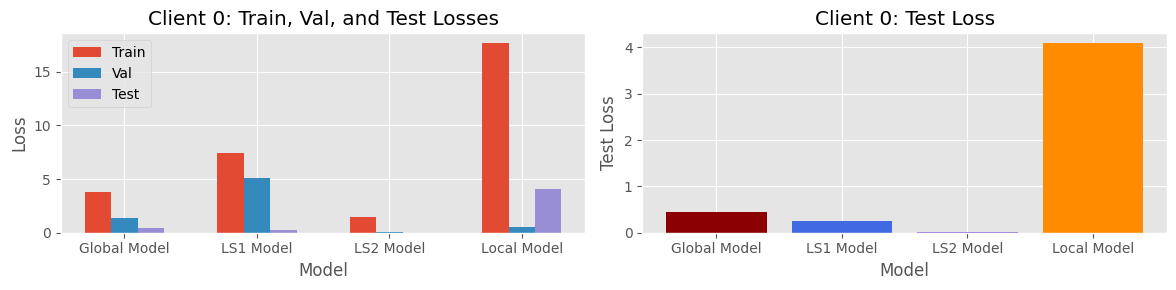

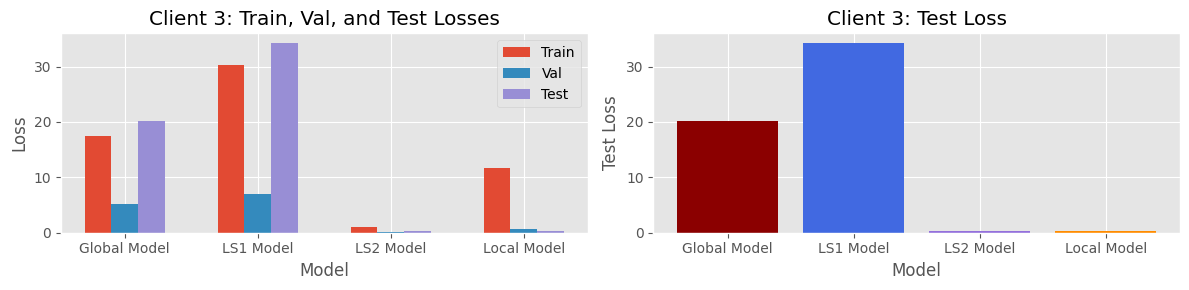

In [ ]:
plot_client_losses(losses, error_matrix)

In [ ]:
# Mapping of loss types to their corresponding indices
loss_plot = {
    'train_mse': 0,
    'val_mse': 1,
    'test_mse': 2,
    'train_mae': 3,
    'val_mae': 4,
    'test_mae': 5
}


def matrix_distance_selection_for_plot(df):
    """Select the first three rows of the specified columns from the matrix and transpose them into a list to create the submatrix of interest."""

    selected_columns = df[['Model 0', 'Model 1', 'Model 2', 'Model 3']]
    first_three_rows = selected_columns.iloc[:3]
    result_list = first_three_rows.transpose().values.tolist()
    return result_list


def plot_result_losses_vs_similarity(cosine_matrix, euclidean_matrix, losses, loss):
    """Plot the specified loss against cosine and Euclidean similarity with local model for each client."""

    # Prepare lists of cosine and Euclidean similarities
    list_cosine = matrix_distance_selection_for_plot(cosine_matrix)
    list_euclidean = matrix_distance_selection_for_plot(euclidean_matrix)

    nb = loss_plot[loss]  # Get the index corresponding to the selected loss

    # Plot Loss vs. Cosine Similarity
    for client_id in client_data:
        x_values = list_cosine[client_id]
        y_values = [value[nb] for value in losses[client_id]]
        y_values = y_values[:-1]  # Exclude the last value for comparison
        sorted_pairs = sorted(zip(x_values, y_values))
        sorted_x, sorted_y = zip(*sorted_pairs)
        plt.plot(sorted_x, sorted_y, label=f'Client {client_id}', marker='o')

    plt.xlabel('Cosine Similarity with Local Model')
    plt.ylabel('Loss : ' + loss)
    plt.title('Loss vs Cosine Similarity')
    plt.legend()
    plt.show()

    # Plot Loss vs. Euclidean Similarity
    for client_id in client_data:
        x_values = list_euclidean[client_id]
        y_values = [value[nb] for value in losses[client_id]]
        y_values = y_values[:-1]  # Exclude the last value for comparison
        sorted_pairs = sorted(zip(x_values, y_values))
        sorted_x, sorted_y = zip(*sorted_pairs)
        plt.plot(sorted_x, sorted_y, label=f'Client {client_id}', marker='o')

    plt.xlabel('Euclidean Similarity with Local Model')
    plt.ylabel('Loss : ' + loss)
    plt.title('Loss vs Euclidean Similarity')
    plt.legend()
    plt.grid(True)
    plt.show()


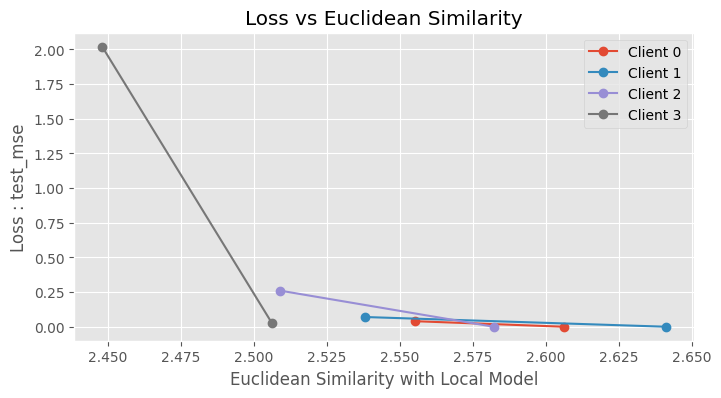

In [ ]:
plot_result_losses_vs_similarity(cosine_matrix, euclidean_matrix, losses, 'test_mse')

#DRAFTS (not working)


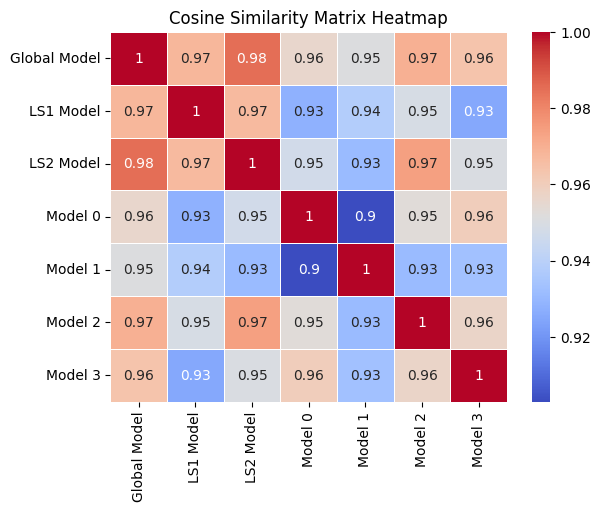

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple de DataFrame pour la matrice de similarité cosinus
data = {
    'Global Model': [1.0, 0.968, 0.985, 0.956, 0.951, 0.970, 0.964],
    'LS1 Model': [0.968, 1.0, 0.967, 0.928, 0.938, 0.949, 0.925],
    'LS2 Model': [0.985, 0.967, 1.0, 0.947, 0.931, 0.974, 0.950],
    'Model 0': [0.956, 0.928, 0.947, 1.0, 0.903, 0.953, 0.960],
    'Model 1': [0.951, 0.938, 0.931, 0.903, 1.0, 0.931, 0.933],
    'Model 2': [0.970, 0.949, 0.974, 0.953, 0.931, 1.0, 0.957],
    'Model 3': [0.964, 0.925, 0.950, 0.960, 0.933, 0.957, 1.0],
}

cosine_similarity_df = pd.DataFrame(data, index=['Global Model', 'LS1 Model', 'LS2 Model', 'Model 0', 'Model 1', 'Model 2', 'Model 3'])

sns.heatmap(cosine_similarity_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Cosine Similarity Matrix Heatmap')
plt.show()


In [ ]:
# def data_preparation(series, version, n_steps_in, n_steps_out, train_size, val_size):
#     if len(series) == 0:
#         raise ValueError("The series is empty")

#     split_idx_train = int(train_size * len(series))
#     split_idx_val = int((train_size + val_size) * len(series))

#     train_series = series[:split_idx_train].values
#     val_series = series[split_idx_train:split_idx_val].values
#     test_series = series[split_idx_val:].values

#     X_train, y_train = [], []
#     X_val, y_val = [], []
#     X_test, y_test = [], []

#     for i in range(len(train_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_train.append(train_series_scaled[i:i + n_steps_in])
#         y_train.append(train_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])
#     for i in range(len(val_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_val.append(val_series_scaled[i:i + n_steps_in])
#         y_val.append(val_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])
#     for i in range(len(test_series_scaled) - n_steps_in - n_steps_out + 1):
#         X_test.append(test_series_scaled[i:i + n_steps_in])
#         y_test.append(test_series_scaled[i + n_steps_in:i + n_steps_in + n_steps_out])

#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     X_val = np.array(X_val)
#     y_val = np.array(y_val)
#     X_test = np.array(X_test)
#     y_test = np.array(y_test)

#     y_train = y_train[:,:,0]
#     y_val = y_val[:,:,0]
#     y_test = y_test[:,:,0]

#     return X_train, y_train, X_val, y_val, X_test, y_test, train_series_scaled, val_series_scaled, test_series_scaled


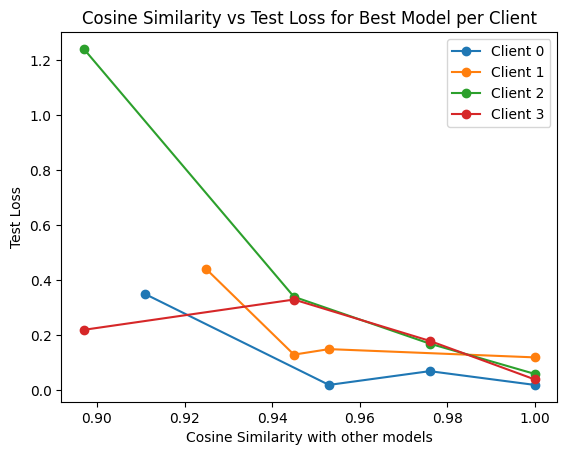

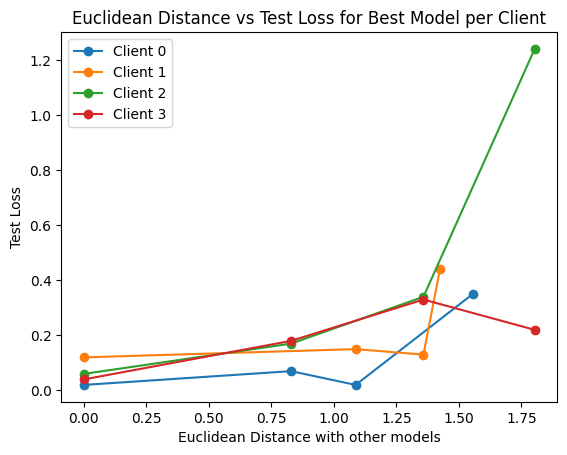

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Test loss values from the image (inferred from the table)
test_losses = {
    'Client 0': [0.02, 0.02, 0.07, 0.35],
    'Client 1': [0.15, 0.12, 0.13, 0.44],
    'Client 2': [0.17, 0.34, 0.06, 1.24],
    'Client 3': [0.18, 0.33, 0.04, 0.22]
}

# Cosine similarity matrix (inferred from the table)
cosine_similarity = np.array([
    [1.0, 0.953, 0.976, 0.911, 0.896, 0.918, 0.911],
    [0.953, 1.0, 0.945, 0.925, 0.898, 0.917, 0.893],
    [0.976, 0.945, 1.0, 0.897, 0.885, 0.912, 0.917],
    [0.911, 0.925, 0.897, 1.0, 0.957, 0.972, 0.922],
    [0.896, 0.897, 0.885, 0.957, 1.0, 0.952, 0.923],
    [0.918, 0.917, 0.912, 0.972, 0.952, 1.0, 0.949],
    [0.911, 0.893, 0.917, 0.922, 0.923, 0.949, 1.0]
])

# Euclidean distance matrix (inferred from the table)
euclidean_distance = np.array([
    [0.0, 1.087, 0.829, 1.555, 1.545, 1.513, 1.46],
    [1.087, 0.0, 1.358, 1.424, 1.462, 1.461, 1.488],
    [0.829, 1.358, 0.0, 1.803, 1.775, 1.739, 1.651],
    [1.555, 1.424, 1.803, 0.0, 0.451, 0.348, 0.537],
    [1.545, 1.462, 1.775, 0.451, 0.0, 0.478, 0.478],
    [1.513, 1.461, 1.739, 0.348, 0.478, 0.0, 0.478],
    [1.46, 1.488, 1.651, 0.537, 0.478, 0.478, 0.0]
])

# Model indices mapping (inferred from the table):
# 0: Global Model, 1: LS1 Model, 2: LS2 Model, 3: Local Model

model_names = ['Global Model', 'LS1 Model', 'LS2 Model', 'Local Model']

# Find the model with the lowest test loss for each client
best_models = {}
for client, losses in test_losses.items():
    best_model_idx = np.argmin(losses)
    best_models[client] = best_model_idx

    # Prepare data for plotting
cosine_similarity_data = []
euclidean_distance_data = []
test_loss_data = []

for client, best_model_idx in best_models.items():
    cosine_similarity_values = cosine_similarity[best_model_idx, :4]  # Select only the first 4 models (Global, LS1, LS2, Local)
    euclidean_distance_values = euclidean_distance[best_model_idx, :4]  # Select only the first 4 models (Global, LS1, LS2, Local)
    loss_value = test_losses[client]

    cosine_similarity_data.append(cosine_similarity_values)
    euclidean_distance_data.append(euclidean_distance_values)
    test_loss_data.append(loss_value)

# Plot Cosine Similarity vs Test Loss
for idx, (cos_sim_values, loss_value) in enumerate(zip(cosine_similarity_data, test_loss_data)):
    sorted_pairs = sorted(zip(cos_sim_values, loss_value))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, label=f'Client {idx}', marker='o')
plt.xlabel('Cosine Similarity with other models')
plt.ylabel('Test Loss')
plt.title('Cosine Similarity vs Test Loss for Best Model per Client')
plt.legend()
plt.show()

# Plot Euclidean Distance vs Test Loss
for idx, (euc_dist_values, loss_value) in enumerate(zip(euclidean_distance_data, test_loss_data)):
    sorted_pairs = sorted(zip(euc_dist_values, loss_value))
    sorted_x, sorted_y = zip(*sorted_pairs)
    plt.plot(sorted_x, sorted_y, label=f'Client {idx}', marker='o')
plt.xlabel('Euclidean Distance with other models')
plt.ylabel('Test Loss')
plt.title('Euclidean Distance vs Test Loss for Best Model per Client')
plt.legend()
plt.show()


In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
series = np.array(df_client)
time = np.arange(len(series))

split_time = 2100

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train.reshape(-1, 1)).flatten()
x_valid = scaler.transform(x_valid.reshape(-1, 1)).flatten()

window_size = 100
batch_size = 32
shuffle_buffer_size = 100
prediction_steps = 400

def windowed_dataset(series, window_size, batch_size, shuffle_buffer, prediction_steps):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + prediction_steps, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + prediction_steps))
    dataset = dataset.map(lambda window: (window[:window_size], window[window_size:]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size, prediction_steps)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size, prediction_steps)

for x, y in train_set.take(1):
    print(f"Input batch shape: {x.shape}")
    print(f"Output batch shape: {y.shape}")


for x, y in train_set.take(1):
    print(f"Input batch shape: {x.shape}")
    print(f"Output batch shape: {y.shape}")


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(prediction_steps)
])

init_weights = model.get_weights()

model.summary()



Input batch shape: (32, 100)
Output batch shape: (32, 400)
Input batch shape: (32, 100)
Output batch shape: (32, 400)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 100, 64)           256       
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          98816     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 400)               51600     
  

Epoch 1/10
51/51 [==============================] - 8s 33ms/step - loss: 0.2291 - mae: 0.6659
Epoch 2/10
51/51 [==============================] - 1s 25ms/step - loss: 0.0112 - mae: 0.0978
Epoch 3/10
51/51 [==============================] - 1s 23ms/step - loss: 0.0033 - mae: 0.0654
Epoch 4/10
51/51 [==============================] - 1s 23ms/step - loss: 0.0034 - mae: 0.0661
Epoch 5/10
51/51 [==============================] - 2s 36ms/step - loss: 0.0034 - mae: 0.0665
Epoch 6/10
51/51 [==============================] - 1s 26ms/step - loss: 0.0034 - mae: 0.0661
Epoch 7/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0034 - mae: 0.0657
Epoch 8/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0033 - mae: 0.0659
Epoch 9/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0034 - mae: 0.0657
Epoch 10/10
51/51 [==============================] - 1s 24ms/step - loss: 0.0033 - mae: 0.0655


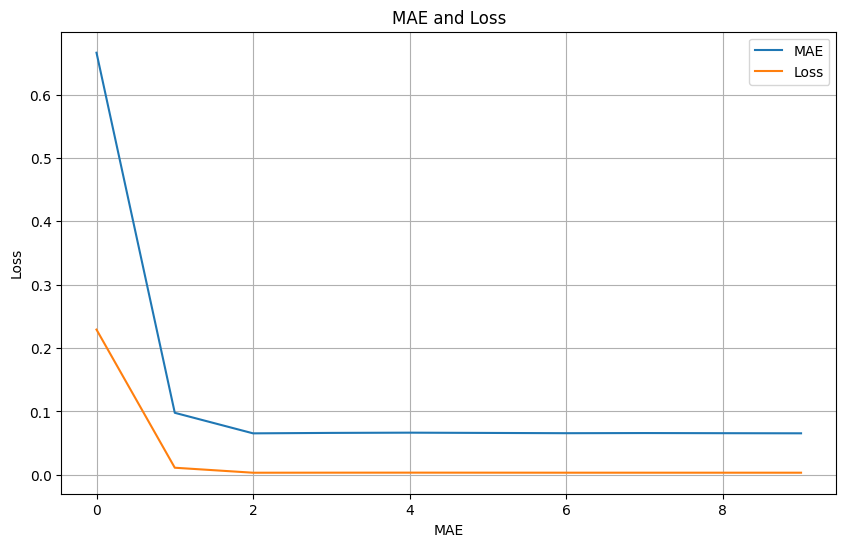

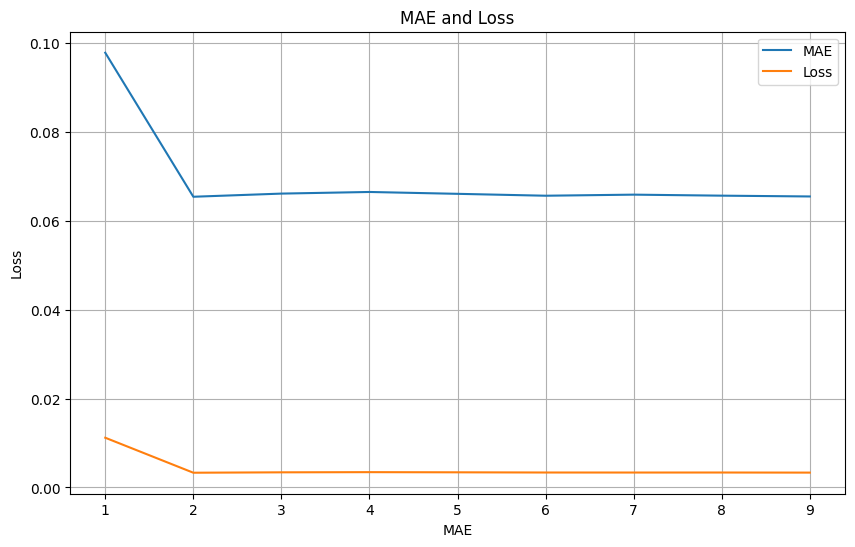

In [ ]:
tf.keras.backend.clear_session()

model.set_weights(init_weights)

learning_rate = 8e-2

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=10)

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

1/1 [==============================] - 0s 44ms/step


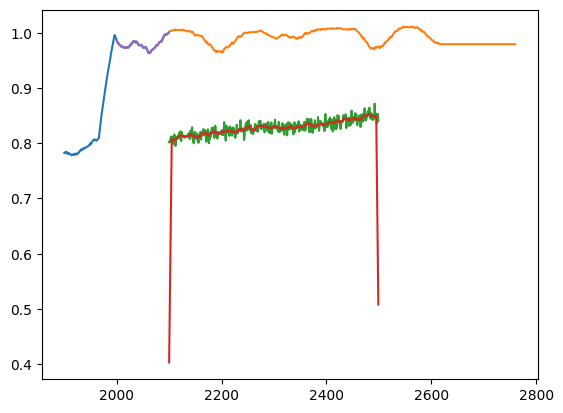

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

forecast_series = x_train[split_time-window_size:split_time]
#forecast_series = [2]*window_size
'''np.random.seed(112)
forecast_series = np.random.rand(window_size)
forecast_series = forecast_series.tolist()
'''
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()
window_avg = 10
window = np.ones(window_avg) / window_avg
results_avg = np.convolve(results, window, mode='same')

# Plot the results

plt.plot(time_train[1900:],x_train[1900:])
plt.plot(time_valid, x_valid)
plt.plot(np.arange(split_time, split_time+prediction_steps), results)
plt.plot(np.arange(split_time, split_time+prediction_steps), results_avg)
plt.plot(time_train[split_time-window_size:split_time],forecast_series)

Epoch 1/100
51/51 [==============================] - 4s 23ms/step - loss: 0.2743 - lr: 1.0000e-04
Epoch 2/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2741 - lr: 1.1220e-04
Epoch 3/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2740 - lr: 1.2589e-04
Epoch 4/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2738 - lr: 1.4125e-04
Epoch 5/100
51/51 [==============================] - 2s 33ms/step - loss: 0.2736 - lr: 1.5849e-04
Epoch 6/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2734 - lr: 1.7783e-04
Epoch 7/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2732 - lr: 1.9953e-04
Epoch 8/100
51/51 [==============================] - 1s 23ms/step - loss: 0.2729 - lr: 2.2387e-04
Epoch 9/100
51/51 [==============================] - 1s 25ms/step - loss: 0.2727 - lr: 2.5119e-04
Epoch 10/100
51/51 [==============================] - 1s 24ms/step - loss: 0.2723 - lr: 2.8184e-04
Epoch 11/100
51/51 

(0.0001, 1.0, 0.0, 0.01)

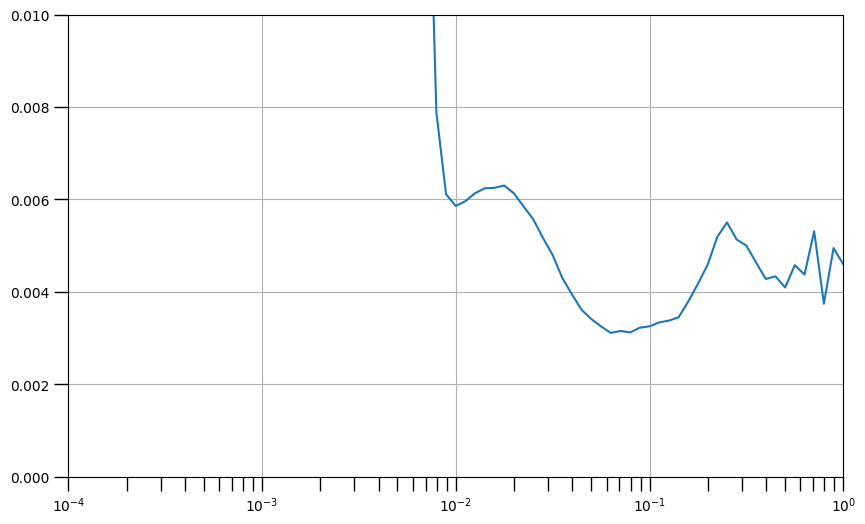

In [ ]:
#Find the best LEARNING_RATE

model.set_weights(init_weights)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-4, 1, 0, 0.01])

##Pytorch and tests

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


def my_scorer(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

custom_scorer = make_scorer(my_scorer, greater_is_better=False)
model = KerasRegressor(build_fn=build_lstm_model)

# Paramètres de la grille
param_grid = {
    'input_size': [INPUT_SIZE],
    'hidden_size': [50, 100, 150],
    'output_size': [OUTPUT_SIZE],
    'num_layers': [1, 2, 3],
    'version': ['short', 'long'],
    'prediction_steps': [PREDICTION_STEPS],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}

# GridSearchCV avec custom scorer
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=custom_scorer, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
from sklearn.preprocessing import StandardScaler

NUM_CLIENTS = 3
BATCH_SIZE = 32
SEQUENCE_LENGTH = 400
# give 10 input and get 4-10 outputs
# changing number of feqtures
def data_preparation(series, sequence_length=SEQUENCE_LENGTH, train_size=0.8):
    if series.empty:
        raise ValueError("The series is empty")
    split_idx = int(train_size * len(series))
    train_series = series[:split_idx]
    test_series = series[split_idx:]
    #scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    train_series_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    test_series_scaled = scaler.transform(test_series.values.reshape(-1, 1))
    X_train, y_train = [], []
    X_test, y_test = [], []
    for i in range(len(train_series_scaled) - sequence_length):
        X_train.append(train_series_scaled[i:i + sequence_length])
        y_train.append(train_series_scaled[i + sequence_length])

    X_train = np.array(X_train)
    y_train = np.array(y_train)


    for i in range(len(test_series_scaled) - sequence_length):
        X_test.append(test_series_scaled[i:i + sequence_length])
        y_test.append(test_series_scaled[i + sequence_length])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test


def create_dataloaders(client_data, batch_size=BATCH_SIZE, sequence_length=SEQUENCE_LENGTH):
    trainloaders = []
    valloaders = []
    for client_id, series in client_data.items():
        X_train, y_train, X_val, y_val = data_preparation(series, sequence_length)
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        trainloaders.append(trainloader)
        valloaders.append(valloader)
    return trainloaders, valloaders

'''client_data = {
    0: df_N1OZ['Soil Hum (N1 - OZ)'],
    1: df_N2OZ['Soil Hum (N2 - OZ)'],
    2: df_N0OZ['Soil Hum (N0 - OZ)']
}
client_data = {
    2: df_N0OZ['Soil Hum (N0 - OZ)']
}'''
'''client_data = {
    0: df_N1OZ['Moving Average'],
    1: df_N2OZ['Moving Average'],
    2: df_N0OZ['Moving Average']
}'''


trainloaders, valloaders = create_dataloaders(client_data)

for i, trainloader in enumerate(trainloaders):
    print(f"Client {i} - Number of training batches: {len(trainloader)}")
    for inputs, labels in trainloader:
      print("Forme des entrées (inputs):", inputs.shape)
      print("Forme des labels:", labels.shape)
      break

for i, valloader in enumerate(valloaders):
    print(f"Client {i} - Number of test batches: {len(valloader)}")



Client 0 - Number of training batches: 55
Forme des entrées (inputs): torch.Size([32, 400, 1])
Forme des labels: torch.Size([32, 1])
Client 0 - Number of test batches: 5


In [ ]:
#PYTORCH

INPUT_SIZE = 1
HIDDEN_SIZE = 20
NUM_LAYERS = 7
OUTPUT_SIZE = 1
LEARNING_RATE = 0.01

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
        #return out.view(out.size(0), -1)

max_grad_norm = 50.0

def train_LSM(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_samples = 0
        i = 0
        for inputs, targets in train_loader:
            inputs = inputs.view(-1, SEQUENCE_LENGTH, 1).to(DEVICE)
            #targets = targets.view(-1, OUTPUT_LENGTH).to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            if i== -1 :
              print(f"Batch number {i}")
              #print(f"Ready inputs : {inputs[0]} ")
              print(f"Raw outputs : {outputs[0]} ")
              print(f"Raw targets : {targets[0]} ")
            loss = criterion(outputs, targets)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

            running_loss += loss.item() * targets.size(0)
            total_samples += targets.size(0)
            i = 1

        epoch_loss = running_loss / total_samples if total_samples > 0 else float('inf')
        epoch_losses.append(epoch_loss)

        if (epoch) % 2 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return model, epoch_losses


def test(net, test_loader, criterion):
    net.eval()
    total_loss = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, SEQUENCE_LENGTH, 1)
            #targets = targets.view(-1, OUTPUT_LENGTH).to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * targets.size(0)
            total += targets.size(0)
    avg_loss = total_loss / total if total > 0 else float('inf')
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss, None


def get_parameters(model):
    return [param.data.cpu().numpy() for param in model.parameters()]


def set_parameters(model, parameters):
    for param, new_param in zip(model.parameters(), parameters):
        param.data = torch.tensor(new_param).to(param.device)


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Dict[str, Scalar]:
    num_samples_list = [num_samples for num_samples, _ in metrics]
    num_samples_sum = sum(num_samples_list)
    weighted_metrics: Dict[str, List[float]] = {}

    for num_samples, metrics_dict in metrics:
        for metric, value in metrics_dict.items():
            if metric not in weighted_metrics:
                weighted_metrics[metric] = []
            weighted_metrics[metric].append(value * num_samples)

    return {metric: sum(values) / num_samples_sum for metric, values in weighted_metrics.items()}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

NUM_EPOCHS = 25
metrics = []
FUTURE_PERIOD = 200

num_clients = len(client_data)
fig, axs = plt.subplots(num_clients, 1, figsize=(14, 7 * num_clients))

if num_clients == 1:
    axs = [axs]

for idx, client_id in enumerate(client_data.keys()):
    df_client = client_data[client_id]

    X_train, y_train, X_test, y_test = data_preparation(df_client, SEQUENCE_LENGTH)
    print(f"Client {client_id} selected. Train samples: {len(X_train)}, Test samples: {len(X_test)}")

    single_client_model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS).to(DEVICE)
    single_criterion = nn.MSELoss()
    single_optimizer = optim.Adam(single_client_model.parameters(), lr=LEARNING_RATE)

    single_train_loader = trainloaders[idx]
    single_test_loader = valloaders[idx]
    print(f"Client {idx} - Number of training batches: {len(single_train_loader)}")
    print(f"Client {idx} - Number of test batches: {len(single_test_loader)}")

    single_client_model, epoch_losses = train_LSM(single_client_model, single_train_loader, single_criterion, single_optimizer, NUM_EPOCHS)

    single_client_model.eval()
    train_predictions = []
    test_predictions = []
    future_predictions = []

    with torch.no_grad():
        for i in range(len(X_train)):
            input_seq = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).to(DEVICE)
            output = single_client_model(input_seq)
            output_np = output.cpu().numpy()
            if i % 30000 == 0:
                print(f"Input {i}: {input_seq}")
                print(f"Output shape for input {i}: {output.shape}")
                print(f"Output for input {i}: {output_np}")
            train_predictions.append(output_np)

    with torch.no_grad():
        last_input_seq = torch.tensor(X_train[-1], dtype=torch.float32).unsqueeze(0).to(DEVICE)
        for i in range(len(X_test)):
            future_output = single_client_model(last_input_seq)
            test_predictions.append(future_output.cpu().numpy())
            last_input_seq = torch.cat((last_input_seq[:, 1:, :], future_output.unsqueeze(0)), dim=1)

    with torch.no_grad():
        for i in range(FUTURE_PERIOD):
            future_output = single_client_model(last_input_seq)
            future_predictions.append(future_output.cpu().numpy())
            last_input_seq = torch.cat((last_input_seq[:, 1:, :], future_output.unsqueeze(0)), dim=1)

    train_predictions = np.array(train_predictions).flatten()
    test_predictions = np.array(test_predictions).flatten()
    future_predictions = np.array(future_predictions).flatten()

    mae_train = mean_absolute_error(y_train, train_predictions)
    mse_train = mean_squared_error(y_train, train_predictions)
    rmse_train = np.sqrt(mse_train)

    plt.plot(np.arange(len(y_train)), y_train, label='Actual Training Values')
    plt.plot(np.arange(len(y_train)), train_predictions, label='Training Predictions')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Values')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label='Test Predictions')
    plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + FUTURE_PERIOD), future_predictions, label='Future Predictions')

    plt.axvline(x=len(y_train), color='r', linestyle='--', label='Train/Test Split')
    plt.axvline(x=len(y_train) + len(y_test), color='g', linestyle='--', label='Future Predictions Start')

    plt.legend()
    plt.title(f"Predictions\nMAE: {mae_train:.4f}, MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}")
    plt.tight_layout()
    plt.show()

    mae_test = mean_absolute_error(y_test, test_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)
    rmse_test = np.sqrt(mse_test)

    final_loss = epoch_losses[-1]
    num_samples = len(single_train_loader.dataset) + len(single_test_loader.dataset)
    metrics.append((num_samples, {"loss": final_loss, "mae": mae_test, "mse": mse_test, "rmse": rmse_test}))

final_metrics = weighted_average(metrics)
print(f"Final average loss across all clients FOR TRAINING DATA: {final_metrics['loss']:.6f}")
print(f"Final average MAE across all clients: {final_metrics['mae']:.6f}")
print(f"Final average MSE across all clients: {final_metrics['mse']:.6f}")
print(f"Final average RMSE across all clients: {final_metrics['rmse']:.6f}")


Client 0 selected. Train samples: 1741, Test samples: 136
Client 0 - Number of training batches: 55
Client 0 - Number of test batches: 5
Epoch [0/25], Loss: 0.9003
Epoch [2/25], Loss: 0.7711
Epoch [4/25], Loss: 0.7664
Epoch [6/25], Loss: 0.7651
Epoch [8/25], Loss: 0.7649


KeyboardInterrupt: 

In [ ]:
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    GetParametersIns,
    GetParametersRes,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

class FlowerClient(fl.client.Client):
    def __init__(self, net, trainloader, valloader, criterion, optimizer):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.criterion = criterion
        self.optimizer = optimizer

    def get_parameters(self, config) -> List[np.ndarray]:
        ndarrays: List[np.ndarray] = [val.cpu().numpy() for val in self.net.state_dict().values()]
        return ndarrays

    def set_parameters(self, parameters: List[np.ndarray]) -> None:
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, ins: FitIns) -> FitRes:
        parameters_original = ins.parameters
        config = ins.config
        ndarrays_original = parameters_to_ndarrays(parameters_original)
        self.set_parameters(ndarrays_original)

        local_epochs = int(config["local_epochs"])
        server_round = config["server_round"]
        self.train(self.trainloader, self.criterion, self.optimizer, num_epochs=local_epochs)

        ndarrays_updated = self.get_parameters()
        parameters_updated = ndarrays_to_parameters(ndarrays_updated)

        status = Status(code=Code.OK, message="Success")
        return FitRes(
            status=status,
            parameters=parameters_updated,
            num_examples=len(self.trainloader.dataset),
            metrics={},
        )

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        parameters_original = ins.parameters
        config = ins.config
        ndarrays_original = parameters_to_ndarrays(parameters_original)
        self.set_parameters(ndarrays_original)

        loss, accuracy = self.test(self.valloader, self.criterion)

        status = Status(code=Code.OK, message="Success")
        return EvaluateRes(
            status=status,
            loss=float(loss),
            num_examples=len(self.valloader.dataset),
            metrics={"accuracy": float(accuracy)},
        )

    def train(self, trainloader, criterion, optimizer, num_epochs=5):
        return train(self.net, trainloader, criterion, optimizer, num_epochs)

    def test(self, valloader, criterion):
        return test(self.net, valloader, criterion)




In [ ]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def client_fn(cid: str) -> FlowerClient:

    model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS).to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    return FlowerClient(model, trainloader, valloader, criterion, optimizer).to_client()


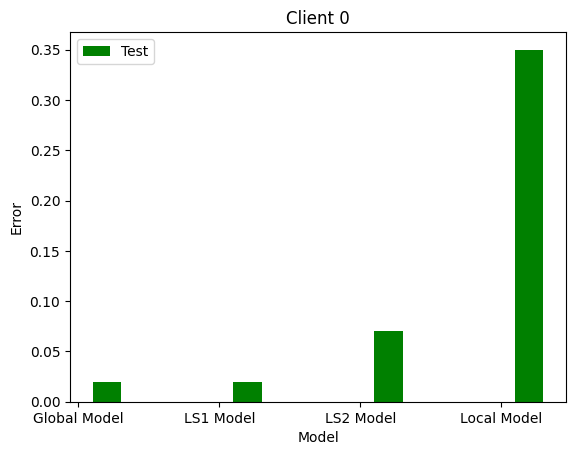

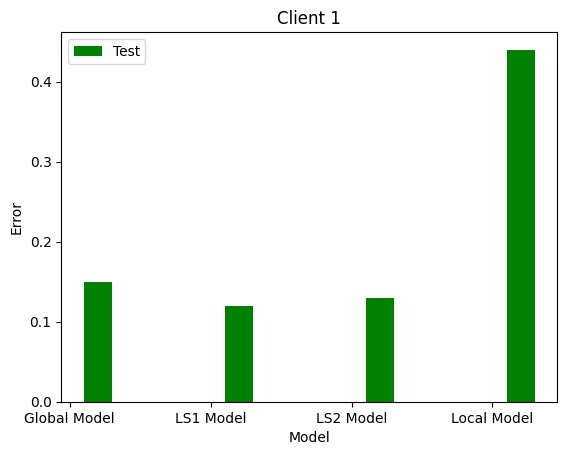

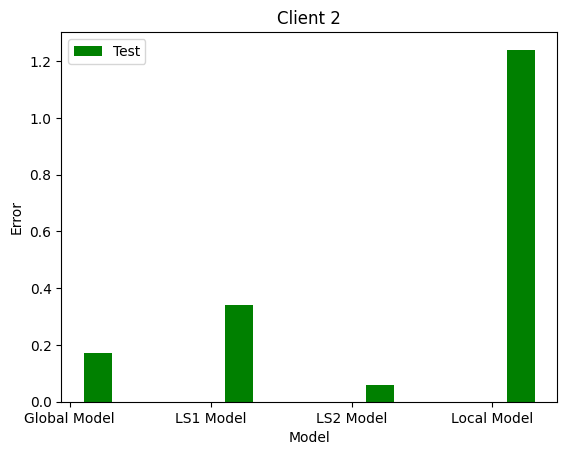

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

# Données extraites de l'image fournie
data = {
    "Client 0": {
        "Global Model": (0.67, 0.05, 0.02),
        "LS1 Model": (2.34, 1.03, 0.02),
        "LS2 Model": (0.78, 0.02, 0.07),
        "Local Model": (3.03, 0.19, 0.35)
    },
    "Client 1": {
        "Global Model": (1.28, 0.03, 0.15),
        "LS1 Model": (4.34, 0.9, 0.12),
        "LS2 Model": (1.51, 0.04, 0.13),
        "Local Model": (7.03, 4.4, 0.44)
    },
    "Client 2": {
        "Global Model": (1.18, 0.23, 0.17),
        "LS1 Model": (3.22, 4.15, 0.34),
        "LS2 Model": (1.27, 0.4, 0.06),
        "Local Model": (1.53, 1.71, 1.24)
    },
    "Client 3": {
        "Global Model": (0.38, 0.22, 0.18),
        "LS1 Model": (5.96, 0.92, 0.33),
        "LS2 Model": (0.29, 0.03, 0.04),
        "Local Model": (1.69, 0.2, 0.22)
    }
}
#data = error_matrix
# Création des graphiques pour chaque client
for client, values in data.items():
    models = list(values.keys())
    train_values = [values[model][0] for model in models]
    val_values = [values[model][1] for model in models]
    test_values = [values[model][2] for model in models]

    x = np.arange(len(models))  # positions des labels
    width = 0.2  # largeur des barres

    fig, ax = plt.subplots()
    #ax.bar(x - width, train_values, width, label='Train')
    #ax.bar(x, val_values, width, label='Val')
    ax.bar(x + width, test_values, width, label='Test', color = 'green')

    ax.set_xlabel('Model')
    ax.set_ylabel('Error')
    ax.set_title(f'{client}')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()
